# Project - Ariel Hedvat and Yuval Rubinstein

## Imports and Data

In [129]:
import pandas as pd
import numpy as np
from sklearn import feature_selection
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
from sklearn import datasets, ensemble
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, IsolationForest
from sklearn.impute import SimpleImputer
from typing import List, Dict
from sklearn.cluster import DBSCAN, KMeans
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, normaltest, chi2_contingency
from sklearn.feature_selection import RFECV
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier
warnings.filterwarnings('ignore')
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [130]:
### load the train dataset

df = pd.read_csv("train.csv")
testing_df = pd.read_csv("test.csv")
pd.set_option('display.max_columns', None)
sns.set(color_codes=True)

#### Basic overview on the data:

In [131]:
print(df.shape)
df.head()

(60000, 24)


sha256     size      vsize  \
0  a5d72c609a1594621e8eb775e7324d4fc291d5569cfefd...  6744064 6799360.00   
1  ccaa49b76e6fd84842399c4389e2086a5a3687dfabbf01...    22016   45056.00   
2  b0b126adc73b980a114e38027b082d149fcf491547452f...   686136  704512.00   
3  ff6176c53ca9b58040c93870c264843b93b5e290c28e57...     8192   36864.00   
4  59b8bc6ac157a553440978406c8aa8eb8a25c166af1175...   396288  421888.00   

   imports  exports  has_debug  has_relocations  has_resources  has_signature  \
0   524.00     3.00       0.00             1.00           1.00           0.00   
1     2.00     0.00       0.00             0.00           1.00           0.00   
2   133.00     4.00       1.00             1.00           1.00           1.00   
3     6.00     0.00       0.00             0.00           0.00           0.00   
4   133.00     0.00       1.00             1.00           1.00           0.00   

   has_tls  symbols  numstrings  paths  urls  registry    MZ  printables  \
0     1.00     0.00    64882.00   0.00  0.00      0.00 28.00   899075.00   
1     0.00     0.00       89.00   0.00  0.00      0.00  1.00      856.00   
2     0.00     0.00     2699.00   0.00 32.00      0.00  2.00    32767.00   
3     0.00      NaN       71.00   0.00  0.00      0.00  1.00      678.00   
4     0.00     0.00     4729.00   0.00  0.00      0.00  5.00    35881.00   

   avlength                            file_type_trid  file_type_prob_trid  \
0     13.86  Win32 EXE PECompact compressed (generic)                64.20   
1      9.62      Win32 Dynamic Link Library (generic)                38.40   
2     12.14                Win64 Executable (generic)                82.00   
3      9.55                Win64 Executable (generic)                28.00   
4      7.59                Win64 Executable (generic)                32.20   

      A    B    C  label  
0 -3.98 5.73   er      1  
1  7.06 5.74   er      0  
2  1.05 5.72  gow      0  
3  2.22 5.90   vh      1  
4  9.40  NaN   vh      1

In [132]:
#calculating the number of missing values in each column of a DataFrame and creates a copy of the DataFrame with missing values filled in with 0

missing_values = df.isnull().sum()
print(missing_values)

main_df = df.copy()

sha256                    0
size                      0
vsize                  1935
imports                1739
exports                2093
has_debug              2927
has_relocations        3324
has_resources          1961
has_signature          1937
has_tls                2898
symbols                2656
numstrings             2718
paths                  3660
urls                   2349
registry               2525
MZ                     3089
printables             2739
avlength               2757
file_type_trid            0
file_type_prob_trid       0
A                      3704
B                      3751
C                      2051
label                     0
dtype: int64


#### For later:

Here we indicate the meaning of each dataset parameter in order to help us later in the project:
* df = The original training data.
* testing_df = The original testing data. 
* main_df = a copy of df with log on all the numeric featuers.
* train_df = an exact copy of df (We don't want to contaminate the original copy).
* c_test = an exact copy of testing_df (We don't want to contaminate the original copy).
* Xlog_train, Xlog_val, ylog_train, ylog_val = Initial division of the training data into data for training and test (with X representing all the features and y representing the label). This is the data that will contain the final features (including log transformations).
* test_df = a copy of c_test, this is the last data test version.
* X_train_reduced, X_val_reduced, test_reduced = The updated data after using PCA on the whole features.
* X_train_combined, X_val_combined, test_combined = The updated data after using PCA only on the numeric features.

Here we indicate the meaning of each helping list in order to help us later in the project:
* catagorial = the catagorial features
* numerical = the numeric features
* normally_features = all normally distributed features (including additional feature and the transformations). The final list. 
* bool_features = all the has features (1=has or 0=dont has, means this is boolean)
* to_log = list of all the features we will do log transformation (the reasons for this appear in the visualization).
* removed_features = features that we saw that its right to remove from the data for reasons we will specify.
* updated_numeric_features, updated_not_numeric_features = the final and updated numeric and not numeric features inthe final data.

## Exploration 

__Our questions and thoughts on the data:__

1. What are the correlations between features / label in our data?
2. How do our features distribute and does the label affect them?
3. How can we understand the features meaning / effects?

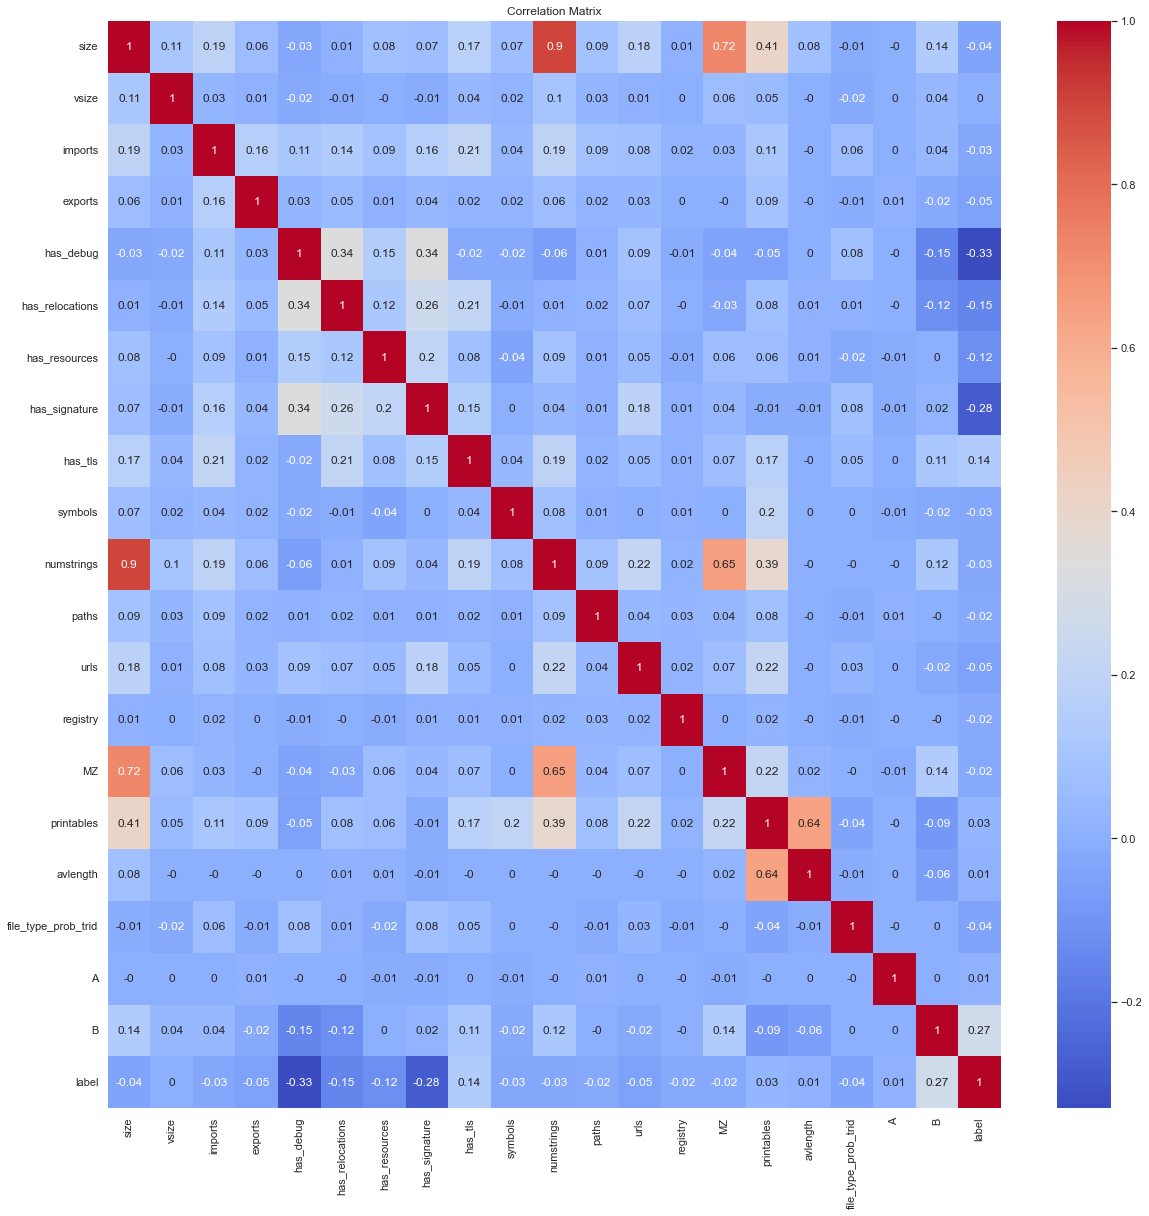

In [133]:
corr_matrix = main_df.corr().round(2)
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title("Correlation Matrix")
plt.show()

__Understanding the correlation table from first glance:__

1. We can see unknown features such as 'A' and 'B' which we can't understand yet why they are correlated with other features since we don't know their business meaning.

2. We can see some correlations that we would expect such as size and printables but also we noticed one that we would like to understand such as "MZ" and 'Size' and their connection


### Plotting the Data:

Lets see how our features distribute, both in their current state and after log10 transformation, this will help us determine features with low variance, normal distributions and maybe even a change in distribution depending on the label. this will help us understand both important / redundant features and help us with the pre processing.

There are 60000 observations


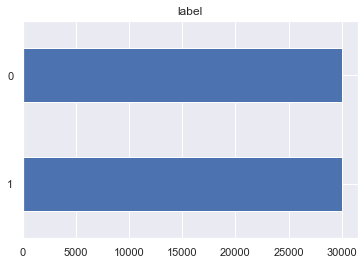

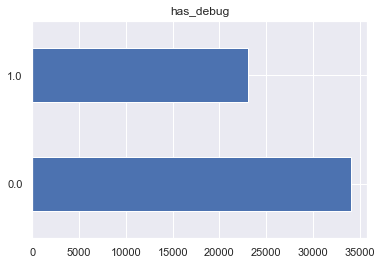

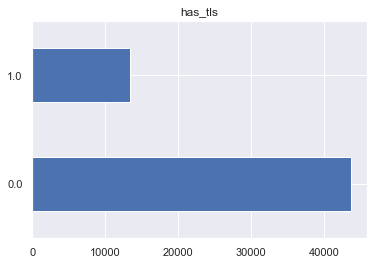

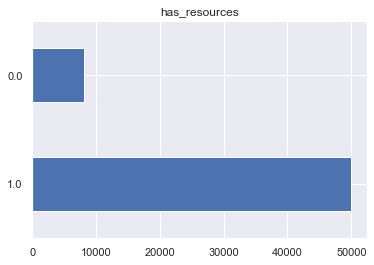

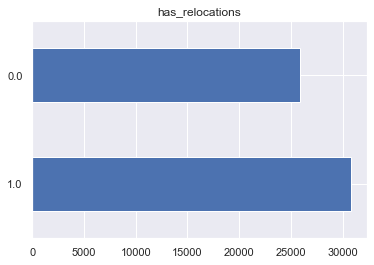

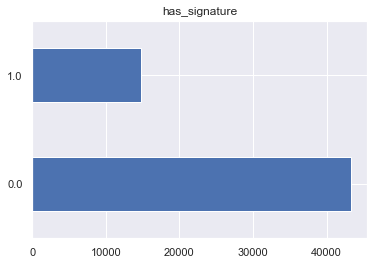

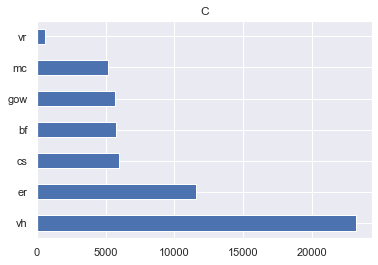

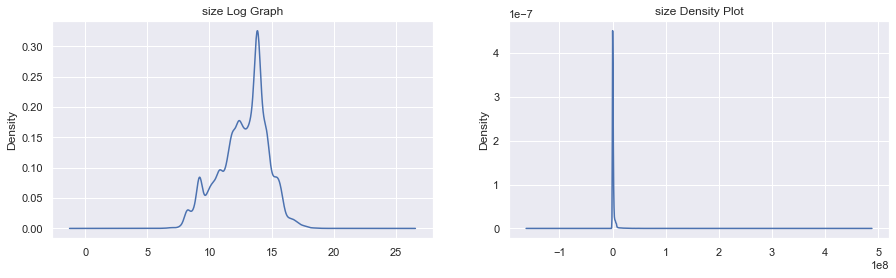

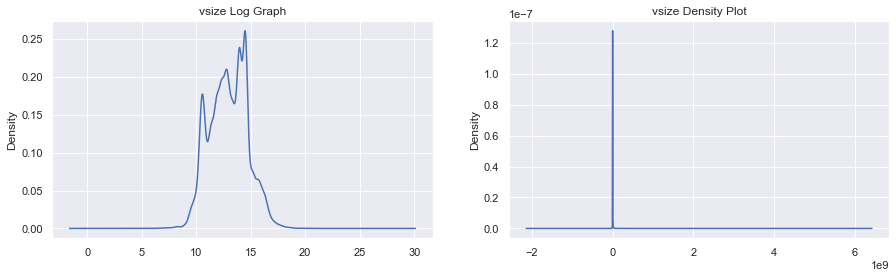

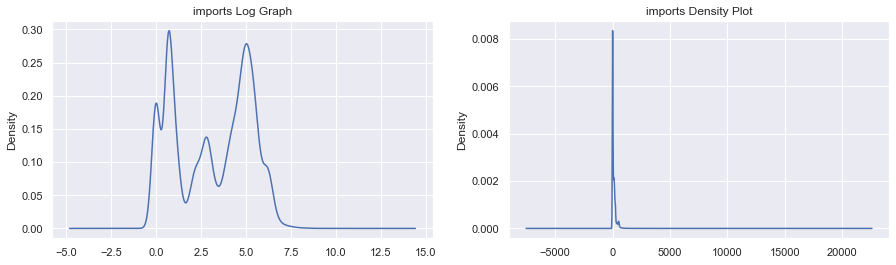

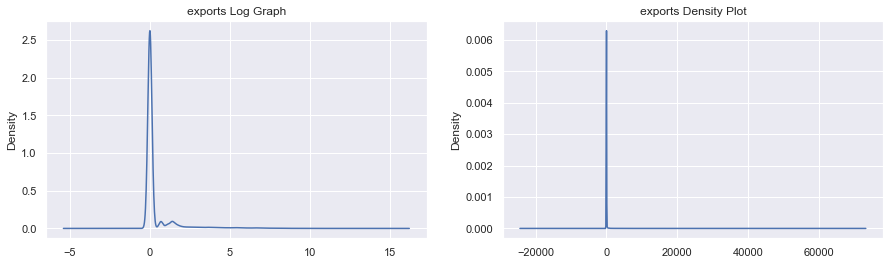

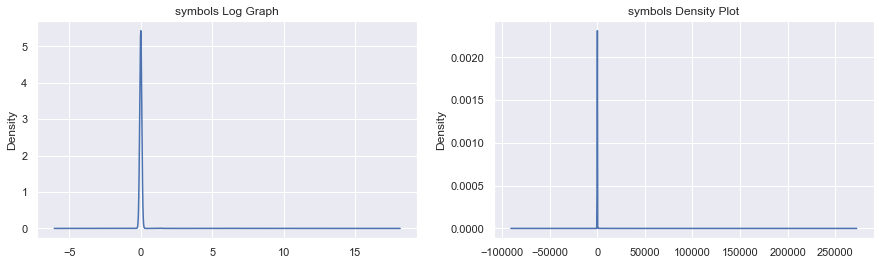

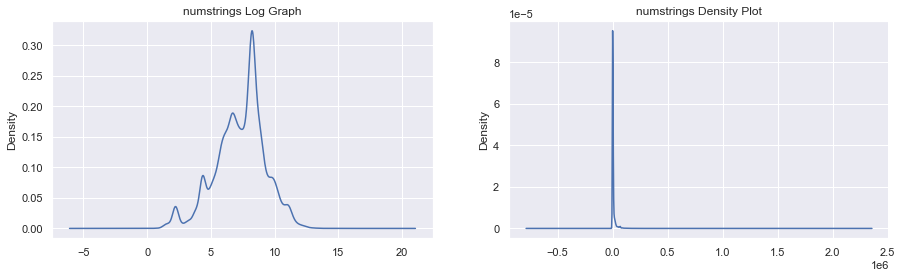

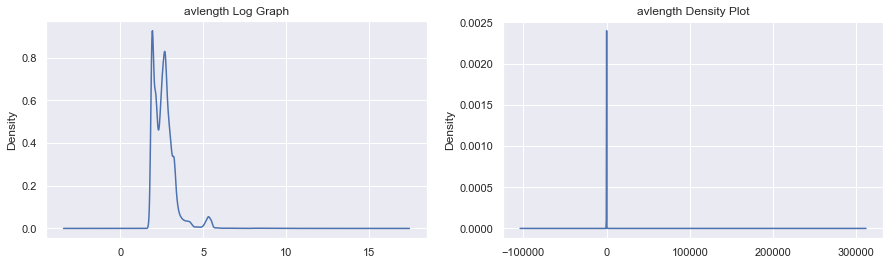

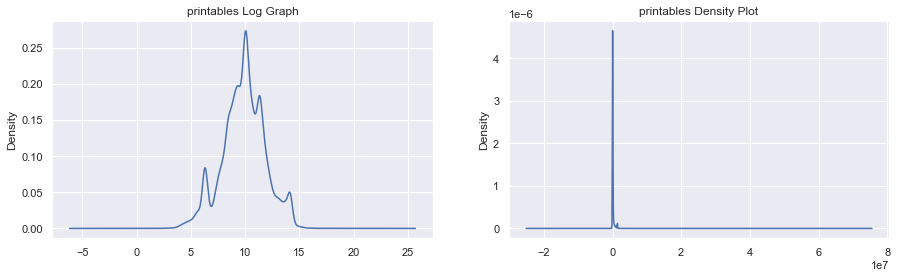

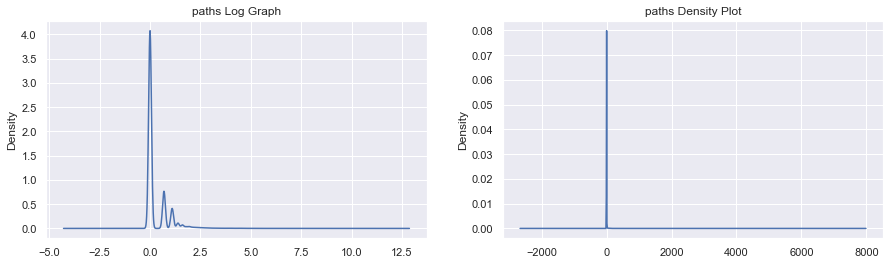

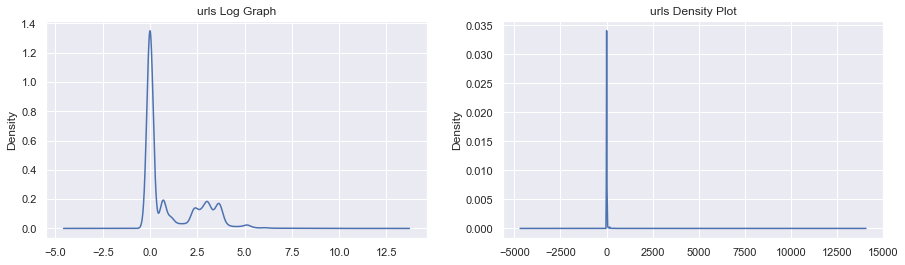

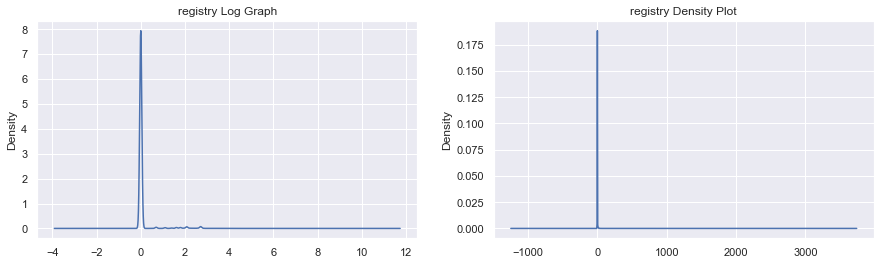

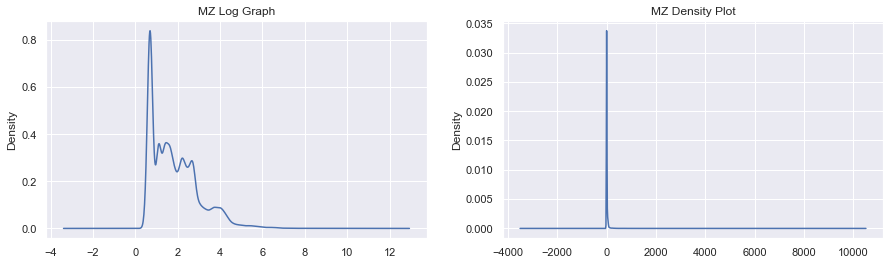

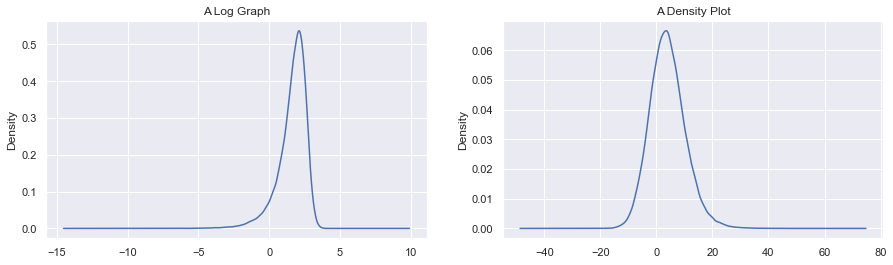

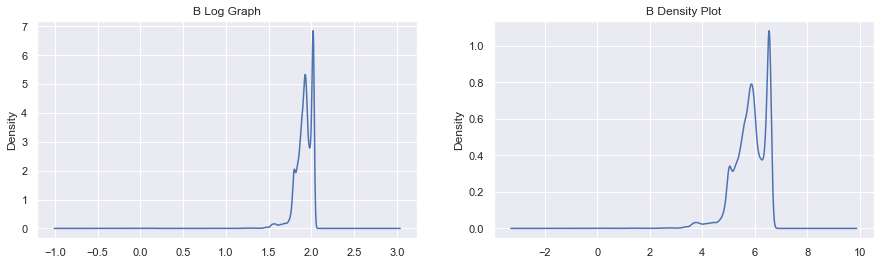

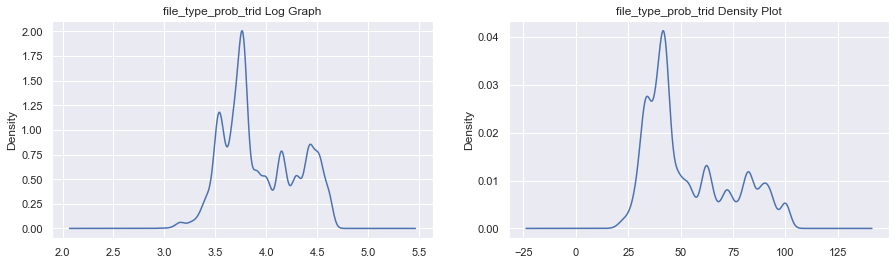

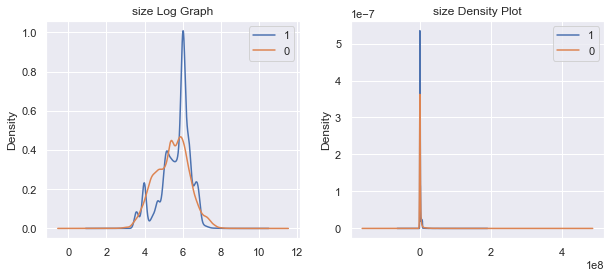

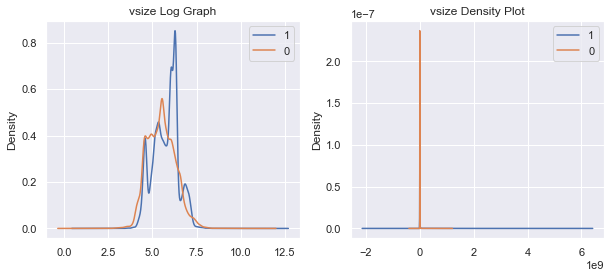

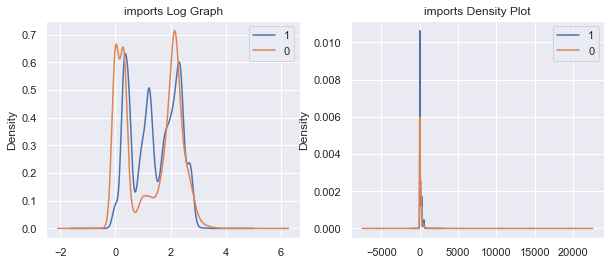

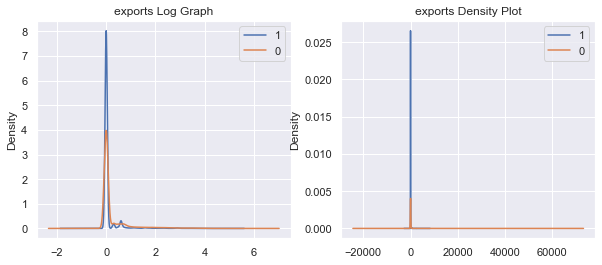

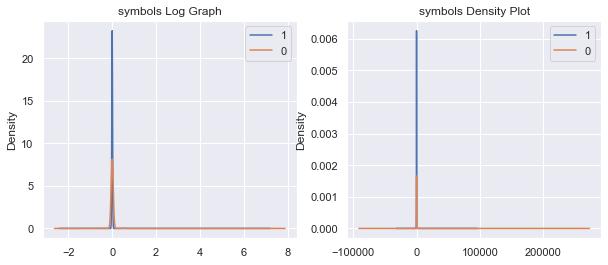

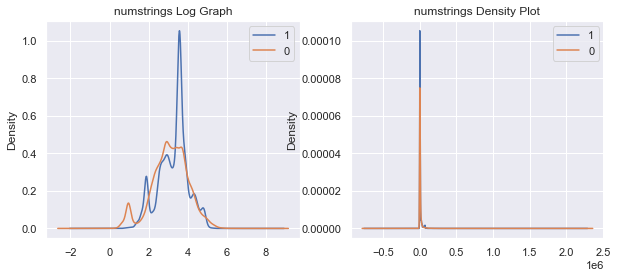

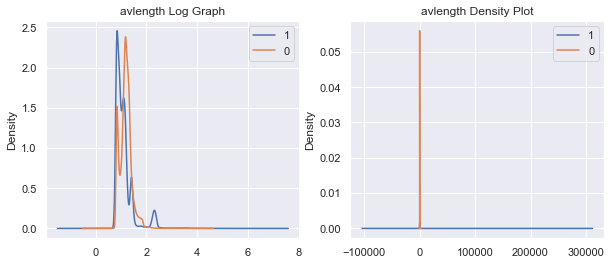

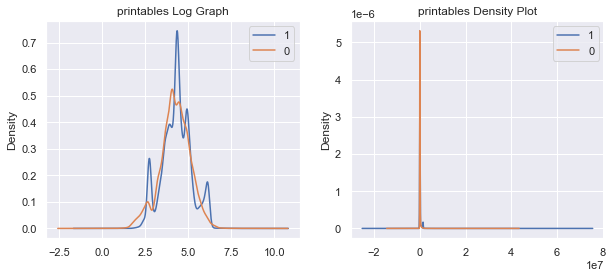

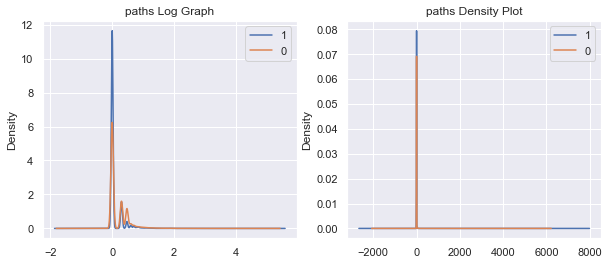

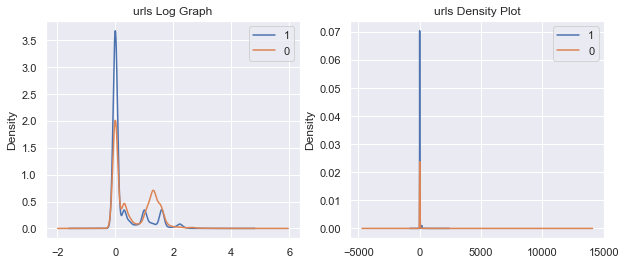

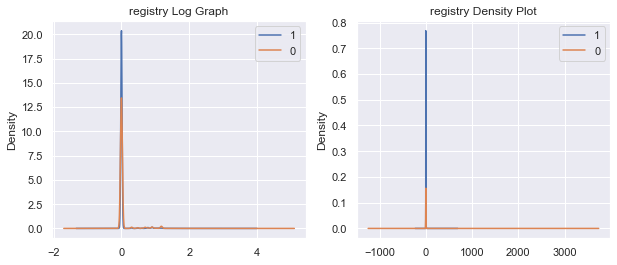

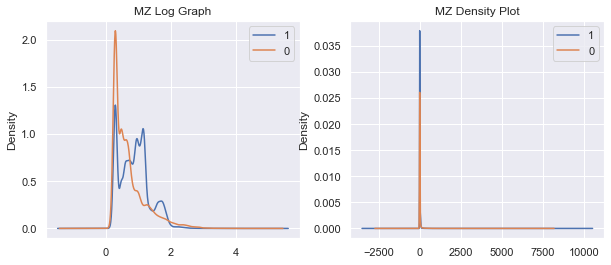

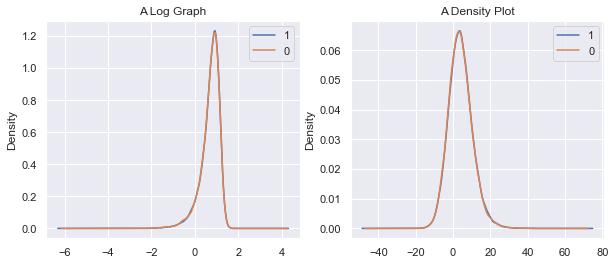

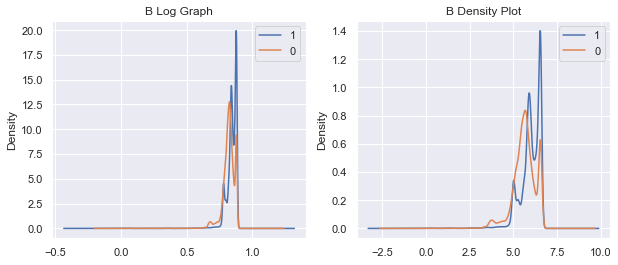

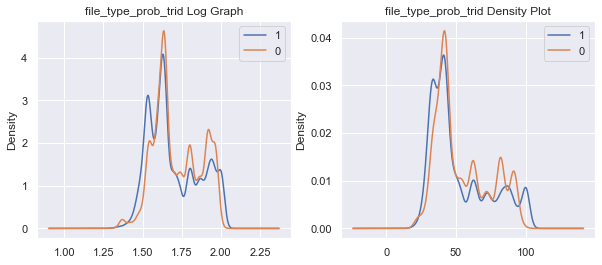

In [134]:
### plotting all the features 

#some basic steps we think are important
num_features = df.shape[1]
num_observations = df.shape[0]
print(f"There are {num_observations} observations")

catagorial = ['label', 'has_debug', 'has_tls', 'has_resources', 'has_relocations', 'has_signature', 'C','file_type_trid']
numerical = ['size', 'vsize', 'imports', 'exports', 'symbols', 'numstrings', 'avlength', 'printables', 'paths', 'urls', 'registry', 'MZ', 'A', 'B', 'file_type_prob_trid']

# Creating a boxplot for each numerical feature
ones = np.ones(main_df.shape[0])
for cat in catagorial:
    if ('type' in cat):
        continue
    main_df[cat].value_counts().plot.barh()
    plt.title(cat)
    plt.show()

# Plotting density plots for numerical features (without considering labels)
for cat in numerical:

    fig, axes = plt.subplots(1, 2, figsize=(15, 4))

    curr = np.log(ones + main_df[cat])
    curr.plot.density( ax=axes[0])

    
    main_df['Log of '+cat] = curr

    main_df[cat].plot.density(ax=axes[1])

    axes[0].set_title(cat + " Log Graph")
    axes[1].set_title(cat + " Density Plot")

    plt.show()

# Plotting density plots for numerical features by labels
for cat in numerical:

    fig, axes = plt.subplots(1, 2, figsize=(10 , 4))

    curr = np.log10(ones + main_df[cat])
    curr[main_df['label'] == 1].plot.density(ax=axes[0], label = '1')
    curr[main_df['label'] == 0].plot.density(ax=axes[0], label= '0')

    main_df['Log of '+cat] = curr

    main_df[main_df['label'] == 1][cat].plot.density(ax=axes[1], label= '1')
    main_df[main_df['label'] == 0][cat].plot.density(ax=axes[1], label= '0')

    axes[0].legend()
    axes[1].legend()
    axes[0].set_title(cat + " Log Graph")
    axes[1].set_title(cat + " Density Plot")

    plt.show()



__features that look normally distributed:__

1. A
2. log of size
3. log of numstrings
4. log of printables

__features that log will increase their variance:__
1. MZ
2. url
3. paths
4. avlength
5. symbols
6. exports
7. imports
8. registry
9. vsize

In [135]:
normally_features = ['A', 'Log of size', 'Log of numstrings', 'Log of printables'] # List to store features that look normally distributed from the plot

In [136]:
# Set the float_format option to display numbers without scientific notation
pd.set_option('display.float_format', lambda x: f'{x:.2f}')
main_df.describe()

size         vsize  imports  exports  has_debug  \
count     60000.00      58065.00 58261.00 57907.00   57073.00   
mean    1501019.14    1965704.26   106.20    30.80       0.40   
std     4727390.68   20178814.65   213.45   508.08       0.49   
min         298.00        544.00     0.00     0.00       0.00   
25%      107008.00     122880.00     1.00     0.00       0.00   
50%      483328.00     421888.00    28.00     0.00       0.00   
75%     1239326.00    1601536.00   152.00     0.00       1.00   
max   325353693.00 4278288384.00 15047.00 48840.00       1.00   

       has_relocations  has_resources  has_signature  has_tls   symbols  \
count         56676.00       58039.00       58063.00 57102.00  57344.00   
mean              0.54           0.86           0.25     0.23     40.17   
std               0.50           0.35           0.44     0.42   1239.70   
min               0.00           0.00           0.00     0.00      0.00   
25%               0.00           1.00           0.00     0.00      0.00   
50%               1.00           1.00           0.00     0.00      0.00   
75%               1.00           1.00           1.00     0.00      0.00   
max               1.00           1.00           1.00     1.00 181660.00   

       numstrings    paths     urls  registry       MZ  printables  avlength  \
count    57282.00 56340.00 57651.00  57475.00 56911.00    57261.00  57243.00   
mean      7404.34     1.64    12.50      0.43    16.26   120771.03     32.66   
std      24630.88    37.00    71.63     11.50    82.19   605220.32   1094.71   
min          1.00     0.00     0.00      0.00     1.00        5.00      5.00   
25%        475.00     0.00     0.00      0.00     1.00     6013.00      7.45   
50%       1990.50     0.00     0.00      0.00     4.00    22835.00     12.01   
75%       5172.00     1.00    10.00      0.00    11.00    76156.00     17.31   
max    1572261.00  5324.00  9387.00   2492.00  7010.00 50346873.00 207990.93   

       file_type_prob_trid        A        B    label  Log of size  \
count             60000.00 56296.00 56249.00 60000.00     60000.00   
mean                 53.68     4.02     5.81     0.50         5.54   
std                  20.63     6.37     0.64     0.50         0.83   
min                  17.50   -17.78     0.00     0.00         2.48   
25%                  38.40    -0.29     5.47     0.00         5.03   
50%                  43.30     3.66     5.86     0.50         5.68   
75%                  69.10     7.86     6.34     1.00         6.09   
max                 100.00    43.93     6.58     1.00         8.51   

       Log of vsize  Log of imports  Log of exports  Log of symbols  \
count      58065.00        58261.00        57907.00        57344.00   
mean           5.63            1.36            0.16            0.03   
std            0.75            0.91            0.50            0.28   
min            2.74            0.00            0.00            0.00   
25%            5.09            0.30            0.00            0.00   
50%            5.63            1.46            0.00            0.00   
75%            6.20            2.18            0.00            0.00   
max            9.63            4.18            4.69            5.26   

       Log of numstrings  Log of avlength  Log of printables  Log of paths  \
count           57282.00         57243.00           57261.00      56340.00   
mean                3.19             1.15               4.29          0.14   
std                 0.84             0.30               0.86          0.27   
min                 0.30             0.78               0.78          0.00   
25%                 2.68             0.93               3.78          0.00   
50%                 3.30             1.11               4.36          0.00   
75%                 3.71             1.26               4.88          0.30   
max                 6.20             5.32               7.70          3.73   

       Log of urls  Log of registry  Log of MZ  Log of A 

__And what about the boolean features?__ 

boolean features = features that have 'has' in their names such as has_debug.

The code iterates over a list of boolean features, calculates the count of label values for each feature value, and plots stacked bar plots showing the count of feature values by label.

<Figure size 432x288 with 0 Axes>

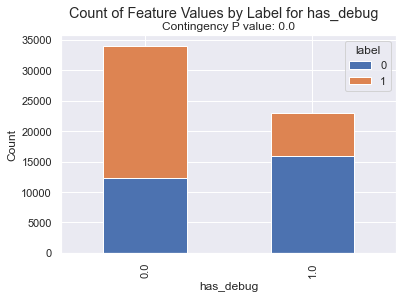

Percentage of label 0 out of total count for has_debug=0: 36.04%
Percentage of label 1 out of total count for has_debug=0: 63.96%
Percentage of label 0 out of total count for has_debug=1: 69.31%
Percentage of label 1 out of total count for has_debug=1: 30.69%


<Figure size 432x288 with 0 Axes>

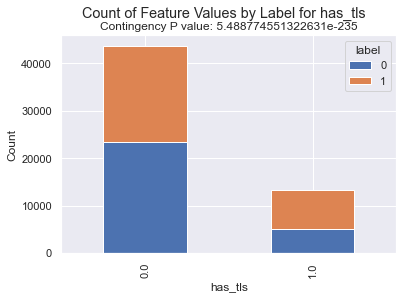

Percentage of label 0 out of total count for has_tls=0: 53.74%
Percentage of label 1 out of total count for has_tls=0: 46.26%
Percentage of label 0 out of total count for has_tls=1: 37.56%
Percentage of label 1 out of total count for has_tls=1: 62.44%


<Figure size 432x288 with 0 Axes>

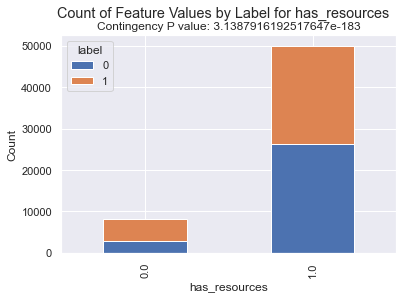

Percentage of label 0 out of total count for has_resources=0: 35.07%
Percentage of label 1 out of total count for has_resources=0: 64.93%
Percentage of label 0 out of total count for has_resources=1: 52.36%
Percentage of label 1 out of total count for has_resources=1: 47.64%


<Figure size 432x288 with 0 Axes>

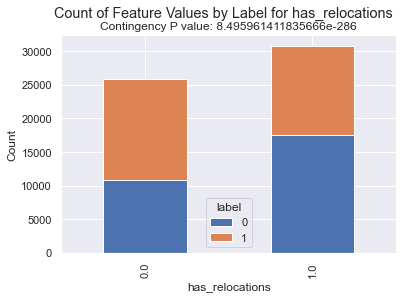

Percentage of label 0 out of total count for has_relocations=0: 41.66%
Percentage of label 1 out of total count for has_relocations=0: 58.34%
Percentage of label 0 out of total count for has_relocations=1: 56.89%
Percentage of label 1 out of total count for has_relocations=1: 43.11%


<Figure size 432x288 with 0 Axes>

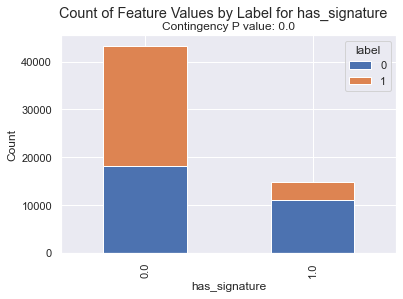

Percentage of label 0 out of total count for has_signature=0: 41.78%
Percentage of label 1 out of total count for has_signature=0: 58.22%
Percentage of label 0 out of total count for has_signature=1: 74.22%
Percentage of label 1 out of total count for has_signature=1: 25.78%


In [137]:
#let try to see the has features ('has_debug', 'has_tls', 'has_resources', 'has_relocations', 'has_signature') and label on a plot

bool_features = ['has_debug', 'has_tls', 'has_resources', 'has_relocations', 'has_signature']

# Iterate over boolean features
for has in bool_features:
    # Group by feature value and calculate count for each label value
    group_by_feature = main_df.groupby([has, 'label']).size().unstack()
    contingency_table = pd.crosstab(main_df[has], main_df['label'])
    chi2, pvalue, _, _ = chi2_contingency(contingency_table)

    # Plot bar plot
    plt.figure()
    group_by_feature.plot(kind='bar', stacked=True)
    plt.xlabel(has)
    plt.ylabel('Count')
    plt.suptitle(f'Count of Feature Values by Label for {has}')
    plt.title(f'Contingency P value: {pvalue}')
    plt.show()

    # Calculate percentage of labels 0 and 1
    total_counts = group_by_feature.sum(axis=1)
    percentage_0 = group_by_feature.loc[0, 0] / total_counts[0] * 100
    percentage_1 = group_by_feature.loc[1, 1] / total_counts[1] * 100
    
    # Print percentage values
    print(f"Percentage of label 0 out of total count for {has}=0: {percentage_0:.2f}%")
    print(f"Percentage of label 1 out of total count for {has}=0: {100 - percentage_0:.2f}%")
    print(f"Percentage of label 0 out of total count for {has}=1: {100 - percentage_1:.2f}%")
    print(f"Percentage of label 1 out of total count for {has}=1: {percentage_1:.2f}%")
    
    

And are there certain __interactions__ between the boolean features that correlate with the label?

Adding interactions between boolean features improves the model's ability to capture complex relationships, enhance predictive power, provide additional information, and model non-linear relationships.

has_tls     0.00  1.00
has_debug             
0.00        9514  2165
1.00       12657  2531


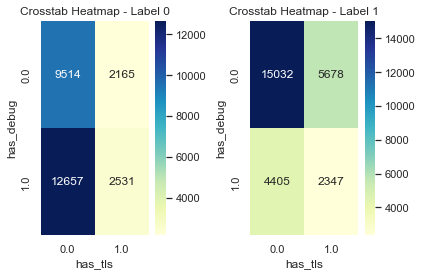

has_resources  0.00   1.00
has_debug                 
0.00           1861   9995
1.00            817  14596


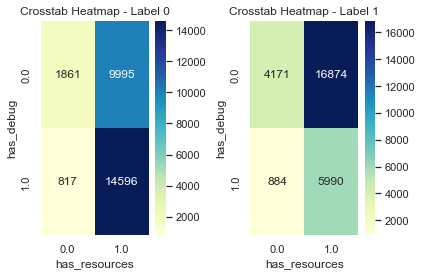

has_relocations  0.00   1.00
has_debug                   
0.00             6067   5532
1.00             4076  10967


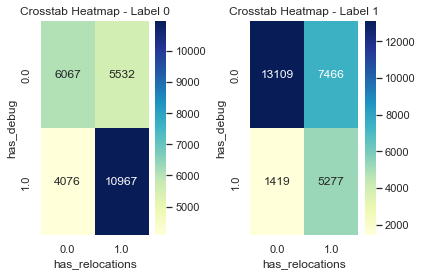

has_signature  0.00  1.00
has_debug                
0.00           8710  3167
1.00           8308  7152


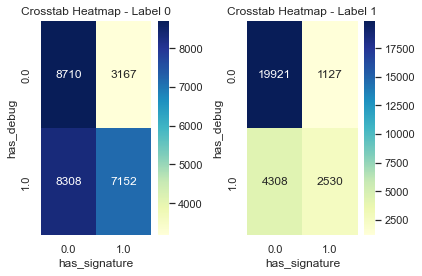

has_resources  0.00   1.00
has_tls                   
0.00           2364  20336
1.00            343   4521


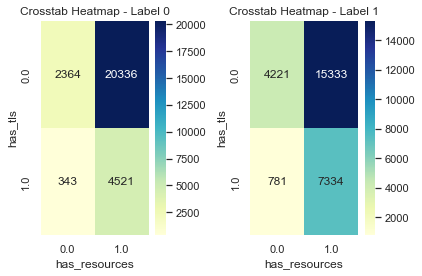

has_relocations  0.00   1.00
has_tls                     
0.00             9022  13139
1.00             1271   3466


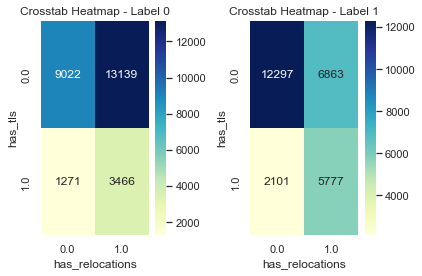

has_signature   0.00  1.00
has_tls                   
0.00           14947  7799
1.00            2264  2604


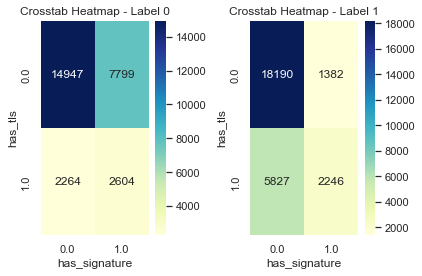

has_relocations  0.00   1.00
has_resources               
0.00             1670   1002
1.00             8738  15930


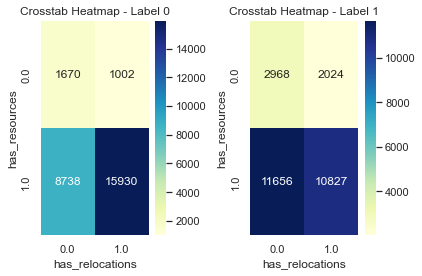

has_signature   0.00   1.00
has_resources              
0.00            2497    266
1.00           14968  10333


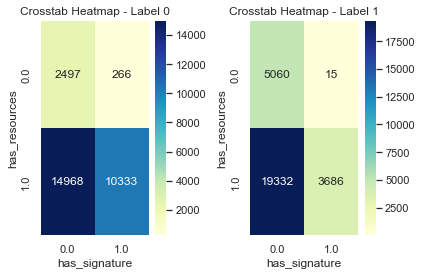

has_signature    0.00  1.00
has_relocations            
0.00             8187  2273
1.00             8904  8055


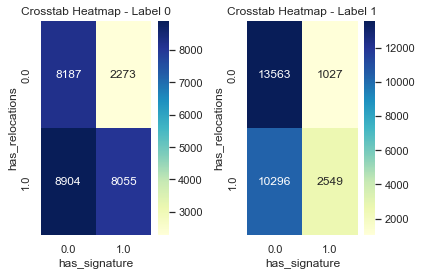

In [138]:
# we will check the interactions for non malicious and malicious files

non_mal = main_df[main_df['label']==0]

mal = main_df[main_df['label']==1]

for i in range(len(bool_features)-1):
    for j in range(i+1, len(bool_features)):
        nmfeat1 = non_mal[bool_features[i]]
        nmfeat2 = non_mal[bool_features[j]]
        nm_ct = pd.crosstab(nmfeat1, nmfeat2)
        mfeat1 = mal[bool_features[i]]
        mfeat2 = mal[bool_features[j]]
        m_ct = pd.crosstab(mfeat1, mfeat2)

        print(nm_ct)
        
        # Plot the first heatmap for Label 0
        plt.subplot(1, 2, 1)
        sns.heatmap(nm_ct, annot=True, fmt='d', cmap='YlGnBu')
        plt.xlabel(bool_features[j])
        plt.ylabel(bool_features[i])
        plt.title('Crosstab Heatmap - Label 0')

        # Plot the second heatmap for Label 1
        plt.subplot(1, 2, 2)
        sns.heatmap(m_ct, annot=True, fmt='d', cmap='YlGnBu')
        plt.xlabel(bool_features[j])
        plt.ylabel(bool_features[i])
        plt.title('Crosstab Heatmap - Label 1')

        # Adjust the layout and display the plot
        plt.tight_layout()
        plt.show()

__So what can we learn?__

we can see that features have special interactions between them! for example having has_debug and has_relocations 0 is far more likely in malwares than in non malware.

why would we like interacions?
because saying relocations is 0  and debug 0 having 2 seperate effects rather than having a combined effect would make our models "miss" certain interactions

having these interactions means that just using 2 seperate features would be wrong and lead to extra bias in our model, and thus we need to add more features for the interactions

__What can we tell from our visualizations:__

1. half of our data our malicious files and half are not. Which means have 30000 with label = 1 and 30000 with label = 0 (overall 60000 observations). But for certain features there are observations with missing value.
2. We have boolean features! such as has_debug, has_tls, has_resources, has_relocations, has_signiture with the values 0 or 1. Note: we can see most of of the files have resources.
3. we have 2 categorial features, file_type_trid and and C (we don't now what C is but lets see if it helps at all)
NOTE: we can see that "C" doesn't have much values, we could use it as a dummy variable, however, for file_type_trid (which will be plotted later), that has many values, we can't, we will see later how can use it.

4. we can see many continuous featuress distributions are easier to understand by adding the log, some distribute normally after adding the log, some are normally distributed such as size, numstrings and printables. the other features are affected by having greater variance after adding the log.
NOTE: this excludes features such as A and B that don't need the log, A already is normally distributed and B's variance is not affected by the log.

5. In addition to the understanding of the distributions, we visualize differences between malicious and non malicious files via the density plot. for certain features such as MZ and B are affected by the label (with opposite effects, one shifts to the right and the other to the left in the distribution according only to the visualizations)

6. Looking at the boolean features we can see a contingency between the has features with the labels, this means that those features are relevant!


* Now we will be using the log of the continious features (where it helps) in order to see further connections

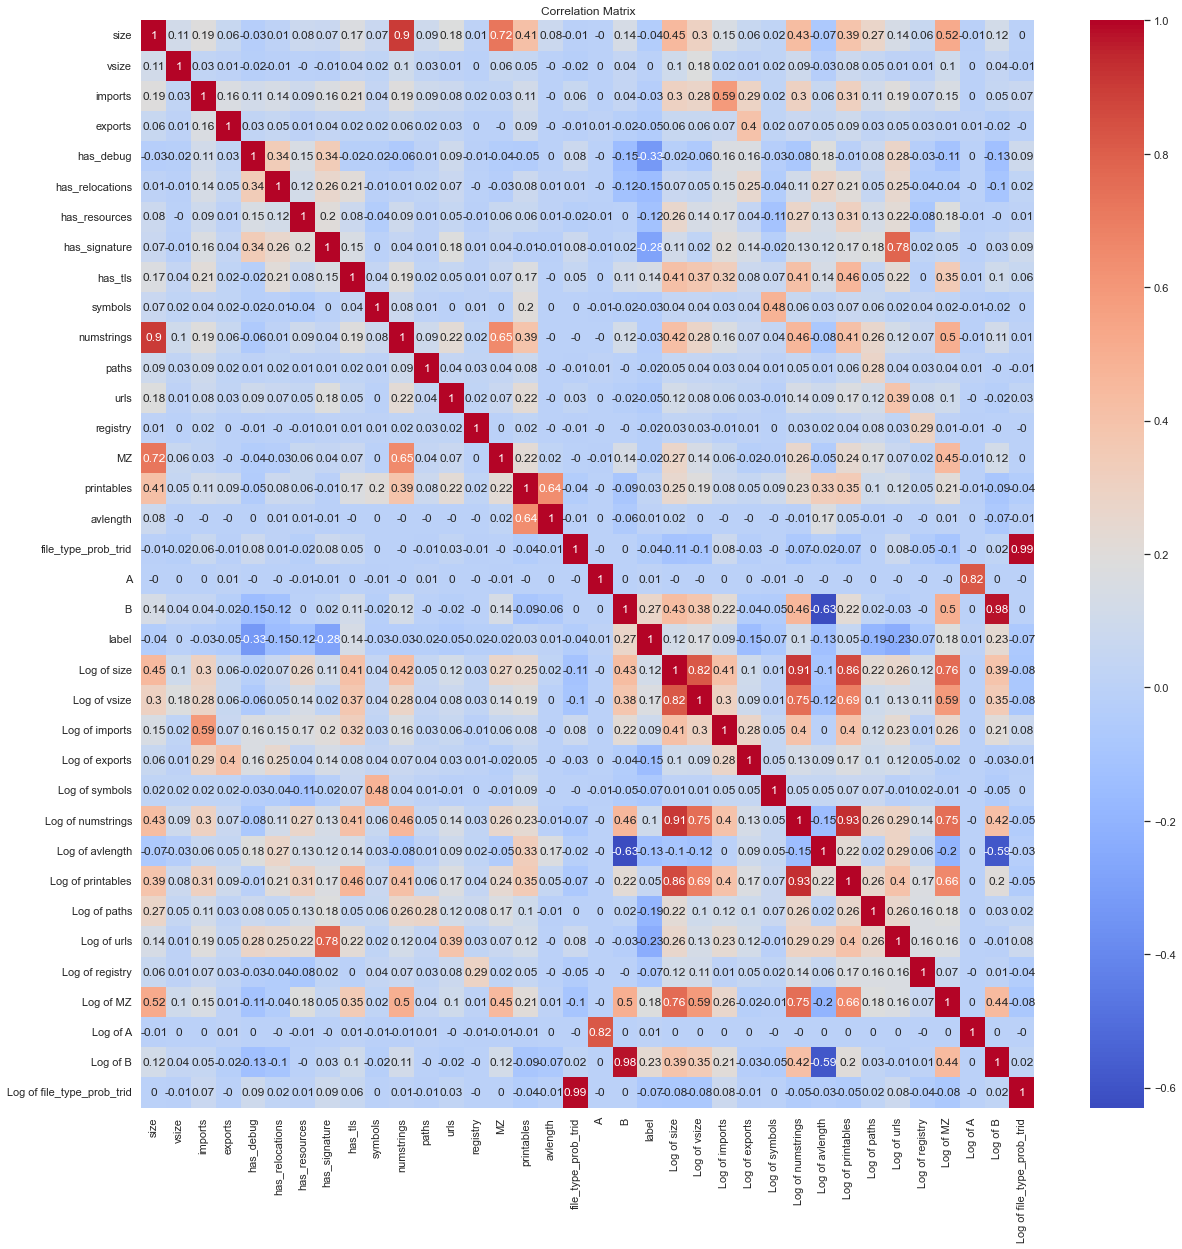

In [139]:
#list of all the features we will do log transformation in the future
to_log = ['size', 'numstrings', 'printables', 'MZ', 'urls', 'paths', 'avlength', 'symbols', 'exports', 'imports', 'registry', 'vsize']

corr_matrix = main_df.corr().round(2)
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title("Correlation Matrix")
plt.show()

Above we see the correlation matrix with __ALL__ of the features (including their log features). we see certain connections that don't surprise us at all, (feature and its log) however we see new correlations overall, seeing the bottom right corner of the correlation matrix, we see more correlations not between 2 features but their log values.

### Understanding some of the features we thought might be interesting

We will do some __visualizaitons and conclunsions__ on the training data regarding some features.


__MZ and Size features:__

Let's take a closer look at the "MZ" feature because it strongly correlates with the file size, and we want to understand its meaning. On the other hand, the "numstring" feature is also correlated with size, which makes sense since larger files often have more strings.

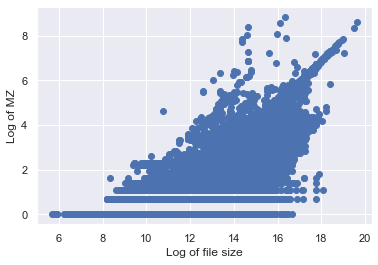

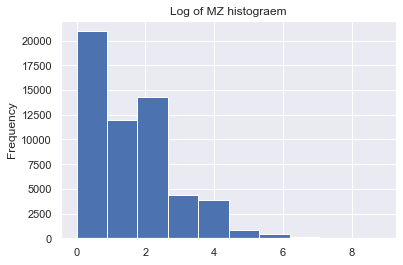

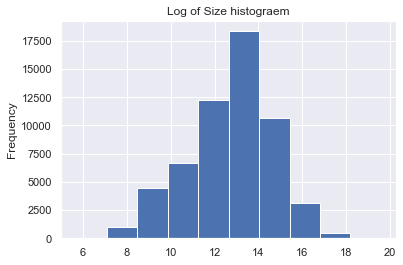

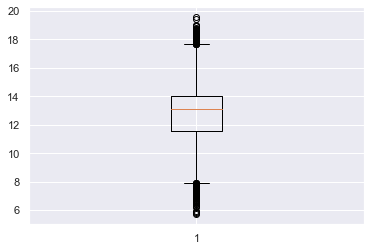

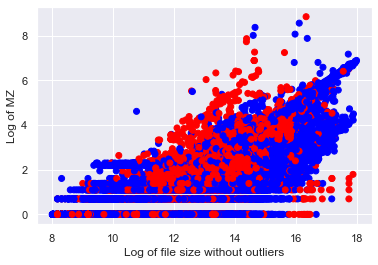

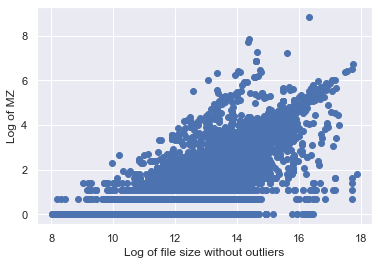

In [140]:
# selects the MZ and size columns from main_df based on a condition where MZ values are greater than 0 
mz = main_df[main_df["MZ"] > 0]["MZ"]
size = main_df[main_df["MZ"] > 0]["size"]

logSize = np.log(size)
logMZ = np.log(mz)
plt.scatter(logSize, logMZ)
plt.xlabel("Log of file size")
plt.ylabel('Log of MZ')
plt.show()
plt.title("Log of MZ histograem")
logMZ.plot.hist()
plt.show()
plt.title("Log of Size histograem")
logSize.plot.hist()
plt.show()
plt.boxplot(logSize)
plt.show()

logSize_no_out = logSize[(logSize < 18) & (logSize > 8)]
MZ_no_out = main_df[(main_df["MZ"] > 0) & ((logSize < 18) & (logSize > 8))]["MZ"]
labels = main_df[(main_df["MZ"] > 0) & ((logSize < 18) & (logSize > 8))]['label']
label_colors = {1: 'red', 0: 'blue'}
plt.scatter(logSize_no_out, np.log(MZ_no_out), c=[label_colors[label] for label in labels])
plt.xlabel("Log of file size without outliers")
plt.ylabel('Log of MZ')
plt.show()
logSize_mal = logSize_no_out[(labels==1)]
mz_mal = MZ_no_out[(labels==1)]
plt.scatter(logSize_mal, np.log(mz_mal))
plt.xlabel("Log of file size without outliers")
plt.ylabel('Log of MZ')
plt.show()

__Understanding MZ and Size (from the output above):__

While exploring the connection between size and MZ we noticed two things:

1. the connection between the log of each feature seem to correlate relatively in a linear way.
2. the data we explore is in very large numbers! what can it mean? it means that we might want to work not with the standard features themselves but with the log of base 10. The next steps will be transforming the data and understanding how transformations change the distributions of each feature.

__Symbols feature:__

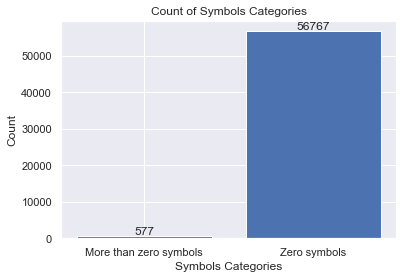

In [141]:
more_than_zero_symbols = len(main_df[main_df['symbols'] > 0])
zero_symbols = len(main_df[main_df['symbols'] == 0])

symbols_categories = ['More than zero symbols', 'Zero symbols']
symbols_counts = [more_than_zero_symbols, zero_symbols]

plt.bar(symbols_categories, symbols_counts)
plt.xlabel('Symbols Categories')
plt.ylabel('Count')
plt.title('Count of Symbols Categories')

# Add numbers on top of each bar
for i, count in enumerate(symbols_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
    
plt.show()

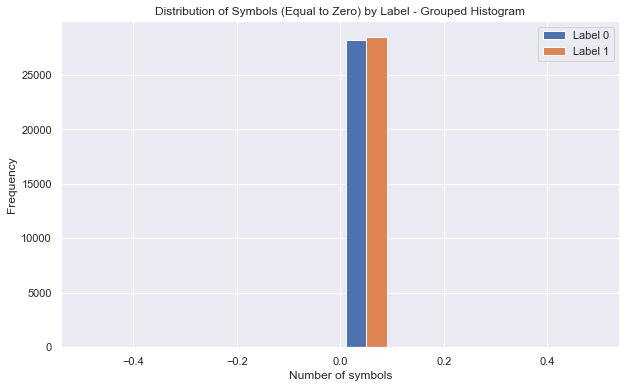

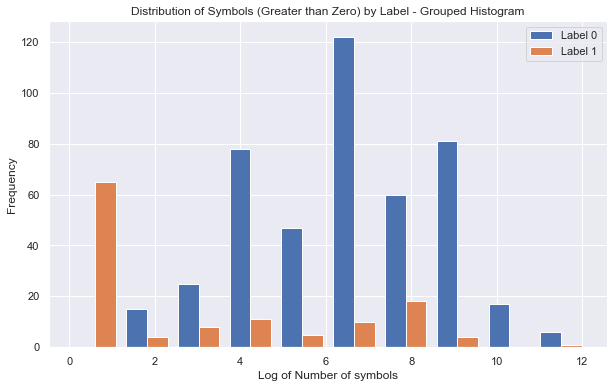

In [142]:
# Grouped Histogram: Zero Symbols by Label
zero_symbols_label_0 = main_df[(main_df['symbols'] == 0) & (main_df['label'] == 0)]['symbols']
zero_symbols_label_1 = main_df[(main_df['symbols'] == 0) & (main_df['label'] == 1)]['symbols']

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist([zero_symbols_label_0, zero_symbols_label_1], bins=10, label=['Label 0', 'Label 1'])
plt.xlabel('Number of symbols')
plt.ylabel('Frequency')
plt.title('Distribution of Symbols (Equal to Zero) by Label - Grouped Histogram')
plt.legend()
plt.show()

# Grouped Histogram: Symbols Greater than Zero by Label
bigger_zero_symbols_label_0 = main_df[(main_df['symbols'] > 0) & (main_df['label'] == 0)]['symbols']
bigger_zero_symbols_label_1 = main_df[(main_df['symbols'] > 0) & (main_df['label'] == 1)]['symbols']

# Applying logarithm to the data
bigger_zero_symbols_label_0_log = np.log(bigger_zero_symbols_label_0)
bigger_zero_symbols_label_1_log = np.log(bigger_zero_symbols_label_1)

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist([bigger_zero_symbols_label_0_log, bigger_zero_symbols_label_1_log], bins=10, label=['Label 0', 'Label 1'])
plt.xlabel('Log of Number of symbols')
plt.ylabel('Frequency')
plt.title('Distribution of Symbols (Greater than Zero) by Label - Grouped Histogram')
plt.legend()
plt.show()



__Conclusions:__<br>
The vast majority of our data, has 0 symbols in the file, and barely has any effect on the labels of our data because we see it's half and half. (according the bar plot). We do see once we go to files with more than 0 symbols a certain dependency of the label, however the change is extremly negligable.

__Registry feature:__

this code helps visualize and provide insights into the distribution of label values within the 'registry' category, specifically when 'registry' is 0. Additionally, it presents the corresponding count values for label 1 and label 0 in this particular scenario.

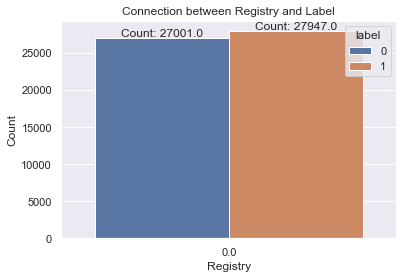

Number of Labels that are 1 with registry 0: 27947
Number of Labels that are 0 with registry 0: 27001


In [143]:
df_registry_0 = main_df[main_df['registry']==0]

# Create a count plot
ax = sns.countplot(data=df_registry_0, x='registry', hue='label')

# Get the counts
label_1_registry_0 = len(df_registry_0[df_registry_0['label'] == 1])
label_0_registry_0 = len(df_registry_0[df_registry_0['label'] == 0])

# Annotate the bars with count values
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f"Count: {p.get_height()}", (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha='center', va='bottom')

# Set labels and title
plt.xlabel('Registry')
plt.ylabel('Count')
plt.title('Connection between Registry and Label')

# Display the plot
plt.show()

# Print the counts
print(f"Number of Labels that are 1 with registry 0: {label_1_registry_0}")
print(f"Number of Labels that are 0 with registry 0: {label_0_registry_0}")

It is difficult to understand the effect of the registry when it is 0 since the results for malicious files versus non-malicious files are almost half and half.

__C feature:__

Lets understand the meaning of 'C', since those are terms that we don't know or understand, so lets try to see if can understand their meaning at all:

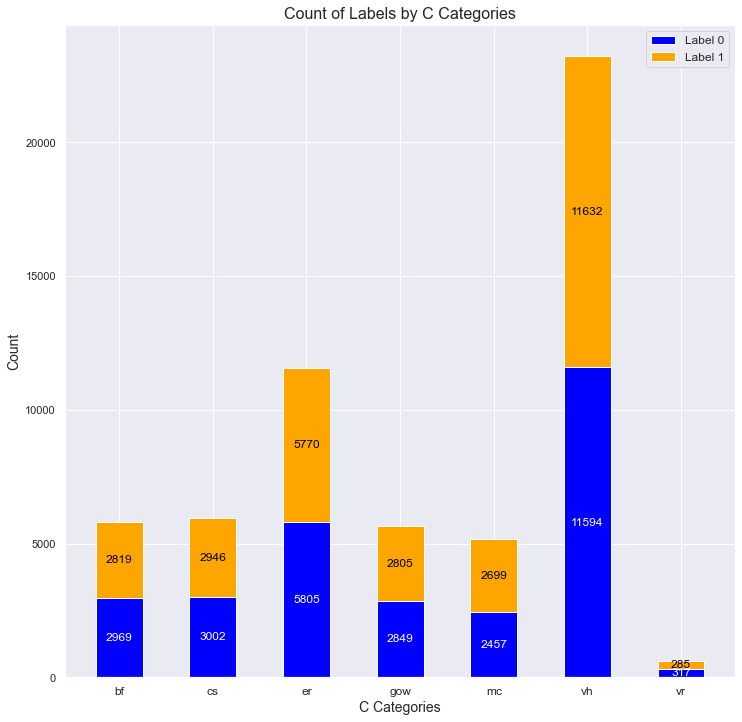

In [144]:
#comparing the distribution of safe and malicious files across different categories ('C'). 
grouped_data = main_df.groupby(['C', 'label']).size().unstack()
plt.figure(figsize=(12, 12))
colors = ['blue', 'orange']
num_categories = len(grouped_data)
bar_width = 0.5
bar_positions = np.arange(num_categories)
plt.bar(bar_positions, grouped_data[0], color=colors[0], width=bar_width, label='Label 0')
plt.bar(bar_positions, grouped_data[1], color=colors[1], width=bar_width, bottom=grouped_data[0], label='Label 1')
plt.xticks(bar_positions, grouped_data.index)
plt.xticks(bar_positions, grouped_data.index, fontsize=12)
plt.xlabel('C Categories', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Count of Labels by C Categories', fontsize=16)
plt.legend(fontsize=12)

# Increase the gap between count numbers
label_0_offset = 0.15
label_1_offset = 0.3

# Add numbers for label 0
for i in range(num_categories):
    plt.text(bar_positions[i], grouped_data.iloc[i, 0] / 2, f'{grouped_data.iloc[i, 0]}', ha='center', va='center', color='white')

# Add numbers for label 1
for i in range(num_categories):
    plt.text(bar_positions[i], grouped_data.iloc[i, 0] + grouped_data.iloc[i, 1] / 2, f'{grouped_data.iloc[i, 1]}', ha='center', va='center', color='black')

plt.show()

We can understand that C values distribute in a 50-50 manner (not including null values)



__File_type and file_type_prob_trid features:__

Lets understand as well the file type catagories and the amount for each catagory:

__NOTE:__ for the plot we will use the log values of the counts, just to avoid a graph that has a few large bars and the rest are not noticeable.

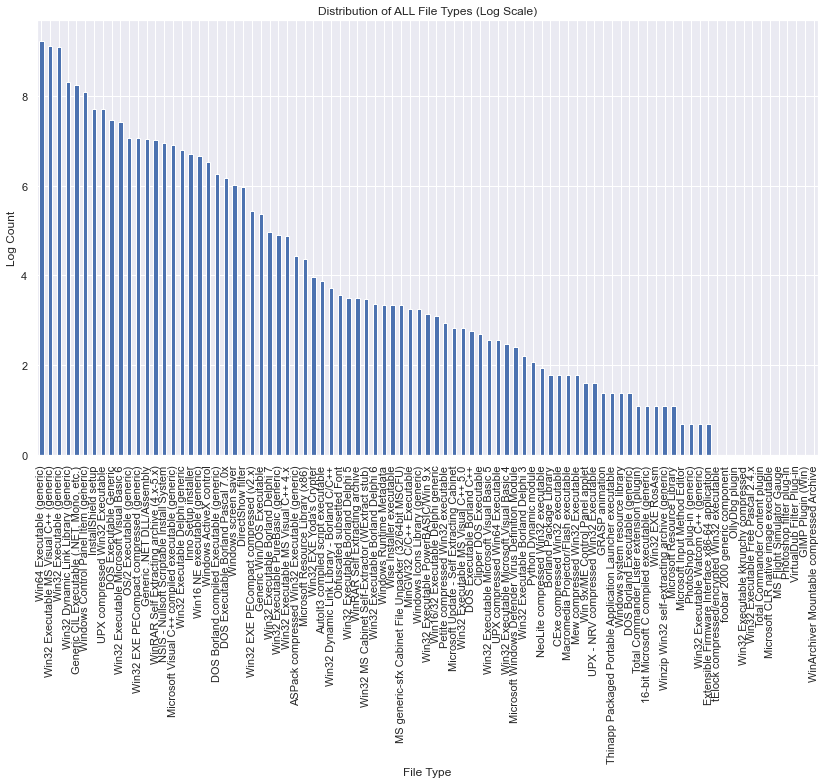

In [145]:
file_type_counts = main_df['file_type_trid'].value_counts()
log_counts = np.log(file_type_counts)

# Plot the bar chart with log-transformed counts
plt.figure(figsize=(14, 8))
log_counts.plot(kind='bar')
plt.xlabel('File Type')
plt.ylabel('Log Count')
plt.title('Distribution of ALL File Types (Log Scale)')
plt.xticks(rotation=90)
plt.show()

We can tell that there are lot a file types, meaning we can't really turn them into dummy values during pre-processing. However we can see that there are many recurring words such as Win32, generic, compressed and more. We can't really work with strings however we can try to convert them into multiple numerical features during pre-processing.

Lets see the most common words in the file types not including "win" or "exe" since our entire data is portable executables so we won't be surprised at all if they are common:

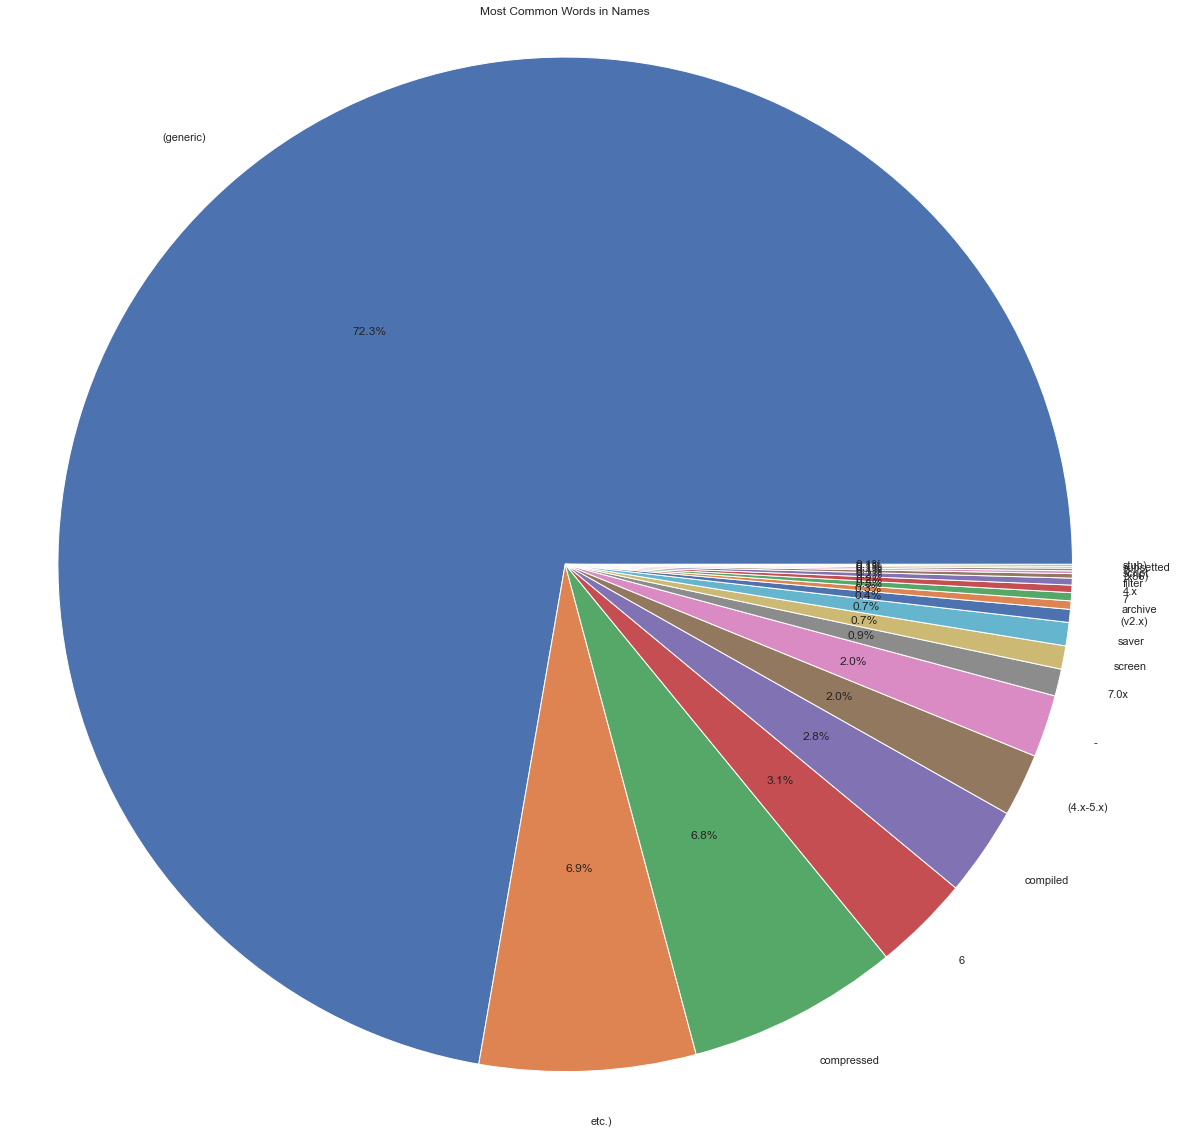

In [146]:
all_names = ' '.join(main_df['file_type_trid'].astype(str))
# Split the string into individual words
words = all_names.split()

# Create a dictionary to store word frequencies
word_counts = {}
 
# Count the frequency of each word
for word in words:
    #check if redundant
    if word in word_counts:
        word_counts[word.lower()] += 1
    else:
        word_counts[word.lower()] = 1
   

# Sort the word frequencies in descending order
sorted_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Get the most common words and their counts
most_common_words = sorted_counts[:20]  # Adjust the number (5 in this case) as desired
# Extract the labels and counts from the most common words
labels = [word[0] for word in most_common_words]
counts = [word[1] for word in most_common_words]

# Plot the pie chart
plt.figure(figsize=(20, 20))
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title('Most Common Words in Names')
plt.axis('equal')
plt.show()

In the pie chart above, we can see that the main 'mass' of the words is generic, etc and compressed, however can we look into less common words that correspond with the label? (hint about pro-processing)

In this code, we group the data by "file_type_trid" and calculate the mean probability ("file_type_prob_trid") for each file type. 
Then, we create a bar plot where each bar represents a file type, and the height of each bar corresponds to the mean probability of that file type.


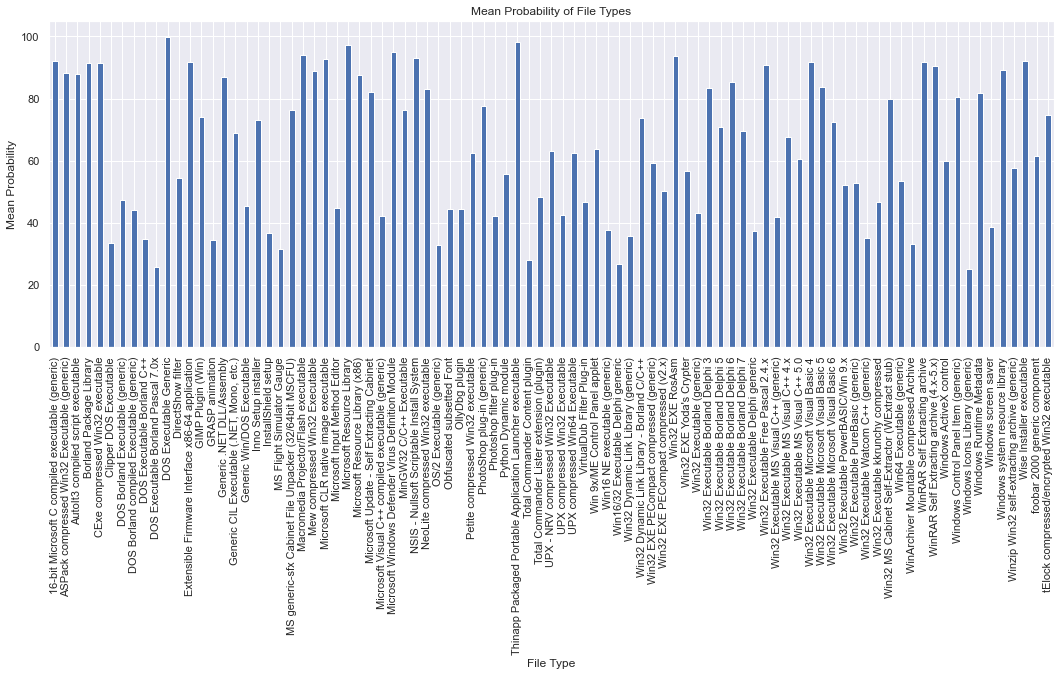

In [147]:
# Group the data by file_type_trid and calculate the mean probability for each file type
file_type_prob_means = main_df.groupby('file_type_trid')['file_type_prob_trid'].mean()

# Plot the bar chart
plt.figure(figsize=(18, 6))
file_type_prob_means.plot(kind='bar')
plt.xlabel('File Type')
plt.ylabel('Mean Probability')
plt.title('Mean Probability of File Types')
plt.xticks(rotation=90)
plt.show()

__What can we understand?__<br>
that there are certain file types that we can be more sure of and some that with a low probability that they are true.<br>
But how does the label affect them?

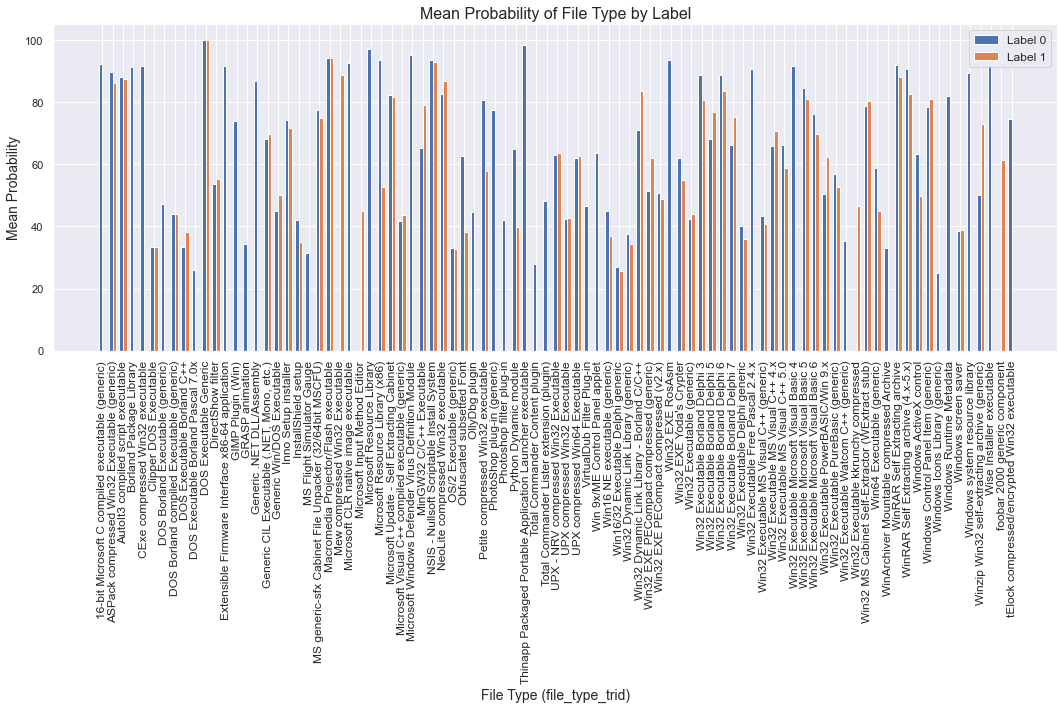

In [148]:
# Group the data by file_type_trid and label, and calculate the mean probabilities
grouped_data = main_df.groupby(['file_type_trid', 'label'])['file_type_prob_trid'].mean().unstack()
grouped_data.head()
# Plotting the grouped bar chart
plt.figure(figsize=(18, 6))
bar_width = 0.35
bar_positions = np.arange(len(grouped_data))

# Plot bars for label 0
plt.bar(bar_positions - bar_width/2, grouped_data[0], width=bar_width, label='Label 0')

# Plot bars for label 1
plt.bar(bar_positions + bar_width/2, grouped_data[1], width=bar_width, label='Label 1')

plt.xlabel('File Type (file_type_trid)', fontsize=14)
plt.ylabel('Mean Probability', fontsize=14)
plt.title('Mean Probability of File Type by Label', fontsize=16)
plt.xticks(bar_positions, grouped_data.index, rotation=90, fontsize=12)
plt.legend(fontsize=12)

plt.show()

__Does the label have an effect on the file type probability?__

For certain file types we see that aren't affected at all, however there are exceptions to this as there are certain files that aren't appearing as viruses at all and certain ones that are only viruses.

We can also look at the top 5 file types with the highest probability of being a virues and see if there is a connection of the file type probability and the 'virus-rate' of the file.

We thought about finding a connection between the low or high file type proba to being a malicious file.
Low probability can indicate that the file type is incorrect and can maybe indicate the file being a virus. Or maybe it's the other way around, a higher probability can indicate that this file type is suspicious and probably is a virus.


Top 5 Files with the Highest Label 1 Percentages:
file_type_trid
Mew compressed Win32 Executable                  100.00
Microsoft Input Method Editor                    100.00
Win32 Executable kkrunchy compressed             100.00
foobar 2000 generic component                    100.00
Winzip Win32 self-extracting archive (generic)    59.24
dtype: float64

Average Probabilities for the Top 5 Files:
file_type_trid
Mew compressed Win32 Executable                  88.80
Microsoft Input Method Editor                    44.90
Win32 Executable kkrunchy compressed             46.70
foobar 2000 generic component                    61.50
Winzip Win32 self-extracting archive (generic)   72.90
Name: 1, dtype: float64


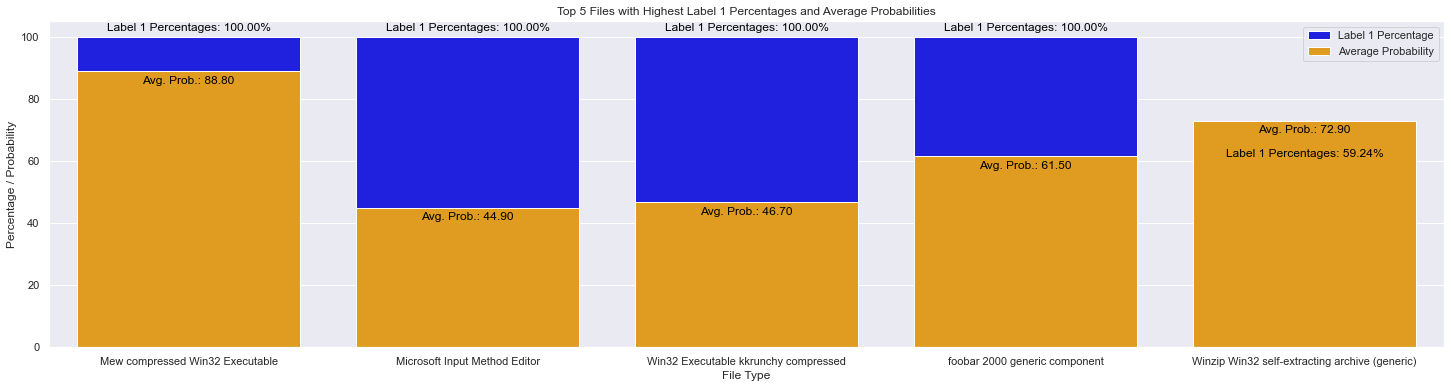

In [149]:
# Group the data by file_type_trid and label, and calculate the mean probabilities
grouped_data = main_df.groupby(['file_type_trid', 'label'])['file_type_prob_trid'].mean().unstack().fillna(0)

# Calculate the percentage of label 1 for each file type
total_counts = grouped_data.sum(axis=1)
label1_percent = grouped_data[1] / total_counts * 100

# Find the top 5 files with the highest label 1 percentages
top_label1_files = label1_percent.nlargest(5)
print("Top 5 Files with the Highest Label 1 Percentages:")
print(top_label1_files)
print()

# Calculate the average probabilities for the top 5 files
average_probabilities = grouped_data.loc[top_label1_files.index, 1]
print("Average Probabilities for the Top 5 Files:")
print(average_probabilities)

# Plot the label 1 percentages and average probabilities for the top 5 files
plt.figure(figsize=(25, 6))
sns.barplot(x=top_label1_files.index, y=top_label1_files.values, color='blue', label='Label 1 Percentage')
sns.barplot(x=top_label1_files.index, y=average_probabilities, color='orange', label='Average Probability')
plt.xlabel('File Type')
plt.ylabel('Percentage / Probability')
plt.title('Top 5 Files with Highest Label 1 Percentages and Average Probabilities')
for i, percentage in enumerate(top_label1_files):
    avg_probability = average_probabilities.iloc[i]
    plt.text(i, percentage + 2, f'Label 1 Percentages: {percentage:.2f}%', ha='center', color='black')
    plt.text(i, avg_probability - 4, f'Avg. Prob.: {avg_probability:.2f}', ha='center', color='black')

plt.legend()
plt.show()

We can see that certain file_types are mainly viruses, like the mew compressed exe or the kkrunchy compressed or the foobar generic compressed, maybe we can chceck certain "alaraming" words in the file type that are correlated with the virus (hint to the pre processing stage).

## pre-processing

In [150]:
#first we re-load the df and copy to not change the original dataset and re-load the test file

train_df=df.copy()
c_test = testing_df.copy()

__Steps for pre processing:__

1. Updating the datasets features:<br>
    a. Creating dummy variables out of C<br>
    b. Log transformation of relevant features<br>
    c. Using tf-idf on the file_type_trid feature<br>

2. Creating new features (interactions)

3. Removing redundant features

4. Dealing with outliers

5. Dealing with missing values (null values)

6. Normalizing

7. Dimension reduction

In [151]:
train_df.head()

sha256     size      vsize  \
0  a5d72c609a1594621e8eb775e7324d4fc291d5569cfefd...  6744064 6799360.00   
1  ccaa49b76e6fd84842399c4389e2086a5a3687dfabbf01...    22016   45056.00   
2  b0b126adc73b980a114e38027b082d149fcf491547452f...   686136  704512.00   
3  ff6176c53ca9b58040c93870c264843b93b5e290c28e57...     8192   36864.00   
4  59b8bc6ac157a553440978406c8aa8eb8a25c166af1175...   396288  421888.00   

   imports  exports  has_debug  has_relocations  has_resources  has_signature  \
0   524.00     3.00       0.00             1.00           1.00           0.00   
1     2.00     0.00       0.00             0.00           1.00           0.00   
2   133.00     4.00       1.00             1.00           1.00           1.00   
3     6.00     0.00       0.00             0.00           0.00           0.00   
4   133.00     0.00       1.00             1.00           1.00           0.00   

   has_tls  symbols  numstrings  paths  urls  registry    MZ  printables  \
0     1.00     0.00    64882.00   0.00  0.00      0.00 28.00   899075.00   
1     0.00     0.00       89.00   0.00  0.00      0.00  1.00      856.00   
2     0.00     0.00     2699.00   0.00 32.00      0.00  2.00    32767.00   
3     0.00      NaN       71.00   0.00  0.00      0.00  1.00      678.00   
4     0.00     0.00     4729.00   0.00  0.00      0.00  5.00    35881.00   

   avlength                            file_type_trid  file_type_prob_trid  \
0     13.86  Win32 EXE PECompact compressed (generic)                64.20   
1      9.62      Win32 Dynamic Link Library (generic)                38.40   
2     12.14                Win64 Executable (generic)                82.00   
3      9.55                Win64 Executable (generic)                28.00   
4      7.59                Win64 Executable (generic)                32.20   

      A    B    C  label  
0 -3.98 5.73   er      1  
1  7.06 5.74   er      0  
2  1.05 5.72  gow      0  
3  2.22 5.90   vh      1  
4  9.40  NaN   vh      1

__NOTE:__ By splitting the data into training and validation sets, we can train our model on the training set and assess its performance on the validation set. This helps us understand how well our model is likely to perform on new, unseen data. Additionally, inorder to avoid data leaking, and understanding that onehotencoder is based on fitting and transforming, from now on will work with test_train split.

In [152]:
X_train = train_df.copy()
X_train.drop('label', axis=1, inplace=True)
y_train = train_df['label']

# Split the data into training and validation sets
Xlog_train, Xlog_val, ylog_train, ylog_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0, shuffle=True)

In [153]:
print("Xlog_val shape:", Xlog_val.shape)
print("ylog_val shape:", ylog_val.shape)

print("Xlog_train shape:", Xlog_train.shape)
print("ylog_train shape:", ylog_train.shape)

Xlog_val shape: (12000, 23)
ylog_val shape: (12000,)
Xlog_train shape: (48000, 23)
ylog_train shape: (48000,)


### Step 1 of pre-processing: Updating the datasets features 

__a. Creating dummy variables out of C:__

First, we will deal with the C values, we will convert it to dummy variabels.<br>
Now we will turn C values into dummy variables using OneHotEncoder. (we will do the fit after the split). <br>
__NOTE:__ we turned the Nan values into 'unknown' category, after we turned it to dummy variabels, we dropped the 'unknown' variable.<br>
why? because we can now eliminate a redundant variable, because if all the dummy values are 0, than its unknown.

In [154]:
#in order to deal with C values we will make a new function so there is no code duplication


def X_fit_with_dummy(X, feature, na_val):
    '''
    Encode a categorical feature with dummy variables and return the unique values, encoder object, and the new dataset
    Parameters:
        X: Input dataset
        feature: Name of the categorical feature to be encoded
        na_val: Value to replace missing values in the feature
    Returns:
        values: Unique values of the feature
        encoder: Encoder object used for transformation
        new_df: DataFrame with encoded dummy variables
    '''
    X[feature].fillna(na_val, inplace=True)
    values = X[feature].unique()
    encoder = OneHotEncoder()
    dummy_var = encoder.fit_transform(X[[feature]]).toarray()
    X.reset_index(drop=True, inplace=True)
    dummy_df = pd.DataFrame(dummy_var, columns=encoder.get_feature_names_out([feature]))
    new_df = pd.concat([X, dummy_df], axis=1)
    new_df.drop([feature, feature+'_'+na_val],axis=1, inplace=True)
    return values, encoder, new_df


def X_with_dummy(X, feature, na_val, encoder, values):
    '''
    Encode a categorical feature with dummy variables based on an existing encoder object and return the modified dataset
    Parameters:
        X: Input dataframe
        feature: Name of the categorical feature to be encoded
        na_val: Value to replace missing values in the feature
        encoder: Encoder object for transforming the feature
        values: Unique values of the feature
    Returns:
        X: DataFrame with encoded dummy variables
    '''
    X.loc[~X[feature].isin(values), 'C'] = None
    X[feature].fillna(na_val, inplace=True)
    
    dummy_variables = encoder.transform(X[[feature]]).toarray()
    dummy_df = pd.DataFrame(dummy_variables, columns=encoder.get_feature_names_out([feature]))
    X.reset_index(drop=True, inplace=True)
    X = pd.concat([X, dummy_df], axis=1)
    X.drop([feature, feature+'_'+na_val],axis=1, inplace=True)
    return X


In [155]:
C_val, enc, Xlog_train = X_fit_with_dummy(Xlog_train, 'C', 'unknown')
Xlog_val = X_with_dummy(Xlog_val, 'C', 'unknown', enc, C_val)
c_test = X_with_dummy(c_test, 'C', 'unknown', enc, C_val)

ylog_val.reset_index(drop=True, inplace=True)
ylog_train.reset_index(drop=True, inplace=True)

In [156]:
print("Xlog_val shape:", Xlog_val.shape)
print("ylog_val shape:", ylog_val.shape)

print("Xlog_train shape:", Xlog_train.shape)
print("ylog_train shape:", ylog_train.shape)

Xlog_val shape: (12000, 29)
ylog_val shape: (12000,)
Xlog_train shape: (48000, 29)
ylog_train shape: (48000,)


In [157]:
c_test.head()

sha256     size      vsize  \
0  023928c14abe04196d45bb4578b8fa0eb02189898ce93b...   964814 2072576.00   
1  6436083d4eed84436768d66829b961927eeb9de2e6657f...   116736  200704.00   
2  038e71f41fdc5edb3a7afc112fb0679a4a5d6d94512055...  3091456  118784.00   
3  be913ef29b4566e7817a5ab2c4a4289a455e9b562e1da0...  1249792 1257472.00   
4  e78f83f0af4f1fbcf8fffd562b4734701483818078bf0e...  2117632 2142208.00   

   imports  exports  has_debug  has_relocations  has_resources  has_signature  \
0     2.00      NaN       0.00             0.00            NaN           0.00   
1   136.00     0.00       1.00             1.00           1.00           0.00   
2   124.00     1.00       0.00             1.00           1.00           0.00   
3     0.00     0.00       1.00             1.00           1.00           0.00   
4   165.00     0.00       0.00             0.00           1.00           0.00   

   has_tls  symbols  numstrings  paths  urls  registry    MZ  printables  \
0     0.00     0.00     4021.00   0.00  0.00      0.00 14.00    22934.00   
1     0.00     0.00      365.00   1.00  0.00      0.00  5.00     7445.00   
2     0.00     0.00    13421.00  12.00  0.00      0.00  9.00   148608.00   
3     0.00     0.00     6486.00   0.00   NaN      0.00  2.00   121156.00   
4     0.00     0.00     2864.00   4.00  0.00      0.00  2.00    21562.00   

   avlength                             file_type_trid  file_type_prob_trid  \
0      5.70                 Win32 Executable (generic)                42.70   
1     20.40   Win32 Executable MS Visual C++ (generic)                48.80   
2     11.07                        InstallShield setup                24.10   
3     18.68                 Win32 Executable (generic)                33.10   
4      7.53  Win32 Executable Microsoft Visual Basic 6                84.40   

      A    B  C_bf  C_cs  C_er  C_gow  C_mc  C_vh  C_vr  
0 -1.41 6.55  0.00  0.00  1.00   0.00  0.00  0.00  0.00  
1   NaN 5.58  0.00  1.00  0.00   0.00  0.00  0.00  0.00  
2 -1.71 6.10  0.00  0.00  0.00   0.00  0.00  1.00  0.00  
3  9.22 5.42  0.00  0.00  0.00   0.00  0.00  1.00  0.00  
4  2.22  NaN  0.00  0.00  1.00   0.00  0.00  0.00  0.00

__b. Log transformation of relevant features:__

Next, will will preform the log transformation.<br>
We will also define a function that will perform a log transformation on to given features:

__NOTE:__ you will see that instead of log10(X) the transformation is log10(X+1), just to avoid errrors of log10(0)

In [158]:
def log_transform(X, to_log):
    '''
    Apply log transformation to specified numerical features in the dataframe.
    Parameters:
        X: Input dataframe
        to_log: List of all the features to apply log transformation.
    Returns:
        None. The transformation is applied directly to the dataframe, the name of the log feature is just the name of the feature.
    '''
    for feature in to_log:
        X[feature] = np.log10(X[feature]+1) # +1 so 0 features will be ok

In [159]:
log_transform(Xlog_train, to_log)
log_transform(Xlog_val, to_log)
log_transform(c_test, to_log)

In [160]:
# Updating the normally distributed features list: removing the "Log of " prefix since from now on the name of the feature will represent its log

updated_normally_features = []
for feature in normally_features:
    if "Log of " in feature:
        updated_feature = feature.replace("Log of ", "")
        updated_normally_features.append(updated_feature)
    else:
        updated_normally_features.append(feature)

normally_features = updated_normally_features #normally_features is the list of all normally distributed features

In [161]:
print("Xlog_val shape:", Xlog_val.shape)
print("ylog_val shape:", ylog_val.shape)

print("Xlog_train shape:", Xlog_train.shape)
print("ylog_train shape:", ylog_train.shape)

Xlog_val shape: (12000, 29)
ylog_val shape: (12000,)
Xlog_train shape: (48000, 29)
ylog_train shape: (48000,)


__c. Using tf-idf on the file_type_trid feature:__

Next we will deal with the 'file_type_trid' string feature, how? <br>
We will use tf-idf algorithm to extract the top K words, K will be an input paramater of the function that we'll decide later when we are calling the function (after some tries).

* Why tf-idf?<br>
TF-IDF is a technique used in text analysis to determine the importance of words or terms within a collection of documents. It appears in the document (TF) and is rare in all documents (IDF). The higher the TF-IDF score, the more the word is present in the content description.
We want to take into consideration both the frequeency and the weight of the word (rare words mean more) that appear in the file type.

K parameter meaning: We want the top K words that have the strongest correlation with the label, this includes both positive and negative correlations.

__NOTE:__ we are obviously running the fit on the training data after splitting.

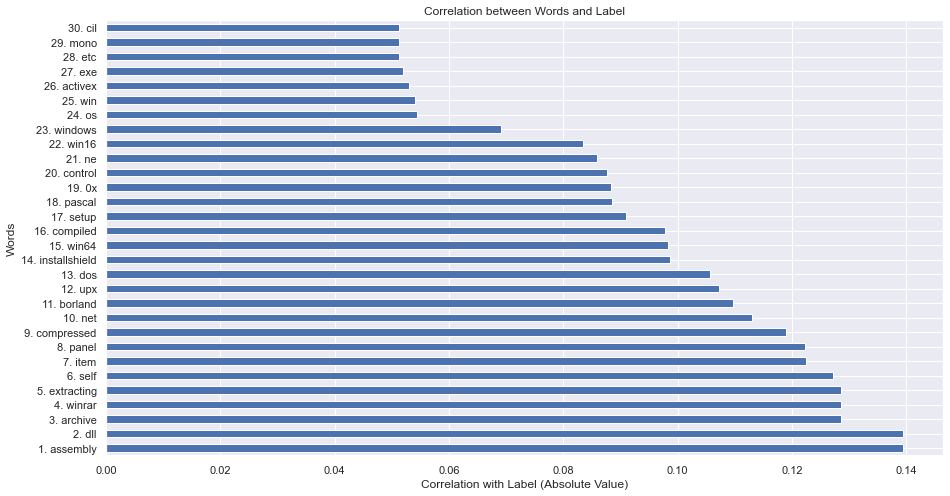

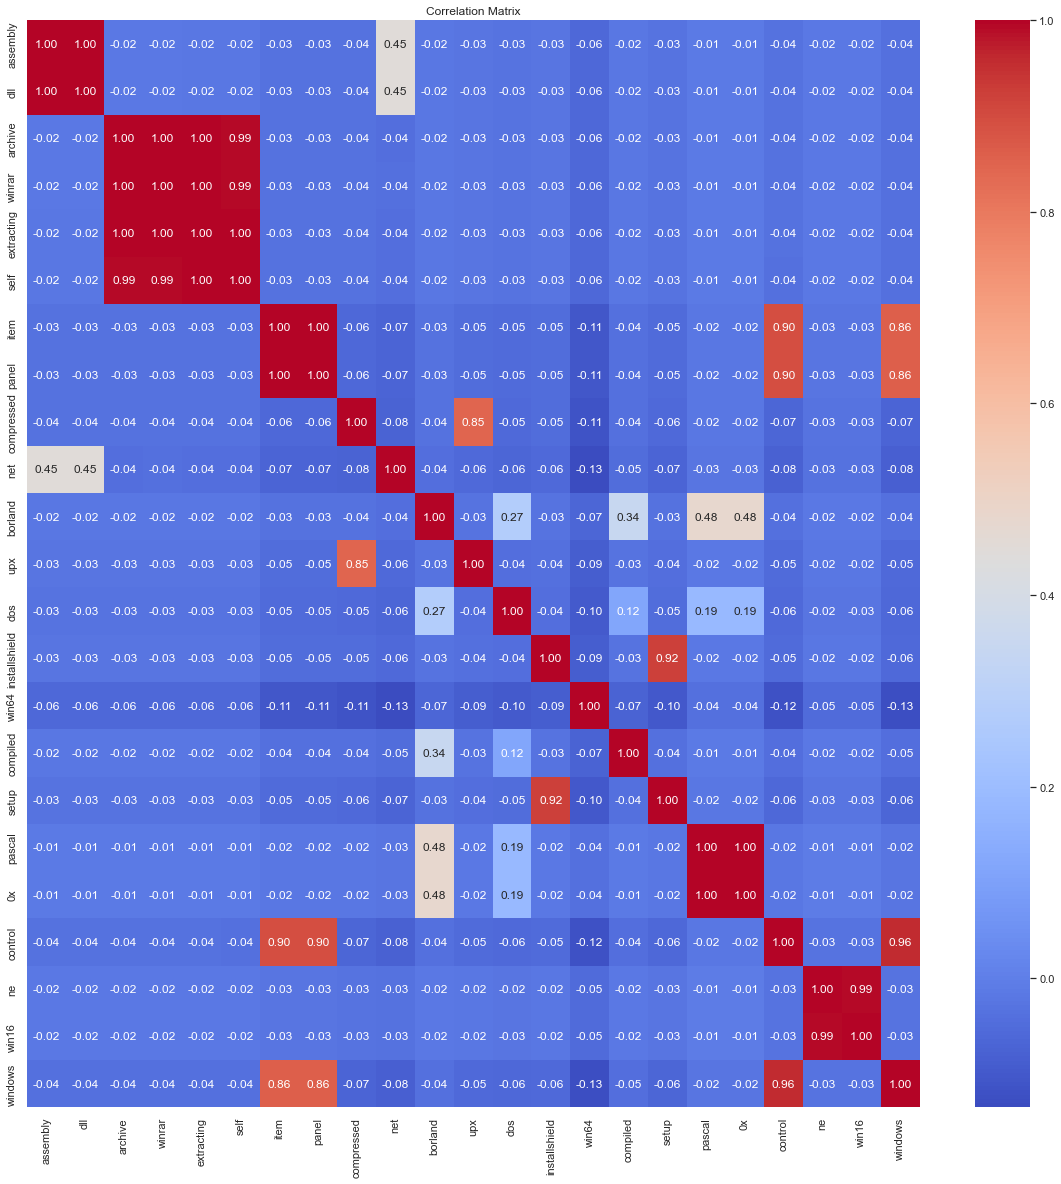

In [162]:
### first we make a bar plot for the correlation (absolute value) so we can find the ideal K

text_data =  Xlog_train['file_type_trid']
labels = ylog_train
# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(text_data)

# Get the feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Add the label column to the TF-IDF DataFrame
tfidf_df['label'] = labels

# Calculate the correlation between each word and the label
correlation = tfidf_df.corr()['label'].drop('label')

# Calculate the absolute value of the correlation
correlation_abs = correlation.abs()

# Sort the words based on the absolute correlation values
sorted_words = correlation_abs.sort_values(ascending=False).index
top_words = sorted_words[:30]
top_corr = correlation_abs[top_words]
# Sort the correlation series based on the absolute correlation values
correlation_sorted = correlation.reindex(sorted_words)

# Plot the bar plot
plt.figure(figsize=(15, 8))
ax = top_corr.plot.barh()

# Add numeration next to each word on the y-axis
ax.set_yticks(range(len(top_words)))
ax.set_yticklabels([f"{i+1}. {word}" for i, word in enumerate(top_words)])
plt.xlabel('Correlation with Label (Absolute Value)')
plt.ylabel('Words')
plt.title('Correlation between Words and Label')
plt.show


# Calculate the correlation matrix
correlation_matrix = tfidf_df[top_words[:23]].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Based on the confusion matrix above, we can see that we have multiple words with a very strong correlation, meaning we can eliminate redundant words and thus reduce dimensions in our data

In [163]:
removed_words = ['dll', 'archive', 'winrar', 'self', 'item', 'pascal', 'ne', 'windows', 'control', 'installshield', 'compressed']

In [164]:
def AddTopk_and_fit(X, y, feature, k):
    '''
    Performs TF-IDF vectorization on the 'file_type_trid' feature.
    Calculates the correlations between each word and the target variable.
    Selects the top k correlated words and adds them as new columns to the dataset.
    Parameters:
        X: DataFrame, input dataset.
        y: the labels.
        feature: str, name of the feature to perform TF-IDF vectorization on, here it's file_type_trid.
        k: int, number of top correlated words to select.
    Returns:
        tfidf_vectorizer: TfidfVectorizer object, trained TF-IDF vectorizer.
        top_words: array-like, top k correlated words.
        X: DataFrame, dataset with added columns for top correlated words.
        new_cols: DataFrame, new columns containing TF-IDF values for top correlated words.
    '''
    # Perform TF-IDF vectorization
    tfidf_vectorizer = TfidfVectorizer(smooth_idf=True, use_idf=True)
    tfidf_matrix = tfidf_vectorizer.fit_transform(X[feature])

    # Convert the TF-IDF matrix to a DataFrame
    feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

    # Add the label column to the TF-IDF DataFrame
    tfidf_df['label'] = y

    # Calculate the correlation between each word and the label
    correlation = tfidf_df.corr()['label'].drop('label')

    # Calculate the absolute value of the correlation
    correlation_abs = correlation.abs()

    # Sort the words based on the absolute correlation values
    sorted_words = correlation_abs.sort_values(ascending=False).index
    top_words = sorted_words[:k]

    # Get the top correlated words
    new_cols = tfidf_df[top_words]

    # Reset the index of X and new_cols
    X.reset_index(drop=True, inplace=True)
    new_cols.reset_index(drop=True, inplace=True)

    # Concatenate X and new_cols
    X = pd.concat([X, new_cols], axis=1)

    return tfidf_vectorizer, top_words, X, new_cols


def AddTfIdf(X, feature, values, vect):
    '''
    Performs TF-IDF vectorization on the specified feature using a pre-trained vectorizer.
    Adds the TF-IDF values of the selected words as new columns to the dataset.
    Parameters:
        X: DataFrame, input dataset.
        feature: str, name of the feature to perform TF-IDF vectorization on, here its file_type_trid.
        values: array-like, selected words for TF-IDF representation.
        vect: TfidfVectorizer object, pre-trained TF-IDF vectorizer.
    Returns:
        X: DataFrame, dataset with added columns for TF-IDF values of selected words.
    '''
    X_tfidf = vect.transform(X[feature])
    new_cols = pd.DataFrame(X_tfidf.todense(), columns=vect.get_feature_names_out())
    new_cols = new_cols[values]
    X.reset_index(drop=True, inplace=True)
    new_cols.reset_index(drop=True, inplace=True)   
    X = pd.concat([X, new_cols], axis=1)
    return X
    

__So what is our ideal K?__ <br>
Based on the graph we did above, sorting the words with the strongest correlation to the label, we will choose words that exceed the correlation threshold of 0.1, which means K = 13


In [165]:
v, top_words, Xlog_train, new_cols = AddTopk_and_fit(Xlog_train, ylog_train, 'file_type_trid', 23)
Xlog_val = AddTfIdf(Xlog_val, 'file_type_trid', top_words, v)
c_test = AddTfIdf(c_test, 'file_type_trid', top_words, v)

ylog_train.reset_index(inplace=True, drop=True)
ylog_val.reset_index(inplace=True, drop=True)

In [166]:
Xlog_train.drop(removed_words, inplace=True, axis=1)
Xlog_val.drop(removed_words, inplace=True, axis=1)
c_test.drop(removed_words, inplace=True, axis=1)

In [167]:
print("Xlog_val shape:", Xlog_val.shape)
print("ylog_val shape:", ylog_val.shape)

print("Xlog_train shape:", Xlog_train.shape)
print("ylog_train shape:", ylog_train.shape)

Xlog_val shape: (12000, 41)
ylog_val shape: (12000,)
Xlog_train shape: (48000, 41)
ylog_train shape: (48000,)


In [168]:
### feature that didn't quite help us at the end: we want to have a prediction on the label based on all the tf-idf words, but it just led to overfitting

def sus_words_fit_predict(X, y, feature):
    '''
    Performs TF-IDF vectorization, feature scaling, dimensionality reduction, and logistic regression to predict the target variable based on the TF-IDF words.
    Adds the predicted probabilities as a new column in the dataset.
    Parameters:
        X: DataFrame, input dataset.
        y: the labels.
        feature: str, name of the feature to perform TF-IDF vectorization on.
    Returns:
        lr: LogisticRegression object, trained logistic regression model.
        vectorizer: TfidfVectorizer object, trained TF-IDF vectorizer.
        pca: PCA object, trained PCA model.
        scale: StandardScaler object, trained feature scaler.
    '''
    scale = StandardScaler()
    vectorizer = TfidfVectorizer(smooth_idf=True, use_idf=True)
    vec = vectorizer.fit_transform(X[feature])
    word_df = pd.DataFrame(vec.todense(), columns=vectorizer.get_feature_names_out())
    word_df = scale.fit_transform(word_df)
    pca = PCA(0.99)
    word_reduced = pca.fit_transform(word_df)
    print('componentes to explain 99 percent of the data',len(pca.components_))
    lr = LogisticRegression(solver='liblinear', penalty='l2').fit(word_reduced, y)
    X['sus_type_proba'] = lr.predict_proba(word_reduced)[:, 1]
    return (lr, vectorizer, pca, scale)



def sus_words_predict(X, feature, estimator, vectorizer, pca, scaler):
    '''
    Performs TF-IDF vectorization, dimensionality reduction, and prediction using a pre-trained model to predict the target variable based on the TF-IDF words.
    Adds the predicted probabilities as a new column in the dataset.
    Parameters:
        X: DataFrame, input dataset.
        feature: str, name of the feature to perform TF-IDF vectorization on.
        estimator: object, pre-trained prediction model.
        vectorizer: TfidfVectorizer object, pre-trained TF-IDF vectorizer.
        pca: PCA object, pre-trained PCA model.
        scaler: StandardScaler object, pre-trained feature scaler.
    Returns:
        X: DataFrame, dataset with added column for predicted probabilities.
    '''
    vec = vectorizer.transform(X[feature])
    word_df = pd.DataFrame(vec.todense(), columns=vectorizer.get_feature_names_out())
    word_reduced  =pca.transform(word_df)
    pred = estimator.predict_proba(word_reduced)[:, 1]
    X['sus_type_proba'] = pred

Why didn't we use the function from above? 

Based on trial and error, with and without the function, we have seen a substantial drop in our performence, with a far lower AUC than without the feature.

In [169]:
Xlog_train.head()

sha256  size  vsize  imports  \
0  bcbb6983c4994e67a8cbb4a881f1b3c394ca350b031e92...  4.88   4.99     0.30   
1  4effece7e4766fd6dcf9086ac1b7510cfda9fde032a098...  5.55   5.58     1.54   
2  4322f9cfc0e93d5c6503b2d5e99196936481a31ff35254...  6.05   6.05     2.39   
3  689e467c1d57b4492502f620cb6004e5f09c5db8c72cd6...  5.98   6.32     0.48   
4  b54b1d51bfa1099ff08251f4f8a7d512bda09232f74868...  6.20   6.22     2.26   

   exports  has_debug  has_relocations  has_resources  has_signature  has_tls  \
0     0.00       1.00             1.00           1.00           0.00     0.00   
1     0.00       1.00             1.00           1.00           0.00     0.00   
2     0.00       1.00             1.00           1.00           1.00     1.00   
3     0.00       0.00              NaN           1.00           0.00     0.00   
4     0.00        NaN             0.00           1.00           0.00     0.00   

   symbols  numstrings  paths  urls  registry   MZ  printables  avlength  \
0     0.00        2.76   0.00  0.00      0.00 0.60        3.89       NaN   
1     0.00        3.83   0.00  0.30      0.00 0.70        4.60      0.84   
2     0.00        3.52   0.00  1.60      0.00 0.95        4.92      1.41   
3      NaN        3.60    NaN  0.00      0.00 1.18         NaN      0.83   
4     0.00        3.51   1.00   NaN      0.00  NaN        4.50      1.03   

                              file_type_trid  file_type_prob_trid    A    B  \
0  Generic CIL Executable (.NET, Mono, etc.)                70.80 6.37 5.34   
1              Win16 NE executable (generic)                45.50 4.58 4.93   
2       Windows Control Panel Item (generic)                88.30 5.18 5.83   
3                 Win32 Executable (generic)                42.70 0.32 6.55   
4  Win32 Executable Microsoft Visual Basic 6                69.40 3.08 5.50   

   C_bf  C_cs  C_er  C_gow  C_mc  C_vh  C_vr  assembly  extracting  panel  \
0  0.00  0.00  0.00   0.00  0.00  1.00  0.00      0.00        0.00   0.00   
1  0.00  0.00  0.00   0.00  0.00  1.00  0.00      0.00        0.00   0.00   
2  0.00  0.00  0.00   0.00  0.00  1.00  0.00      0.00        0.00   0.51   
3  0.00  0.00  0.00   0.00  0.00  1.00  0.00      0.00        0.00   0.00   
4  0.00  0.00  0.00   0.00  0.00  1.00  0.00      0.00        0.00   0.00   

   net  borland  upx  dos  win64  compiled  setup   0x  win16  
0 0.46     0.00 0.00 0.00   0.00      0.00   0.00 0.00   0.00  
1 0.00     0.00 0.00 0.00   0.00      0.00   0.00 0.00   0.69  
2 0.00     0.00 0.00 0.00   0.00      0.00   0.00 0.00   0.00  
3 0.00     0.00 0.00 0.00   0.00      0.00   0.00 0.00   0.00  
4 0.00     0.00 0.00 0.00   0.00      0.00   0.00 0.00   0.00

In [170]:
Xlog_val.head()

sha256  size  vsize  imports  \
0  52528ab99c136570d9e9da202d4ac5cd9a55d789424bac...  5.37   5.40     1.98   
1  c55950ad0b80ae656a14e9631339a8aface3b04007b3af...  6.05   6.05     2.39   
2  9d431a681a6edc282b66e7ba1e05a47196a33c2fb357be...  6.19   5.10     2.08   
3  7da56032874623b084f9b6b962e9956c21fd4d840ac504...  5.58   5.60     2.15   
4  ad2d6bdb7d0f1933fb43e03fbe501c560d17c73ff9d9ac...  5.69   5.70     2.52   

   exports  has_debug  has_relocations  has_resources  has_signature  has_tls  \
0     0.00        NaN             0.00           1.00           0.00     0.00   
1     0.00       1.00             1.00           1.00           1.00     1.00   
2     0.00       0.00             0.00           1.00           0.00     1.00   
3     0.85       1.00             1.00           1.00           1.00     1.00   
4     0.70       0.00             0.00           1.00           1.00     0.00   

   symbols  numstrings  paths  urls  registry   MZ  printables  avlength  \
0     0.00        3.00   0.00  0.00      0.00 0.60         NaN      1.05   
1     0.00        3.52    NaN  1.60      0.00 0.95        4.92      1.41   
2     0.00        3.85   0.00  0.30      0.00 1.45        4.63      0.85   
3     0.00        3.16   0.30  1.30      0.00 0.78        4.29      1.16   
4     0.00        3.12   0.00  0.85      0.00 0.30        4.15      1.06   

                             file_type_trid  file_type_prob_trid     A    B  \
0  Win32 Executable MS Visual C++ (generic)                41.00  3.56 5.97   
1      Windows Control Panel Item (generic)                88.30 10.03 5.84   
2           Win32 Executable Delphi generic                42.50  2.31 6.56   
3  Win32 Executable MS Visual C++ (generic)                48.80   NaN  NaN   
4  Win32 Executable MS Visual C++ (generic)                35.80  4.23 5.74   

   C_bf  C_cs  C_er  C_gow  C_mc  C_vh  C_vr  assembly  extracting  panel  \
0  0.00  1.00  0.00   0.00  0.00  0.00  0.00      0.00        0.00   0.00   
1  0.00  0.00  0.00   0.00  0.00  1.00  0.00      0.00        0.00   0.51   
2  1.00  0.00  0.00   0.00  0.00  0.00  0.00      0.00        0.00   0.00   
3  0.00  0.00  0.00   0.00  0.00  0.00  0.00      0.00        0.00   0.00   
4  0.00  0.00  0.00   0.00  0.00  0.00  0.00      0.00        0.00   0.00   

   net  borland  upx  dos  win64  compiled  setup   0x  win16  
0 0.00     0.00 0.00 0.00   0.00      0.00   0.00 0.00   0.00  
1 0.00     0.00 0.00 0.00   0.00      0.00   0.00 0.00   0.00  
2 0.00     0.00 0.00 0.00   0.00      0.00   0.00 0.00   0.00  
3 0.00     0.00 0.00 0.00   0.00      0.00   0.00 0.00   0.00  
4 0.00     0.00 0.00 0.00   0.00      0.00   0.00 0.00   0.00

### Step 2 of pre-processing: Adding new features

can we add more features? manipulations? yes!

Lets add the following interactions:
1. code_density = vsize/size.
* Code density represents the memory efficiency of an executable file. Higher code density indicates optimized memory usage. In the case of malicious files, unusually high code density may suggest attempts to obfuscate malicious code.
2. i_e_ratio = imports/exports.
* The import-export ratio reflects the balance between reliance on imports and exports. In business, a higher ratio implies greater import dependency. Malicious files can exploit this by leveraging vulnerabilities in imported resources or components, potentially leading to security breaches. Monitoring the import-export ratio helps identify suspicious patterns indicative of malicious activity.

We will use the log values of the features above.<br>
whats good about this? 
1. we are working with log values so we can just subtract instead of dividing.
2. we have features that are heavily correlated with others, thus we can remove those features and turn them in to 1 combined feature.

__Sanity Check:__ lets just make sure distributions are as we would like them to be

In [171]:
def compute_additional_features(data):
    '''
    Compute additional features 'code_density' and 'i_e_ratio' by subtracting specific columns in the given dataset.
    Parameters:
        data: dataset to add the features.
    Returns:
        data: Updated dataset with added features.
    '''
    data['code_density'] = data['vsize'] - data['size']
    data['i_e_ratio'] = data['imports'] - data['exports']
    return data


In [172]:
features_to_add = ['code_density', 'i_e_ratio']
numerical.extend(features_to_add)

Xlog_train = compute_additional_features(Xlog_train)
Xlog_val = compute_additional_features(Xlog_val)
c_test = compute_additional_features(c_test)

In [173]:
print("Xlog_val shape:", Xlog_val.shape)
print("ylog_val shape:", ylog_val.shape)

print("Xlog_train shape:", Xlog_train.shape)
print("ylog_train shape:", ylog_train.shape)

Xlog_val shape: (12000, 43)
ylog_val shape: (12000,)
Xlog_train shape: (48000, 43)
ylog_train shape: (48000,)


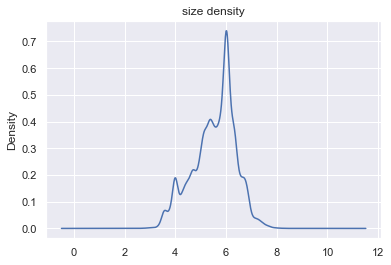

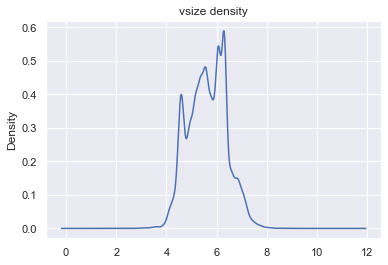

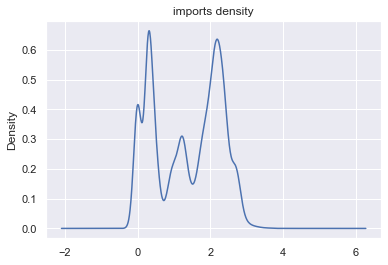

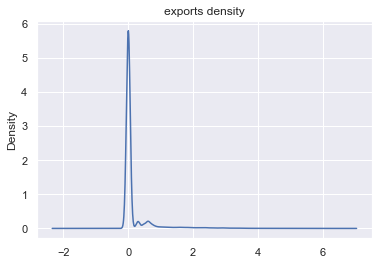

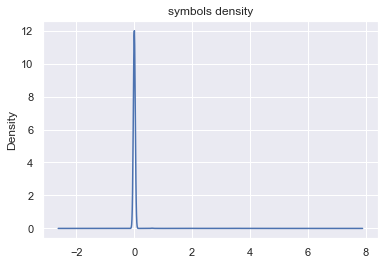

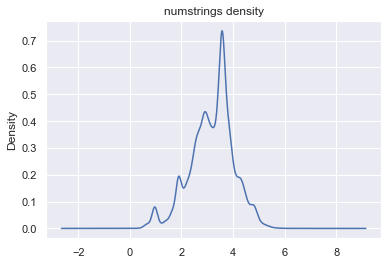

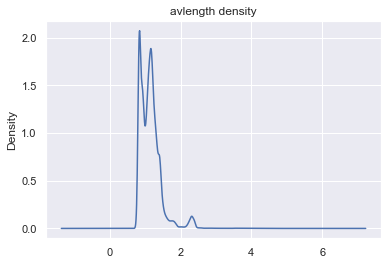

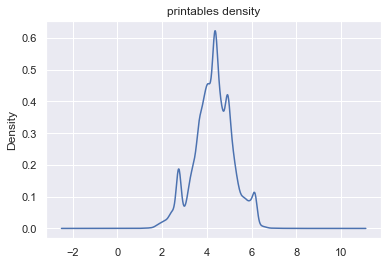

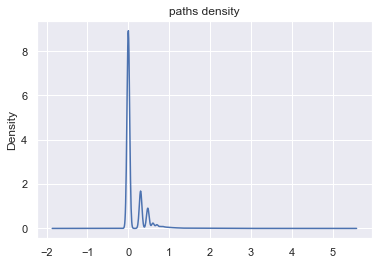

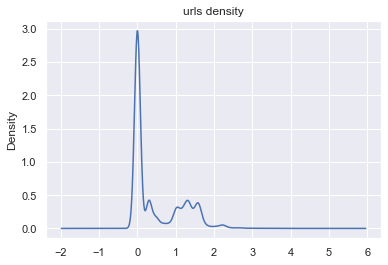

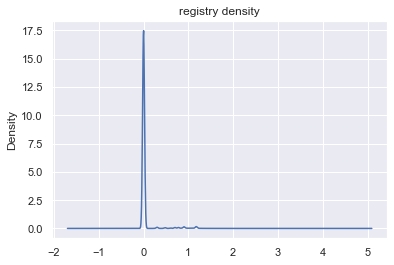

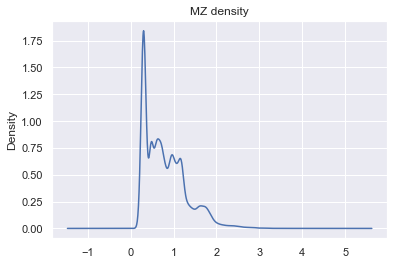

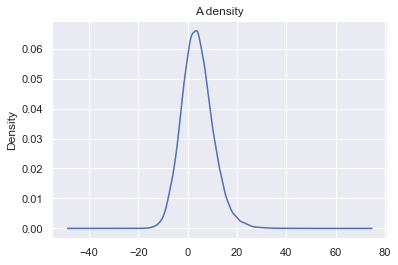

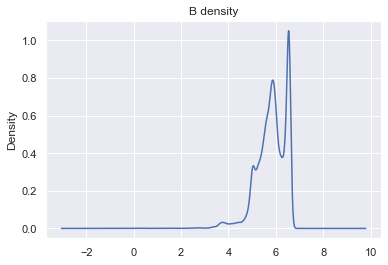

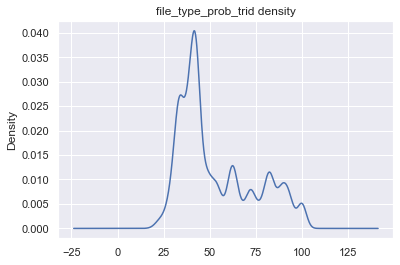

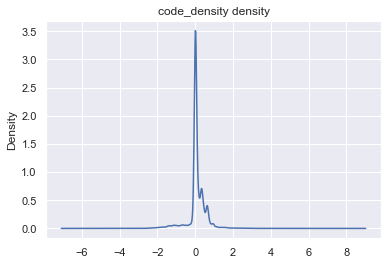

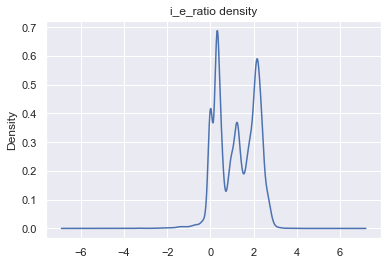

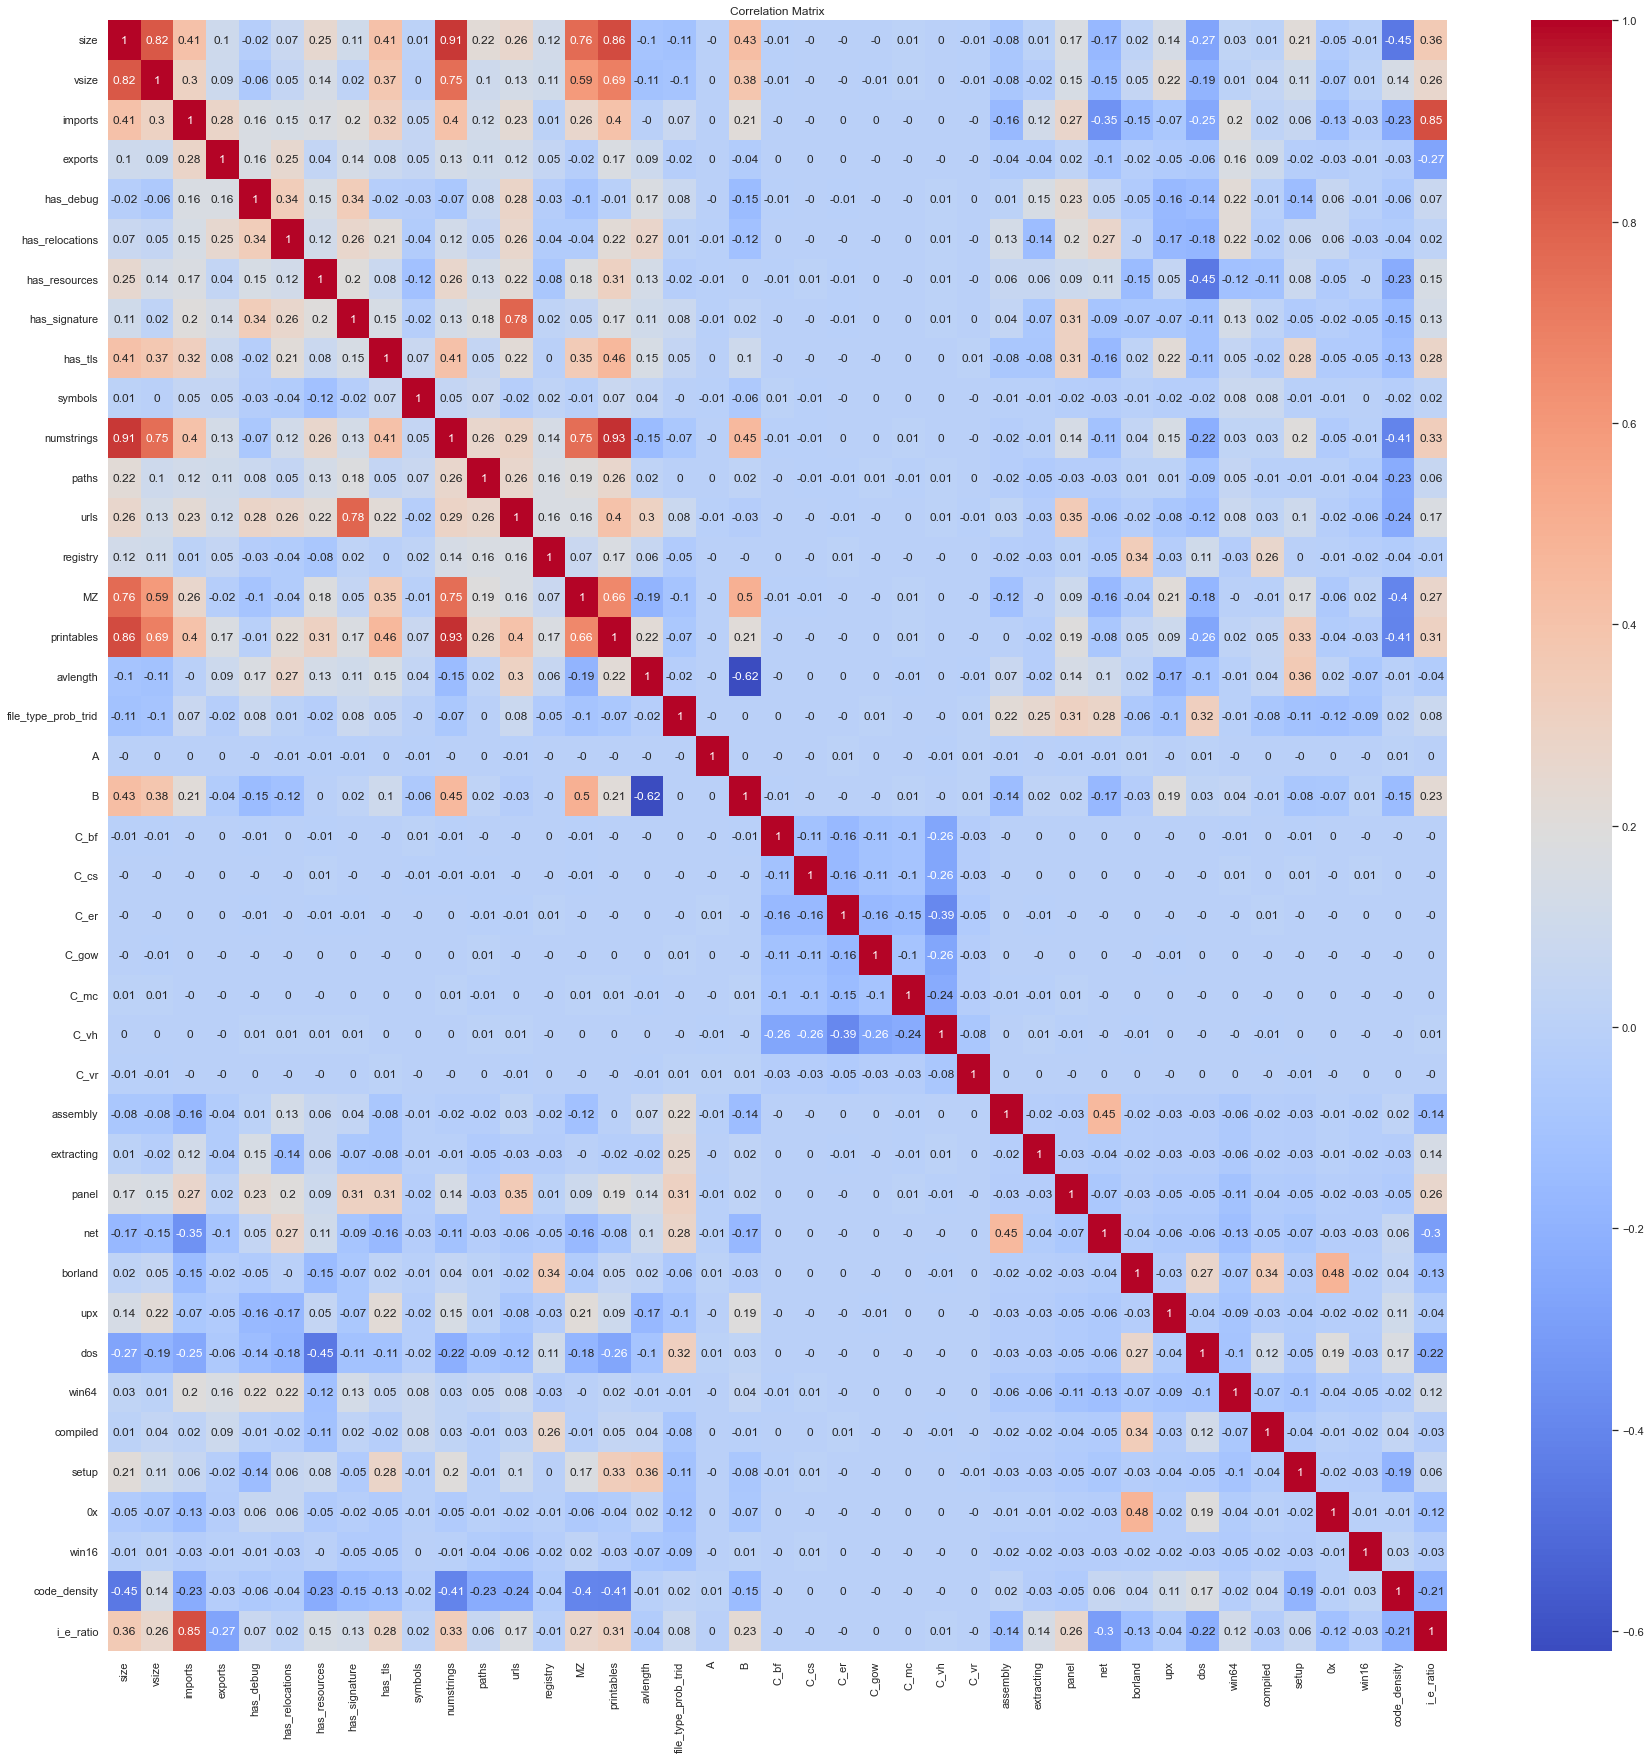

In [174]:
# Sanity Check and Correlation Analysis 
for col in numerical: 
    Xlog_train[col].plot.density()
    plt.title(col+" density")
    plt.show()
corr_matrix = Xlog_train.corr().round(2)
plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title("Correlation Matrix")
plt.show()

__NOTE:__ We have more ideas for interactions between the boolean features, however, in order to avoid cotradictions between the values, (1^0==1), because we might remove obvservations while dealing with outliers and missing values, so we will create the interactions after dealing with outliers and missing values.

Why wasn't it a problem with the previous new features? because we are combining two features into one in order to remove correlated features / redundant features, something we are not going to do with the boolean features.

In [175]:
#Add code_density to the normally distributed features list because it looks normally distributed
normally_features.append('code_density')

### Step 3 of pre-processing: Removing redundant features

First we will remove the string features that can't help us with calculations.

In [176]:
def remove_features(data, removed_features):
    '''
    Remove specified features and normalize 'code_density' in the given datasets.
    Parameters:
        data: dataset to remove features from.
        removed_features: List of features to be removed.
    Returns:
        data: Updated dataset with removed features.
    '''
    for feature in removed_features:
        if feature in data.columns:
            data.drop(feature, axis=1, inplace=True)
    
    return data

In [177]:
removed_features = ['sha256', 'file_type_trid']
Xlog_train = remove_features(Xlog_train, removed_features)
Xlog_val = remove_features(Xlog_val, removed_features)
c_test = remove_features(c_test, removed_features)

In [178]:
print("Xlog_val shape:", Xlog_val.shape)
print("ylog_val shape:", ylog_val.shape)

print("Xlog_train shape:", Xlog_train.shape)
print("ylog_train shape:", ylog_train.shape)

Xlog_val shape: (12000, 41)
ylog_val shape: (12000,)
Xlog_train shape: (48000, 41)
ylog_train shape: (48000,)


In [179]:
#Checking the correctness of the function
Xlog_train.head()

size  vsize  imports  exports  has_debug  has_relocations  has_resources  \
0  4.88   4.99     0.30     0.00       1.00             1.00           1.00   
1  5.55   5.58     1.54     0.00       1.00             1.00           1.00   
2  6.05   6.05     2.39     0.00       1.00             1.00           1.00   
3  5.98   6.32     0.48     0.00       0.00              NaN           1.00   
4  6.20   6.22     2.26     0.00        NaN             0.00           1.00   

   has_signature  has_tls  symbols  numstrings  paths  urls  registry   MZ  \
0           0.00     0.00     0.00        2.76   0.00  0.00      0.00 0.60   
1           0.00     0.00     0.00        3.83   0.00  0.30      0.00 0.70   
2           1.00     1.00     0.00        3.52   0.00  1.60      0.00 0.95   
3           0.00     0.00      NaN        3.60    NaN  0.00      0.00 1.18   
4           0.00     0.00     0.00        3.51   1.00   NaN      0.00  NaN   

   printables  avlength  file_type_prob_trid    A    B  C_bf  C_cs  C_er  \
0        3.89       NaN                70.80 6.37 5.34  0.00  0.00  0.00   
1        4.60      0.84                45.50 4.58 4.93  0.00  0.00  0.00   
2        4.92      1.41                88.30 5.18 5.83  0.00  0.00  0.00   
3         NaN      0.83                42.70 0.32 6.55  0.00  0.00  0.00   
4        4.50      1.03                69.40 3.08 5.50  0.00  0.00  0.00   

   C_gow  C_mc  C_vh  C_vr  assembly  extracting  panel  net  borland  upx  \
0   0.00  0.00  1.00  0.00      0.00        0.00   0.00 0.46     0.00 0.00   
1   0.00  0.00  1.00  0.00      0.00        0.00   0.00 0.00     0.00 0.00   
2   0.00  0.00  1.00  0.00      0.00        0.00   0.51 0.00     0.00 0.00   
3   0.00  0.00  1.00  0.00      0.00        0.00   0.00 0.00     0.00 0.00   
4   0.00  0.00  1.00  0.00      0.00        0.00   0.00 0.00     0.00 0.00   

   dos  win64  compiled  setup   0x  win16  code_density  i_e_ratio  
0 0.00   0.00      0.00   0.00 0.00   0.00          0.11       0.30  
1 0.00   0.00      0.00   0.00 0.00   0.69          0.03       1.54  
2 0.00   0.00      0.00   0.00 0.00   0.00          0.00       2.39  
3 0.00   0.00      0.00   0.00 0.00   0.00          0.33       0.48  
4 0.00   0.00      0.00   0.00 0.00   0.00          0.01       2.26

In [180]:
c_test.head()

size  vsize  imports  exports  has_debug  has_relocations  has_resources  \
0  5.98   6.32     0.48      NaN       0.00             0.00            NaN   
1  5.07   5.30     2.14     0.00       1.00             1.00           1.00   
2  6.49   5.07     2.10     0.30       0.00             1.00           1.00   
3  6.10   6.10     0.00     0.00       1.00             1.00           1.00   
4  6.33   6.33     2.22     0.00       0.00             0.00           1.00   

   has_signature  has_tls  symbols  numstrings  paths  urls  registry   MZ  \
0           0.00     0.00     0.00        3.60   0.00  0.00      0.00 1.18   
1           0.00     0.00     0.00        2.56   0.30  0.00      0.00 0.78   
2           0.00     0.00     0.00        4.13   1.11  0.00      0.00 1.00   
3           0.00     0.00     0.00        3.81   0.00   NaN      0.00 0.48   
4           0.00     0.00     0.00        3.46   0.70  0.00      0.00 0.48   

   printables  avlength  file_type_prob_trid     A    B  C_bf  C_cs  C_er  \
0        4.36      0.83                42.70 -1.41 6.55  0.00  0.00  1.00   
1        3.87      1.33                48.80   NaN 5.58  0.00  1.00  0.00   
2        5.17      1.08                24.10 -1.71 6.10  0.00  0.00  0.00   
3        5.08      1.29                33.10  9.22 5.42  0.00  0.00  0.00   
4        4.33      0.93                84.40  2.22  NaN  0.00  0.00  1.00   

   C_gow  C_mc  C_vh  C_vr  assembly  extracting  panel  net  borland  upx  \
0   0.00  0.00  0.00  0.00      0.00        0.00   0.00 0.00     0.00 0.00   
1   0.00  0.00  0.00  0.00      0.00        0.00   0.00 0.00     0.00 0.00   
2   0.00  0.00  1.00  0.00      0.00        0.00   0.00 0.00     0.00 0.00   
3   0.00  0.00  1.00  0.00      0.00        0.00   0.00 0.00     0.00 0.00   
4   0.00  0.00  0.00  0.00      0.00        0.00   0.00 0.00     0.00 0.00   

   dos  win64  compiled  setup   0x  win16  code_density  i_e_ratio  
0 0.00   0.00      0.00   0.00 0.00   0.00          0.33        NaN  
1 0.00   0.00      0.00   0.00 0.00   0.00          0.24       2.14  
2 0.00   0.00      0.00   0.68 0.00   0.00         -1.42       1.80  
3 0.00   0.00      0.00   0.00 0.00   0.00          0.00       0.00  
4 0.00   0.00      0.00   0.00 0.00   0.00          0.01       2.22

__Features to remove:__

* features with low variance:

1. symbols
2. registry
3. exports

* features that are correlated with others:

1. size
2. vsize
3. numstrings

In [181]:
removed_features = ['symbols', 'registry', 'exports', 'size', 'vsize', 'numstrings']
Xlog_train = remove_features(Xlog_train, removed_features)
Xlog_val = remove_features(Xlog_val, removed_features)
c_test = remove_features(c_test, removed_features)

In [182]:
print("Xlog_val shape:", Xlog_val.shape)
print("ylog_val shape:", ylog_val.shape)

print("Xlog_train shape:", Xlog_train.shape)
print("ylog_train shape:", ylog_train.shape)

Xlog_val shape: (12000, 35)
ylog_val shape: (12000,)
Xlog_train shape: (48000, 35)
ylog_train shape: (48000,)


In [183]:
#Checking the correctness of the function
Xlog_train.head()

imports  has_debug  has_relocations  has_resources  has_signature  has_tls  \
0     0.30       1.00             1.00           1.00           0.00     0.00   
1     1.54       1.00             1.00           1.00           0.00     0.00   
2     2.39       1.00             1.00           1.00           1.00     1.00   
3     0.48       0.00              NaN           1.00           0.00     0.00   
4     2.26        NaN             0.00           1.00           0.00     0.00   

   paths  urls   MZ  printables  avlength  file_type_prob_trid    A    B  \
0   0.00  0.00 0.60        3.89       NaN                70.80 6.37 5.34   
1   0.00  0.30 0.70        4.60      0.84                45.50 4.58 4.93   
2   0.00  1.60 0.95        4.92      1.41                88.30 5.18 5.83   
3    NaN  0.00 1.18         NaN      0.83                42.70 0.32 6.55   
4   1.00   NaN  NaN        4.50      1.03                69.40 3.08 5.50   

   C_bf  C_cs  C_er  C_gow  C_mc  C_vh  C_vr  assembly  extracting  panel  \
0  0.00  0.00  0.00   0.00  0.00  1.00  0.00      0.00        0.00   0.00   
1  0.00  0.00  0.00   0.00  0.00  1.00  0.00      0.00        0.00   0.00   
2  0.00  0.00  0.00   0.00  0.00  1.00  0.00      0.00        0.00   0.51   
3  0.00  0.00  0.00   0.00  0.00  1.00  0.00      0.00        0.00   0.00   
4  0.00  0.00  0.00   0.00  0.00  1.00  0.00      0.00        0.00   0.00   

   net  borland  upx  dos  win64  compiled  setup   0x  win16  code_density  \
0 0.46     0.00 0.00 0.00   0.00      0.00   0.00 0.00   0.00          0.11   
1 0.00     0.00 0.00 0.00   0.00      0.00   0.00 0.00   0.69          0.03   
2 0.00     0.00 0.00 0.00   0.00      0.00   0.00 0.00   0.00          0.00   
3 0.00     0.00 0.00 0.00   0.00      0.00   0.00 0.00   0.00          0.33   
4 0.00     0.00 0.00 0.00   0.00      0.00   0.00 0.00   0.00          0.01   

   i_e_ratio  
0       0.30  
1       1.54  
2       2.39  
3       0.48  
4       2.26

Checking the status of the features so far:

In [184]:
#All the normally distributed features
normally_features = [i for i in normally_features if i not in removed_features]
print("The normally distributed features in our final DB are: ", normally_features)

#All the features
features = Xlog_train.columns.tolist()
print("The features in our final DB are: ", features)

#All the features that removed
print("The removed features are: ", removed_features)

The normally distributed features in our final DB are:  ['A', 'printables', 'code_density']
The features in our final DB are:  ['imports', 'has_debug', 'has_relocations', 'has_resources', 'has_signature', 'has_tls', 'paths', 'urls', 'MZ', 'printables', 'avlength', 'file_type_prob_trid', 'A', 'B', 'C_bf', 'C_cs', 'C_er', 'C_gow', 'C_mc', 'C_vh', 'C_vr', 'assembly', 'extracting', 'panel', 'net', 'borland', 'upx', 'dos', 'win64', 'compiled', 'setup', '0x', 'win16', 'code_density', 'i_e_ratio']
The removed features are:  ['symbols', 'registry', 'exports', 'size', 'vsize', 'numstrings']


We will see how the new features correlate with the other features, therefore we are plotting a new correlation matrix:

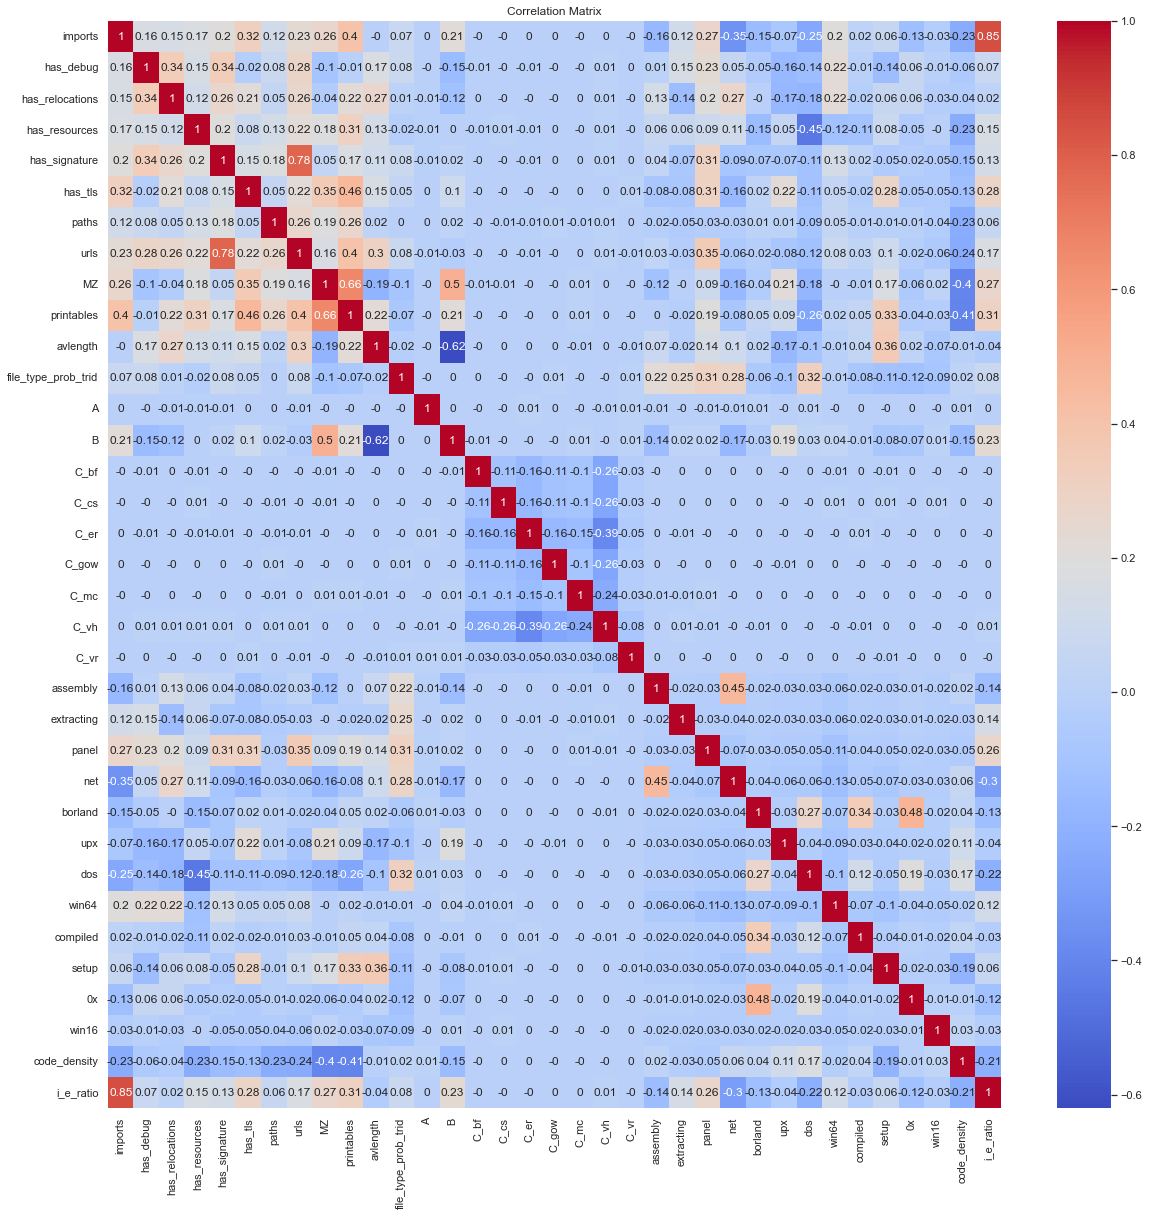

In [185]:
corr_matrix = Xlog_train.corr().round(2)
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title("Correlation Matrix")
plt.show()

### Step 4 of pre-processing: Removing outliers

* If feature is normally distributed then we will use boxplot.

* We will also check how many outliers are removed with one of the following algorithms: 
1. DBScan - density-based clustering algorithm that groups data points based on their density and identifies outliers.
2. IsolationForest - The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

3. KMeans - given K centroids, we detect the outliers

The code performs outlier removal using different techniques and provides visualizations of the results for analysis.

for feature A to remove 4 stds detected 367 outliers
for feature printables to remove 4 stds detected 102 outliers
for feature code_density to remove 4 stds detected 1488 outliers
For feature A to remove 4 IQRs detected 936 outliers
For feature printables to remove 4 IQRs detected 649 outliers
For feature code_density to remove 4 IQRs detected 6192 outliers
for eps = 0.1 removed  47348
for eps = 0.5 removed  45455
for eps = 1 removed  43602
for eps = 1.5 removed  36349
for eps = 2 removed  26198
for eps = 2.5 removed  17456
for eps = 3 removed  11416
for eps = 3.5 removed  7955
for eps = 4 removed  6199
for eps = 4.5 removed  5170
for min_samples = 2 removed  42002
for min_samples = 3 removed  44000
for min_samples = 4 removed  44880

for max_samples = 50 removed  928
for max_samples = 100 removed  868
for max_samples = 150 removed  1030
for max_samples = 200 removed  915
for max_samples = 250 removed  876
for max_samples = 300 removed  930
for max_samples = 350 removed  848
for max_sa

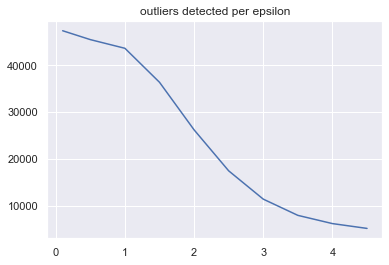

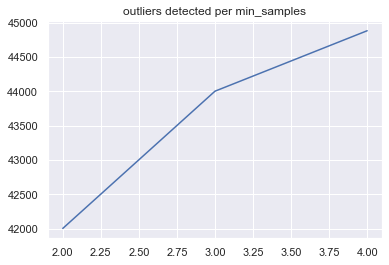

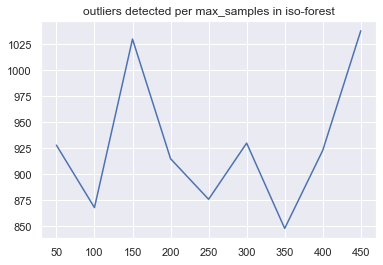

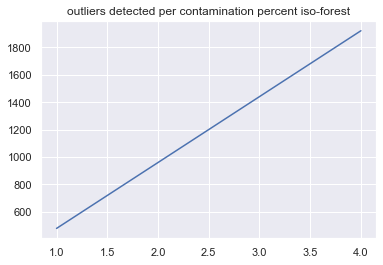

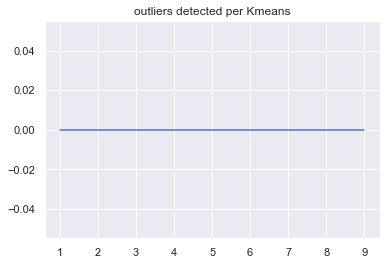

In [186]:
# step 1: using boxplot / IQR
no_outliers = Xlog_train.copy()
no_outliers_y = ylog_train.copy()
for norm in normally_features:
    if (norm not in removed_features):
        removed = Xlog_train[(np.abs(stats.zscore(Xlog_train[norm].fillna(Xlog_train[norm].median())))>=3)].shape[0]
        print("for feature",norm,'to remove', i,'stds detected',removed,'outliers')

        
#using IQR

for norm in normally_features:
    if (norm not in removed_features):
        q1 = Xlog_train[norm].quantile(0.25)
        q3 = Xlog_train[norm].quantile(0.75)
        iqr_range = stats.iqr(Xlog_train[norm].fillna(Xlog_train[norm].median()))
        upper_bound = q3 + 1.5 * iqr_range
        lower_bound = q1 - 1.5 * iqr_range
        
        removed = Xlog_train[(Xlog_train[norm] < lower_bound) | (Xlog_train[norm] > upper_bound)].shape[0]
        print("For feature", norm, "to remove", i, "IQRs detected", removed, "outliers")

# step 2: DBSCAN
### detecting outliers with DBSCAN
no_outliers.fillna(-999,inplace=True) #we will turn it back to -1
total = Xlog_train.shape[0] # get num of rows
outlier_clf = IsolationForest(max_samples=100, random_state = 1, contamination= 'auto')

epsilons = [0.1, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5]
outliers = []
for ep in epsilons:
    pred = DBSCAN(eps=ep).fit_predict(no_outliers)
    outliers.append(len(pred[pred==-1]))
    print('for eps =',ep, 'removed ',len(pred[pred==-1]))

samples_outliers = []
min_samples = list(range(2, 5))
for mini in min_samples:
    pred = DBSCAN(min_samples=mini).fit_predict(no_outliers)
    samples_outliers.append(len(pred[pred==-1]))
    print('for min_samples =',mini, 'removed ',len(pred[pred==-1]))

print()
# step 3: isolation forest
### detecting outliers with isolation forest
iso_samples = list(range(50, 500, 50))
iso_outliers = []
for max_samp in iso_samples:
    pred = IsolationForest(max_samples=max_samp, random_state=0).fit_predict(no_outliers)
    iso_outliers.append(len(pred[pred==-1]))
    print('for max_samples =',max_samp, 'removed ',len(pred[pred==-1]))

contaminatinos = list(range(1, 5))
cont_outliers = []
for i in range(1, 5):
    pred = IsolationForest(random_state=0, contamination = i/100).fit_predict(no_outliers)
    cont_outliers.append(len(pred[pred==-1]))
    print('for contamination =',i, 'removed ',len(pred[pred==-1]))

print()
# Step 4: Kmeans
### detecting outliers via KMeans algorithm
Ks = list(range(1, 10))
k_outliers=[]

for k in Ks:
    pred = KMeans(n_clusters=k).fit_predict(no_outliers)
    k_outliers.append(len(pred[pred==-1]))
plt.plot(epsilons, outliers)
plt.title("outliers detected per epsilon")
plt.show()

plt.plot(min_samples, samples_outliers)
plt.title("outliers detected per min_samples")
plt.show()


plt.plot(iso_samples, iso_outliers)
plt.title("outliers detected per max_samples in iso-forest")
plt.show()

plt.plot(contaminatinos, cont_outliers)
plt.title("outliers detected per contamination percent iso-forest")
plt.show()

plt.plot(Ks, k_outliers)
plt.title("outliers detected per Kmeans")
plt.show()

no_outliers.replace(-999, np.nan, inplace=True)

In [187]:
# code so we could re-run

Xlog_train = no_outliers.copy()
ylog_train = no_outliers_y.copy()

Based on the outputs and the Graphs above, we can confidently say that there are outliers in our data.

Ways we will deal with them:

1. Outlier removal via the normally distributed features. (ZScore)
2. Isolation forest

Why those two? the first one is using our assumption on features that distribute normally, the assumption that helps us remove outliers. 

Why isolation forest with contmaination = 0.01?<br>
We don't want to remove too many observations, based on the graphs, other algorithms remove thousands of observations, (and in some cases more than 10 thousand - a quarter of our data), which in our view seems too much.

In [188]:
print("Xlog_val shape:", Xlog_val.shape)
print("ylog_val shape:", ylog_val.shape)

print("Xlog_train shape:", Xlog_train.shape)
print("ylog_train shape:", ylog_train.shape)

Xlog_val shape: (12000, 35)
ylog_val shape: (12000,)
Xlog_train shape: (48000, 35)
ylog_train shape: (48000,)


__So which method we will use?__

Based on the preformence of the algorithms above, we will stay with the boxplot and iso_forest with max_samples=100.<br>

We think this is the best combination (and hyperparameter for contaminations), since it doesn't remove too many observations, something that can lead lower quality fitting. We don't want to have a model that is based on too little observations, without much "spread" in the features.

In [189]:
def remove_outliers_zscore(X, y, features):
    '''
    Remove outliers from the dataset based on Z-score.
    Parameters:
        X : Input features.
        y : label variable.
        features (list): List of features to consider for outlier removal.
    Returns:
        X : Updated features after outlier removal.
        y : Updated labels variable after outlier removal.
    '''
    for feature in features:
        print('removing via Zscore outliers by feature', feature)
        mask = (np.abs(stats.zscore(X[feature].fillna(X[feature].median()))) < 3)
        y = y[mask]
        X = X[mask]
    
    return X, y


def remove_outliers_isolation_forest(X_train, y_train):
    '''
    Remove outliers from the training dataset using Isolation Forest.
    Parameters:
        X_train: Training dataset.
        y_train: Target variable for the training dataset.
    Returns:
        X_train_no_outliers: Training dataset with outliers removed.
        y_train_no_outliers: Target variable corresponding to the updated training dataset.
    '''
    # Create an Isolation Forest outlier classifier and fit on the training dataset
    outlier_clf = IsolationForest(contamination = 0.01)
    outlier_clf.fit(X_train.fillna(-999))
    
    # Predict outliers and create a mask to filter out non-outliers
    outliers_mask = (outlier_clf.predict(X_train.fillna(-999)) != -1)
    
    # Filter out outliers from the training dataset and corresponding target variable
    X_train_no_outliers = X_train[outliers_mask]
    y_train_no_outliers = y_train[outliers_mask]
    
    return X_train_no_outliers, y_train_no_outliers


# and a function to remove via IQR (boxplot)
def removeOutliersIQR(X, y, features):
        '''
    Remove outliers from the dataset based on Z-score.
    Parameters:
        X : Input features.
        y : label variable.
        features (list): List of features to consider for outlier removal.
    Returns:
        X : Updated features after outlier removal.
        y : Updated labels variable after outlier removal.
    '''
        for norm in features:
            q1 = X[norm].quantile(0.25)
            q3 = X[norm].quantile(0.75)
            iqr_range = stats.iqr(X[norm].fillna(X[norm].median()))
            upper_bound = q3 + 1.5 * iqr_range
            lower_bound = q1 - 1.5 * iqr_range

            y = y[(X[norm] >= lower_bound) | (X[norm] <= upper_bound)]
            X = X[(X[norm] >= lower_bound) | (X[norm] <= upper_bound)]
            print("For feature", norm, "to remove", removed, "outliers")

        return X, y

In [190]:
### outlier removal via Zscore
Xlog_train, ylog_train = remove_outliers_zscore(Xlog_train, ylog_train, normally_features)
#Xlog_train, ylog_train = removeOutliersIQR(Xlog_train, ylog_train, normally_features)
### outlier removal via Isolation Forest
Xlog_train, ylog_train = remove_outliers_isolation_forest(Xlog_train, ylog_train)

removing via Zscore outliers by feature A
removing via Zscore outliers by feature printables
removing via Zscore outliers by feature code_density


In [191]:
print("Xlog_val shape:", Xlog_val.shape)
print("ylog_val shape:", ylog_val.shape)

print("Xlog_train shape:", Xlog_train.shape)
print("ylog_train shape:", ylog_train.shape)

Xlog_val shape: (12000, 35)
ylog_val shape: (12000,)
Xlog_train shape: (45592, 35)
ylog_train shape: (45592,)


### Step 5 of pre-processing: Dealing with missing values

Before dealing with the missing values, we will see the percentage of missing values for every feature:

In [192]:
Xlog_train.isnull().mean()*100

imports               2.48
has_debug             4.80
has_relocations       5.38
has_resources         3.19
has_signature         3.01
has_tls               4.75
paths                 6.02
urls                  3.82
MZ                    5.03
printables            4.52
avlength              4.54
file_type_prob_trid   0.00
A                     6.19
B                     6.08
C_bf                  0.00
C_cs                  0.00
C_er                  0.00
C_gow                 0.00
C_mc                  0.00
C_vh                  0.00
C_vr                  0.00
assembly              0.00
extracting            0.00
panel                 0.00
net                   0.00
borland               0.00
upx                   0.00
dos                   0.00
win64                 0.00
compiled              0.00
setup                 0.00
0x                    0.00
win16                 0.00
code_density          3.27
i_e_ratio             5.67
dtype: float64

In [193]:
c_test.isnull().mean()*100

imports                7.08
has_debug              8.97
has_relocations        5.53
has_resources          3.49
has_signature          3.08
has_tls                4.92
paths                  6.39
urls                   4.19
MZ                     4.92
printables             4.68
avlength               4.41
file_type_prob_trid    0.00
A                      6.52
B                      6.32
C_bf                   0.00
C_cs                   0.00
C_er                   0.00
C_gow                  0.00
C_mc                   0.00
C_vh                   0.00
C_vr                   0.00
assembly               0.00
extracting             0.00
panel                  0.00
net                    0.00
borland                0.00
upx                    0.00
dos                    0.00
win64                  0.00
compiled               0.00
setup                  0.00
0x                     0.00
win16                  0.00
code_density           3.18
i_e_ratio             22.15
dtype: float64

In [194]:
Xlog_val.isnull().mean()*100

imports               3.11
has_debug             4.88
has_relocations       5.83
has_resources         3.20
has_signature         3.46
has_tls               4.69
paths                 6.07
urls                  4.01
MZ                    4.98
printables            4.47
avlength              4.44
file_type_prob_trid   0.00
A                     6.14
B                     6.34
C_bf                  0.00
C_cs                  0.00
C_er                  0.00
C_gow                 0.00
C_mc                  0.00
C_vh                  0.00
C_vr                  0.00
assembly              0.00
extracting            0.00
panel                 0.00
net                   0.00
borland               0.00
upx                   0.00
dos                   0.00
win64                 0.00
compiled              0.00
setup                 0.00
0x                    0.00
win16                 0.00
code_density          3.09
i_e_ratio             6.52
dtype: float64

We can see that there is indeed a significant percentage of many of the features that are of missing value.

After we dealt with outliers, we can now deal with missing values:

__First we will deal with the boolean features:__

For each feature we will take the most common value. This is because if we get a random observation, we can say "it probably has the most probabable value" if we don't know the values. It allows us to make an informed assumption about the missing values based on the prevalence of the most frequent value. This approach helps to preserve the overall distribution and characteristics of the data, making it a reasonable choice for handling missing boolean values.

While we do it, we can also add interactions of the boolean features that we've seen are helpful with the prediction of viruses. 

The interactions is:
'AND' between every two boolean features.

__Below we defined 3 functions:__

1. fit_fill_bool - gets the most common values for each boolean feature and fills NaN while doing so

2. fill_bool - uses the most common values for each bool we got from the fit and fills NaN values accordingly

3. add_interactions - adds interactions of the boolean features as new features

In [195]:
def fit_fill_bool(X, boolean_features):
    '''
    Fit and fill boolean features with mode values in the given dataset (will be the train data set).
    Parameters:
        X: Dataset containing boolean features.
        boolean_features: List of boolean features to be filled.
    Returns:
        mode_vals: Dictionary containing the mode values for each boolean feature.
    '''
    mode_vals = {}
    for feature in boolean_features:
        mode_value = X[feature].mode()[0] #if the majority is 1 then we fill the NaN with 1 and otherwise
        mode_vals[feature] = mode_value
        X[feature].fillna(mode_value, inplace=True)  # Fill NaN with mode (the most frequently occurring value)
    return mode_vals


def fill_bool(X, boolean_features, mode_values):
    '''
    Fill boolean features with precomputed mode values in the given dataset.
    Parameters:
        X: Dataset containing boolean features (now its the test df).
        boolean_features: List of boolean features to be filled.
        mode_values: Dictionary containing the precomputed mode values for each boolean feature.
    '''
    for feat in boolean_features:
        X[feat].fillna(mode_values[feat], inplace=True)
 
        
def add_interactions(X, boolean_features):
    '''
    Add interaction features by multiplying pairs of boolean features in the given dataset.
    Parameters:
        X: Dataset containing boolean features.
        boolean_features: List of boolean features to create interactions from.
    '''
    for i in range(len(boolean_features)-1):
        for j in range(i+1, len(boolean_features)):
            feat1 = boolean_features[i]
            feat2 = boolean_features[j]
            X[feat1+'*'+feat2] = X[feat1]*X[feat2]

In [196]:
#dealing with missing values in boolean features (the has features)
boolean_features = [cat for cat in features if ('has' in cat)]

mode_vals = fit_fill_bool(Xlog_train, boolean_features)
fill_bool(Xlog_val, boolean_features, mode_vals)
fill_bool(c_test, boolean_features, mode_vals)

add_interactions(Xlog_train, boolean_features)
add_interactions(Xlog_val, boolean_features)
add_interactions(c_test, boolean_features)

In [197]:
print("Xlog_val shape:", Xlog_val.shape)
print("ylog_val shape:", ylog_val.shape)

print("Xlog_train shape:", Xlog_train.shape)
print("ylog_train shape:", ylog_train.shape)

Xlog_val shape: (12000, 45)
ylog_val shape: (12000,)
Xlog_train shape: (45592, 45)
ylog_train shape: (45592,)


In [198]:
#Validity check that the function does what is required
Xlog_val.head()

imports  has_debug  has_relocations  has_resources  has_signature  has_tls  \
0     1.98       0.00             0.00           1.00           0.00     0.00   
1     2.39       1.00             1.00           1.00           1.00     1.00   
2     2.08       0.00             0.00           1.00           0.00     1.00   
3     2.15       1.00             1.00           1.00           1.00     1.00   
4     2.52       0.00             0.00           1.00           1.00     0.00   

   paths  urls   MZ  printables  avlength  file_type_prob_trid     A    B  \
0   0.00  0.00 0.60         NaN      1.05                41.00  3.56 5.97   
1    NaN  1.60 0.95        4.92      1.41                88.30 10.03 5.84   
2   0.00  0.30 1.45        4.63      0.85                42.50  2.31 6.56   
3   0.30  1.30 0.78        4.29      1.16                48.80   NaN  NaN   
4   0.00  0.85 0.30        4.15      1.06                35.80  4.23 5.74   

   C_bf  C_cs  C_er  C_gow  C_mc  C_vh  C_vr  assembly  extracting  panel  \
0  0.00  1.00  0.00   0.00  0.00  0.00  0.00      0.00        0.00   0.00   
1  0.00  0.00  0.00   0.00  0.00  1.00  0.00      0.00        0.00   0.51   
2  1.00  0.00  0.00   0.00  0.00  0.00  0.00      0.00        0.00   0.00   
3  0.00  0.00  0.00   0.00  0.00  0.00  0.00      0.00        0.00   0.00   
4  0.00  0.00  0.00   0.00  0.00  0.00  0.00      0.00        0.00   0.00   

   net  borland  upx  dos  win64  compiled  setup   0x  win16  code_density  \
0 0.00     0.00 0.00 0.00   0.00      0.00   0.00 0.00   0.00          0.03   
1 0.00     0.00 0.00 0.00   0.00      0.00   0.00 0.00   0.00          0.00   
2 0.00     0.00 0.00 0.00   0.00      0.00   0.00 0.00   0.00         -1.09   
3 0.00     0.00 0.00 0.00   0.00      0.00   0.00 0.00   0.00          0.02   
4 0.00     0.00 0.00 0.00   0.00      0.00   0.00 0.00   0.00          0.01   

   i_e_ratio  has_debug*has_relocations  has_debug*has_resources  \
0       1.98                       0.00                     0.00   
1       2.39                       1.00                     1.00   
2       2.08                       0.00                     0.00   
3       1.31                       1.00                     1.00   
4       1.82                       0.00                     0.00   

   has_debug*has_signature  has_debug*has_tls  has_relocations*has_resources  \
0                     0.00               0.00                           0.00   
1                     1.00               1.00                           1.00   
2                     0.00               0.00                           0.00   
3                     1.00               1.00                           1.00   
4                     0.00               0.00                           0.00   

   has_relocations*has_signature  has_relocations*has_tls  \
0                           0.00                     0.00   
1                           1.00                     1.00   
2                           0.00                     0.00   
3                           1.00                     1.00   
4                           0.00                     0.00   

   has_resources*has_signature  has_resources*has_tls  has_signature*has_tls  
0                         0.00                   0.00                   0.00  
1                         1.00                   1.00                   1.00  
2                         0.00                   1.00                   0.00  
3                         1.00                   1.00                   1.00  
4                         1.00                   0.00                   0.00

__Next we will deal with the missing values for the continuous features:__

We will use the SimpleImputer function:
* 'SimpleImputer' provides a simple and flexible way to handle missing values in a dataset.<br>
It allows you to replace missing values with either a constant value or statistics computed from the non-missing values in the same column, such as mean, median, or most frequent value. 
* In order to fill in the missing values, we decided to use the median. For the reason that after trial and error during the project we saw that the median gives us better results.

In [199]:
def fit_missing_values(train, imputer, numeric):
    '''
    Fit missing values in numeric features of the training dataset using the median strategy.
    Parameters:
        train: Training dataset.
        imputer: The imputer object.
        numeric: the numeric feature to deal with its missing vals.
    Returns:
        train: Updated training dataset with filled missing values.
        imputer: Trained imputer object.
    '''
    train[numeric] = imputer.fit_transform(train[[numeric]])
    return train, imputer


def fill_missing_values(data, imputer, numeric):
    '''
    Fill missing values in numeric features of the given dataset using the trained imputer object.
    Parameters:
        data: Dataset to fill missing values.
        imputer: Trained imputer object.
        numerical: the numeric feature to deal with its missing vals.
    Returns:
        data: Updated dataset with filled missing values.
    '''
    data[numeric] = imputer.transform(data[[numeric]])
    return data


In [200]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

for numeric in numerical:
        if numeric not in removed_features:
                Xlog_train, imputer = fit_missing_values(Xlog_train, imputer, numeric)
                Xlog_val = fill_missing_values(Xlog_val, imputer, numeric)
                c_test = fill_missing_values(c_test, imputer, numeric)

In [201]:
print("Xlog_val shape:", Xlog_val.shape)
print("ylog_val shape:", ylog_val.shape)

print("Xlog_train shape:", Xlog_train.shape)
print("ylog_train shape:", ylog_train.shape)

Xlog_val shape: (12000, 45)
ylog_val shape: (12000,)
Xlog_train shape: (45592, 45)
ylog_train shape: (45592,)


In [202]:
#from now on we will work with test_df
test_df = c_test.copy()

In [203]:
print("Xlog_val shape:", Xlog_val.shape)
print("ylog_val shape:", ylog_val.shape)

print("Xlog_train shape:", Xlog_train.shape)
print("ylog_train shape:", ylog_train.shape)

print("test shape:", test_df.shape)


Xlog_val shape: (12000, 45)
ylog_val shape: (12000,)
Xlog_train shape: (45592, 45)
ylog_train shape: (45592,)
test shape: (18000, 45)


__Sanity Check:__ see there are no missing values anymore

In [204]:
Xlog_train.isnull().mean()*100

imports                         0.00
has_debug                       0.00
has_relocations                 0.00
has_resources                   0.00
has_signature                   0.00
has_tls                         0.00
paths                           0.00
urls                            0.00
MZ                              0.00
printables                      0.00
avlength                        0.00
file_type_prob_trid             0.00
A                               0.00
B                               0.00
C_bf                            0.00
C_cs                            0.00
C_er                            0.00
C_gow                           0.00
C_mc                            0.00
C_vh                            0.00
C_vr                            0.00
assembly                        0.00
extracting                      0.00
panel                           0.00
net                             0.00
borland                         0.00
upx                             0.00
d

In [205]:
Xlog_val.isnull().mean()*100

imports                         0.00
has_debug                       0.00
has_relocations                 0.00
has_resources                   0.00
has_signature                   0.00
has_tls                         0.00
paths                           0.00
urls                            0.00
MZ                              0.00
printables                      0.00
avlength                        0.00
file_type_prob_trid             0.00
A                               0.00
B                               0.00
C_bf                            0.00
C_cs                            0.00
C_er                            0.00
C_gow                           0.00
C_mc                            0.00
C_vh                            0.00
C_vr                            0.00
assembly                        0.00
extracting                      0.00
panel                           0.00
net                             0.00
borland                         0.00
upx                             0.00
d

In [206]:
test_df.isnull().mean()*100

imports                         0.00
has_debug                       0.00
has_relocations                 0.00
has_resources                   0.00
has_signature                   0.00
has_tls                         0.00
paths                           0.00
urls                            0.00
MZ                              0.00
printables                      0.00
avlength                        0.00
file_type_prob_trid             0.00
A                               0.00
B                               0.00
C_bf                            0.00
C_cs                            0.00
C_er                            0.00
C_gow                           0.00
C_mc                            0.00
C_vh                            0.00
C_vr                            0.00
assembly                        0.00
extracting                      0.00
panel                           0.00
net                             0.00
borland                         0.00
upx                             0.00
d

In [207]:
Xlog_train.describe()

imports  has_debug  has_relocations  has_resources  has_signature  \
count 45592.00   45592.00         45592.00       45592.00       45592.00   
mean      1.37       0.39             0.58           0.87           0.25   
std       0.90       0.49             0.49           0.34           0.43   
min       0.00       0.00             0.00           0.00           0.00   
25%       0.30       0.00             0.00           1.00           0.00   
50%       1.49       0.00             1.00           1.00           0.00   
75%       2.18       1.00             1.00           1.00           0.00   
max       4.18       1.00             1.00           1.00           1.00   

       has_tls    paths     urls       MZ  printables  avlength  \
count 45592.00 45592.00 45592.00 45592.00    45592.00  45592.00   
mean      0.22     0.12     0.46     0.78        4.28      1.15   
std       0.42     0.26     0.65     0.45        0.81      0.30   
min       0.00     0.00     0.00     0.30        1.79      0.79   
25%       0.00     0.00     0.00     0.30        3.82      0.93   
50%       0.00     0.00     0.00     0.70        4.35      1.12   
75%       0.00     0.30     1.04     1.08        4.79      1.25   
max       1.00     3.73     3.59     3.51        6.80      4.41   

       file_type_prob_trid        A        B     C_bf     C_cs     C_er  \
count             45592.00 45592.00 45592.00 45592.00 45592.00 45592.00   
mean                 53.80     3.83     5.81     0.10     0.10     0.19   
std                  20.67     5.87     0.61     0.30     0.30     0.39   
min                  17.50   -14.49     0.17     0.00     0.00     0.00   
25%                  38.40    -0.05     5.51     0.00     0.00     0.00   
50%                  43.30     3.58     5.85     0.00     0.00     0.00   
75%                  69.60     7.41     6.28     0.00     0.00     0.00   
max                 100.00    22.46     6.58     1.00     1.00     1.00   

         C_gow     C_mc     C_vh     C_vr  assembly  extracting    panel  \
count 45592.00 45592.00 45592.00 45592.00  45592.00    45592.00 45592.00   
mean      0.09     0.09     0.39     0.01      0.01        0.01     0.03   
std       0.29     0.28     0.49     0.10      0.09        0.07     0.12   
min       0.00     0.00     0.00     0.00      0.00        0.00     0.00   
25%       0.00     0.00     0.00     0.00      0.00        0.00     0.00   
50%       0.00     0.00     0.00     0.00      0.00        0.00     0.00   
75%       0.00     0.00     1.00     0.00      0.00        0.00     0.00   
max       1.00     1.00     1.00     1.00      0.63        0.50     0.51   

           net  borland      upx      dos    win64  compiled    setup  \
count 45592.00 45592.00 45592.00 45592.00 45592.00  45592.00 45592.00   
mean      0.04     0.01     0.03     0.04     0.14      0.01     0.03   
std       0.13     0.08     0.13     0.17     0.32      0.10     0.14   
min       0.00     0.00     0.00     0.00     0.00      0.00     0.00   
25%       0.00     0.00     0.00     0.00     0.00      0.00     0.00   
50%       0.00     0.00     0.00     0.00     0.00      0.00     0.00   
75%       0.00     0.00     0.00     0.00     0.00      0.00     0.00   
max       0.46     0.75     0.70     0.91     0.84      0.67     0.68   

            0x    win16  code_density  i_e_ratio  has_debug*has_relocations  \
count 45592.00 45592.00      45592.00   45592.00                   45592.00   
mean      0.00     0.01          0.11       1.21                       0.30   
std       0.05     0.08          0.34       0.88                       0.46   
min       0.00     0.00         -1.33      -3.37                       0.00   
25%       0.00     0.00          0.00       0.30                       0.00   
50%       0.00     0.00          0.02       1.23                       0.00   
75%       0.00     0.00          0.25       2.06                       1.00   
max       0.56     0.69          1.50       3.67                   

In [208]:
Xlog_val.describe()

imports  has_debug  has_relocations  has_resources  has_signature  \
count 12000.00   12000.00         12000.00       12000.00       12000.00   
mean      1.35       0.38             0.57           0.86           0.24   
std       0.90       0.49             0.50           0.34           0.43   
min       0.00       0.00             0.00           0.00           0.00   
25%       0.30       0.00             0.00           1.00           0.00   
50%       1.49       0.00             1.00           1.00           0.00   
75%       2.17       1.00             1.00           1.00           0.00   
max       4.17       1.00             1.00           1.00           1.00   

       has_tls    paths     urls       MZ  printables  avlength  \
count 12000.00 12000.00 12000.00 12000.00    12000.00  12000.00   
mean      0.23     0.12     0.45     0.80        4.29      1.14   
std       0.42     0.26     0.65     0.48        0.84      0.29   
min       0.00     0.00     0.00     0.30        0.78      0.78   
25%       0.00     0.00     0.00     0.30        3.79      0.93   
50%       0.00     0.00     0.00     0.70        4.35      1.12   
75%       0.00     0.30     1.04     1.08        4.84      1.25   
max       1.00     3.36     3.75     3.72        7.70      5.32   

       file_type_prob_trid        A        B     C_bf     C_cs     C_er  \
count             12000.00 12000.00 12000.00 12000.00 12000.00 12000.00   
mean                 53.63     4.03     5.80     0.09     0.10     0.19   
std                  20.62     6.21     0.63     0.29     0.29     0.39   
min                  18.10   -17.69     0.00     0.00     0.00     0.00   
25%                  38.40     0.05     5.49     0.00     0.00     0.00   
50%                  43.15     3.58     5.85     0.00     0.00     0.00   
75%                  69.10     7.56     6.30     0.00     0.00     0.00   
max                 100.00    42.94     6.58     1.00     1.00     1.00   

         C_gow     C_mc     C_vh     C_vr  assembly  extracting    panel  \
count 12000.00 12000.00 12000.00 12000.00  12000.00    12000.00 12000.00   
mean      0.09     0.09     0.40     0.01      0.01        0.01     0.03   
std       0.29     0.28     0.49     0.10      0.09        0.07     0.11   
min       0.00     0.00     0.00     0.00      0.00        0.00     0.00   
25%       0.00     0.00     0.00     0.00      0.00        0.00     0.00   
50%       0.00     0.00     0.00     0.00      0.00        0.00     0.00   
75%       0.00     0.00     1.00     0.00      0.00        0.00     0.00   
max       1.00     1.00     1.00     1.00      0.63        0.50     0.51   

           net  borland      upx      dos    win64  compiled    setup  \
count 12000.00 12000.00 12000.00 12000.00 12000.00  12000.00 12000.00   
mean      0.04     0.01     0.03     0.04     0.14      0.02     0.03   
std       0.13     0.08     0.13     0.16     0.31      0.10     0.14   
min       0.00     0.00     0.00     0.00     0.00      0.00     0.00   
25%       0.00     0.00     0.00     0.00     0.00      0.00     0.00   
50%       0.00     0.00     0.00     0.00     0.00      0.00     0.00   
75%       0.00     0.00     0.00     0.00     0.00      0.00     0.00   
max       0.46     0.75     0.70     0.91     0.84      0.67     0.68   

            0x    win16  code_density  i_e_ratio  has_debug*has_relocations  \
count 12000.00 12000.00      12000.00   12000.00                   12000.00   
mean      0.00     0.01          0.09       1.19                       0.29   
std       0.05     0.08          0.48       0.88                       0.45   
min       0.00     0.00         -3.24      -3.40                       0.00   
25%       0.00     0.00          0.00       0.30                       0.00   
50%       0.00     0.00          0.02       1.23                       0.00   
75%       0.00     0.00          0.28       2.05                       1.00   
max       0.56     0.69          3.81       3.60                   

### Step 6 of pre-processing: Normalizing

We will normalzie the values using StandardScaler.

Why normalize: when will use Non-tree based algorithms, especially K-NN, normalization will play a big role, since calculation either distance / any type of effect (values increasing / deacreasing) we would like to have all the features have the same "size".

Why Standardizing? for two reasons:
1. it's intuitive, if we get an average observations, it's not really a big deal for us.
2. also for Non tree-based algorithms, PCA will be used in order to deal with dimensionality, for which all the ways of standardizing, Standard-scaler works best with PCA.

In [209]:
def fit_normalize_data(train, scaler, col):
    '''
    Normalize the train data by fit and transform using StandardScaler.
    Parameters:
        train: Training data to fit and then normalize.
        scaler: The scaler object.
        col: the column in data to normalzie its observations.
    Returns:
        train: Updated normalized training data.
        sc: Fitted scaler object.
    '''
    train[col] = scaler.fit_transform(train[col].values.reshape(-1, 1))
    return train, scaler


def transform_normalize_data(data, scaler, col):
    '''
    Normalize the data using fitted StandardScaler.
    Parameters:
        train: data to normalize.
        scaler: Fitted scaler object.
        col: the column in data to normalzie its observations.
    Returns:
        train: Updated normalized data.
    '''
    data[col] = scaler.transform(data[col].values.reshape(-1, 1))
    return data

In [210]:
scaler = StandardScaler()
for col in test_df.columns:
    Xlog_train, scaler = fit_normalize_data(Xlog_train, scaler, col)
    Xlog_val = transform_normalize_data(Xlog_val, scaler, col)
    test_df = transform_normalize_data(test_df, scaler, col)

__Sanity Check:__

In [211]:
Xlog_train.describe()

imports  has_debug  has_relocations  has_resources  has_signature  \
count 45592.00   45592.00         45592.00       45592.00       45592.00   
mean     -0.00       0.00            -0.00           0.00          -0.00   
std       1.00       1.00             1.00           1.00           1.00   
min      -1.52      -0.80            -1.17          -2.58          -0.58   
25%      -1.19      -0.80            -1.17           0.39          -0.58   
50%       0.13      -0.80             0.85           0.39          -0.58   
75%       0.90       1.25             0.85           0.39          -0.58   
max       3.11       1.25             0.85           0.39           1.73   

       has_tls    paths     urls       MZ  printables  avlength  \
count 45592.00 45592.00 45592.00 45592.00    45592.00  45592.00   
mean      0.00    -0.00    -0.00    -0.00        0.00      0.00   
std       1.00     1.00     1.00     1.00        1.00      1.00   
min      -0.53    -0.47    -0.71    -1.08       -3.07     -1.22   
25%      -0.53    -0.47    -0.71    -1.08       -0.57     -0.73   
50%      -0.53    -0.47    -0.71    -0.19        0.07     -0.10   
75%      -0.53     0.68     0.91     0.66        0.62      0.36   
max       1.87    13.82     4.86     6.11        3.09     11.00   

       file_type_prob_trid        A        B     C_bf     C_cs     C_er  \
count             45592.00 45592.00 45592.00 45592.00 45592.00 45592.00   
mean                 -0.00     0.00     0.00     0.00    -0.00    -0.00   
std                   1.00     1.00     1.00     1.00     1.00     1.00   
min                  -1.76    -3.12    -9.21    -0.33    -0.33    -0.49   
25%                  -0.74    -0.66    -0.50    -0.33    -0.33    -0.49   
50%                  -0.51    -0.04     0.07    -0.33    -0.33    -0.49   
75%                   0.76     0.61     0.76    -0.33    -0.33    -0.49   
max                   2.23     3.17     1.26     3.05     3.00     2.04   

         C_gow     C_mc     C_vh     C_vr  assembly  extracting    panel  \
count 45592.00 45592.00 45592.00 45592.00  45592.00    45592.00 45592.00   
mean     -0.00     0.00    -0.00    -0.00      0.00        0.00     0.00   
std       1.00     1.00     1.00     1.00      1.00        1.00     1.00   
min      -0.32    -0.31    -0.79    -0.10     -0.14       -0.14    -0.24   
25%      -0.32    -0.31    -0.79    -0.10     -0.14       -0.14    -0.24   
50%      -0.32    -0.31    -0.79    -0.10     -0.14       -0.14    -0.24   
75%      -0.32    -0.31     1.26    -0.10     -0.14       -0.14    -0.24   
max       3.11     3.25     1.26    10.13      7.13        7.41     4.13   

           net  borland      upx      dos    win64  compiled    setup  \
count 45592.00 45592.00 45592.00 45592.00 45592.00  45592.00 45592.00   
mean     -0.00    -0.00    -0.00     0.00     0.00     -0.00     0.00   
std       1.00     1.00     1.00     1.00     1.00      1.00     1.00   
min      -0.30    -0.13    -0.20    -0.21    -0.46     -0.15    -0.22   
25%      -0.30    -0.13    -0.20    -0.21    -0.46     -0.15    -0.22   
50%      -0.30    -0.13    -0.20    -0.21    -0.46     -0.15    -0.22   
75%      -0.30    -0.13    -0.20    -0.21    -0.46     -0.15    -0.22   
max       3.32     9.83     5.05     5.30     2.19      6.75     4.80   

            0x    win16  code_density  i_e_ratio  has_debug*has_relocations  \
count 45592.00 45592.00      45592.00   45592.00                   45592.00   
mean      0.00     0.00          0.00       0.00                       0.00   
std       1.00     1.00          1.00       1.00                       1.00   
min      -0.09    -0.12         -4.27      -5.20                      -0.66   
25%      -0.09    -0.12         -0.31      -1.03                      -0.66   
50%      -0.09    -0.12         -0.25       0.03                      -0.66   
75%      -0.09    -0.12          0.42       0.97                       1.52   
max      11.73     8.60          4.11       2.80                   

In [212]:
Xlog_val.describe()

imports  has_debug  has_relocations  has_resources  has_signature  \
count 12000.00   12000.00         12000.00       12000.00       12000.00   
mean     -0.02      -0.02            -0.02          -0.01          -0.02   
std       1.00       1.00             1.00           1.02           0.99   
min      -1.52      -0.80            -1.17          -2.58          -0.58   
25%      -1.19      -0.80            -1.17           0.39          -0.58   
50%       0.13      -0.80             0.85           0.39          -0.58   
75%       0.88       1.25             0.85           0.39          -0.58   
max       3.10       1.25             0.85           0.39           1.73   

       has_tls    paths     urls       MZ  printables  avlength  \
count 12000.00 12000.00 12000.00 12000.00    12000.00  12000.00   
mean      0.01     0.01    -0.00     0.03        0.00     -0.02   
std       1.01     1.01     1.00     1.07        1.03      0.99   
min      -0.53    -0.47    -0.71    -1.08       -4.31     -1.25   
25%      -0.53    -0.47    -0.71    -1.08       -0.60     -0.75   
50%      -0.53    -0.47    -0.71    -0.19        0.07     -0.10   
75%      -0.53     0.68     0.91     0.66        0.68      0.34   
max       1.87    12.43     5.11     6.59        4.20     14.05   

       file_type_prob_trid        A        B     C_bf     C_cs     C_er  \
count             12000.00 12000.00 12000.00 12000.00 12000.00 12000.00   
mean                 -0.01     0.03    -0.01    -0.01    -0.02    -0.00   
std                   1.00     1.06     1.04     0.99     0.98     1.00   
min                  -1.73    -3.67    -9.48    -0.33    -0.33    -0.49   
25%                  -0.74    -0.64    -0.52    -0.33    -0.33    -0.49   
50%                  -0.52    -0.04     0.07    -0.33    -0.33    -0.49   
75%                   0.74     0.64     0.79    -0.33    -0.33    -0.49   
max                   2.23     6.67     1.26     3.05     3.00     2.04   

         C_gow     C_mc     C_vh     C_vr  assembly  extracting    panel  \
count 12000.00 12000.00 12000.00 12000.00  12000.00    12000.00 12000.00   
mean      0.00    -0.00     0.02     0.00      0.00        0.01    -0.02   
std       1.00     0.99     1.00     1.00      1.02        1.05     0.96   
min      -0.32    -0.31    -0.79    -0.10     -0.14       -0.14    -0.24   
25%      -0.32    -0.31    -0.79    -0.10     -0.14       -0.14    -0.24   
50%      -0.32    -0.31    -0.79    -0.10     -0.14       -0.14    -0.24   
75%      -0.32    -0.31     1.26    -0.10     -0.14       -0.14    -0.24   
max       3.11     3.25     1.26    10.13      7.13        7.41     4.13   

           net  borland      upx      dos    win64  compiled    setup  \
count 12000.00 12000.00 12000.00 12000.00 12000.00  12000.00 12000.00   
mean      0.00     0.02     0.00     0.00    -0.02      0.01     0.01   
std       1.00     1.08     1.01     0.99     0.98      1.04     1.00   
min      -0.30    -0.13    -0.20    -0.21    -0.46     -0.15    -0.22   
25%      -0.30    -0.13    -0.20    -0.21    -0.46     -0.15    -0.22   
50%      -0.30    -0.13    -0.20    -0.21    -0.46     -0.15    -0.22   
75%      -0.30    -0.13    -0.20    -0.21    -0.46     -0.15    -0.22   
max       3.32     9.83     5.05     5.30     2.19      6.75     4.80   

            0x    win16  code_density  i_e_ratio  has_debug*has_relocations  \
count 12000.00 12000.00      12000.00   12000.00                   12000.00   
mean      0.02    -0.00         -0.05      -0.02                      -0.03   
std       1.11     0.98          1.41       1.00                       0.99   
min      -0.09    -0.12         -9.91      -5.23                      -0.66   
25%      -0.09    -0.12         -0.31      -1.03                      -0.66   
50%      -0.09    -0.12         -0.25       0.03                      -0.66   
75%      -0.09    -0.12          0.52       0.96                       1.52   
max      11.73     8.60         10.98       2.71                   

In [213]:
print("Xlog_val shape:", Xlog_val.shape)
print("ylog_val shape:", ylog_val.shape)

print("Xlog_train shape:", Xlog_train.shape)
print("ylog_train shape:", ylog_train.shape)

print("test shape:", test_df.shape)

Xlog_val shape: (12000, 45)
ylog_val shape: (12000,)
Xlog_train shape: (45592, 45)
ylog_train shape: (45592,)
test shape: (18000, 45)


__NOTE:__ 

Before the PCA we would like to check the importance of our features by ExtraTreesClassifier. This is a model that knows how to deal with many dimensions relatively quickly since it randomly selects a subset of features at each node of the decision trees, which can help reduce overfitting and improve generalization when understanding the importance of features.
Now, we can see if the interactions and the addition of the new features we made in the data have an effect on the prediction and if we made a smart addition of features.

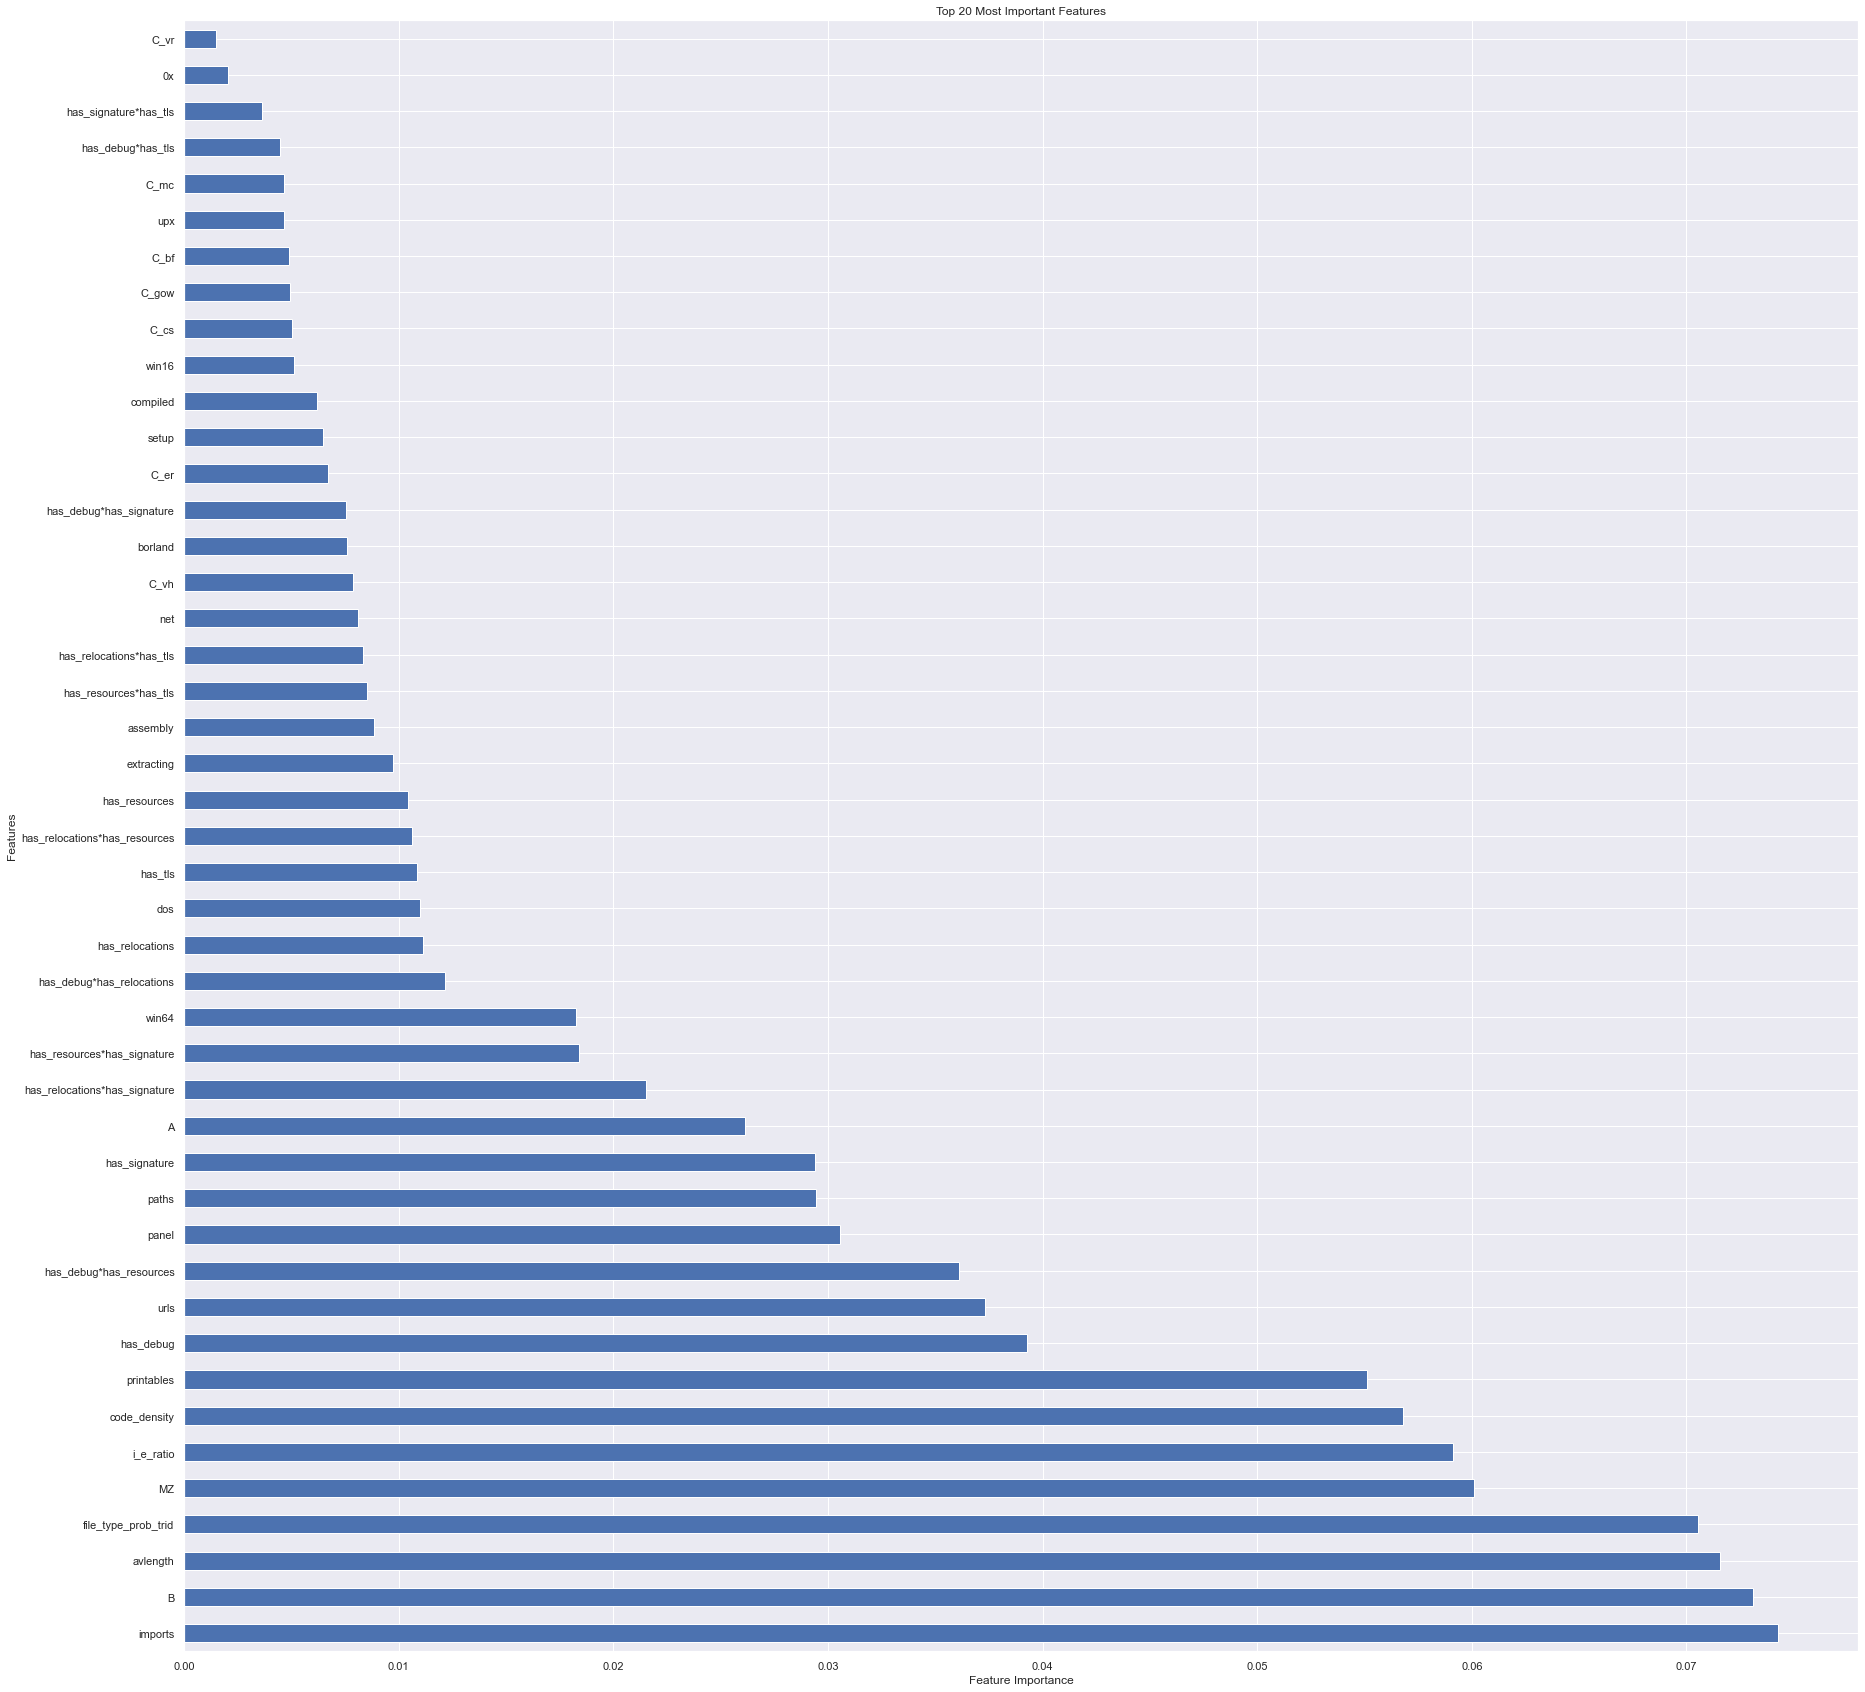

In [214]:
# Fitting the ExtraTreesClassifier model
model = ExtraTreesClassifier()
model.fit(Xlog_train, ylog_train)

# Calculating the feature importances
feat_importances = pd.Series(model.feature_importances_, index=Xlog_train.columns)

# Plotting the top 20 most important features
top_features = feat_importances.nlargest(Xlog_train.shape[1])
plt.figure(figsize=(30, 30))
top_features.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 20 Most Important Features')
plt.show()

We can see that the features we added to the model are indeed reflected in the top 20 features that affect the label!

In [215]:
print("Xlog_val shape:", Xlog_val.shape)
print("ylog_val shape:", ylog_val.shape)

print("Xlog_train shape:", Xlog_train.shape)
print("ylog_train shape:", ylog_train.shape)

print("test shape:", test_df.shape)

Xlog_val shape: (12000, 45)
ylog_val shape: (12000,)
Xlog_train shape: (45592, 45)
ylog_train shape: (45592,)
test shape: (18000, 45)


### Step 7 of pre-processing: Dimension reduction

__Questions to answer:__

1. Do we have too many dimensions?
* At first look, it seems like we probably have too many dimensions. We can understand it due to two reasons:
    1. We added additional features with the understanding that a single feature does not provide us enough information to find the correct prediction when modeling. Therefore, we decided to "split" the feature into several features. For example, feature C which we divided into several dummy features or the type of file from which we took a considerable amount of words representing a feature. Also we added interactions between every two boolean features which increases the dimensinos.
    2. From the beginning, we received a relatively multi-dimensional data set, which raises the suspicion that we should reduce the dimension to avoid problems later on.
    

2. Why it will be a problem?
* The large dimensionality can cause two problems:
    1. The curse of dimensionality - Having a lot of dimensions in our data, making it  harder to find useful patterns or relationships. This is because as the number of dimensions increases, the available data gets spread out thinly in the feature space. Because of that, we can have less data relative to the total possible combinations, which can make it challenging for machine learning algorithms to work effectively.
    2. Overfitting - With high-dimensional data, there is a higher risk of overfitting. Overfitting occurs when a model becomes too complex and starts capturing noise or random variations in the data instead of learning the underlying patterns.
    

3. How can we recognize that the large dimensionality becomes a problem?
* Two signs that high dimensionality is causing problems in a machine learning project are when the model doesn't work well on new data and becomes very sensitive to small changes in the input features. This means that having too many dimensions is making the model perform poorly and behave unpredictably. We will test via both Cross-Validation (using GridSearchCV) as well as testing on the Validation set that we've created using train_test_split.

* __Bias-Variance trade-off:__<br>
We've added multiple features such as the tf-idf features, boolean interactions and dummy variables, in order to decrease the bias of the models we will train and get a better understanding of special interactions and connections in our data, that the default features wouldn't quite grasp on their own. However, we don't want to reach the point where we decrease the bias slightly but increase the variance greatly, which will hurt the performence of each model due to over-sensitivity to the training data and performing poorly to the test data.

### Dimensionality Reduction:

We learned in class two ways to reduce dimensions:
1. PCA
2. Feature Selection

We wrote functions, one that performs PCA and the other that perfoms backwards selection. Eventually we decided to choose PCA, since the backwards selection function takes hours to run, and we want to keep the entire script running at below one hour.

#### PCA:

For explained variance: 0.5 number of dimensions: 8
For explained variance: 0.6 number of dimensions: 11
For explained variance: 0.7 number of dimensions: 15
For explained variance: 0.8 number of dimensions: 20
For explained variance: 0.9 number of dimensions: 25
For explained variance: 0.95 number of dimensions: 30
For explained variance: 0.99 number of dimensions: 38
For explained variance: 0.995 number of dimensions: 40
For explained variance: 0.9999 number of dimensions: 45


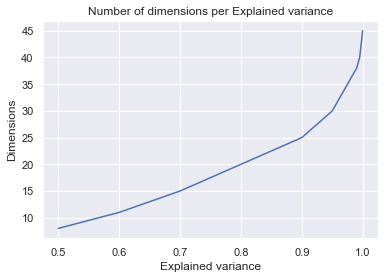

In [216]:
#PCA dimension reduction - We will do PCA in order to further reduce dimensions

variance_vals = [0.5, 0.6, 0.7, .8, .9, 0.95, 0.99, 0.995, .9999]
var_dim = []
for variance in variance_vals:
    pca = PCA(variance)
    data = pca.fit_transform(Xlog_train)
    print("For explained variance:", variance, "number of dimensions:", data.shape[1])
    var_dim.append(data.shape[1])

plt.plot(variance_vals, var_dim)
plt.xlabel("Explained variance")
plt.ylabel("Dimensions")
plt.title("Number of dimensions per Explained variance")
plt.show()

__Based on the graph above:__<br>

If we want to explain more than 90% of our data using PCA, the amount of dimensions increases far more than it did until 0.9, and for that reason, we will use PCA to explain 90% of our data when we use pca transformation on all of the features.

In [217]:

def perform_pca_with_variance(variance_threshold, train_data):
    '''
    Performs PCA on the training data with a specified variance threshold.
    Parameters:
        variance_threshold: The minimum variance threshold to retain.
        train_data: The training data to perform PCA on.
    Returns:
        pca: The fitted PCA object.
        transformed_data: The transformed training data.
    '''
    pca = PCA(variance_threshold)
    transformed_data = pca.fit_transform(train_data)
    return pca, transformed_data



def apply_pca_transformation(pca, data):
    '''Applies PCA transformation on new data using a pre-fitted PCA object.
    Parameters:
        pca: The pre-fitted PCA object.
        data: The data to transform.
    Returns:
        transformed_data: The transformed data.'''
    transformed_data = pca.transform(data)
    return transformed_data

In [218]:
variance_threshold = 0.995

pca, X_train_reduced = perform_pca_with_variance(variance_threshold, Xlog_train)
X_train_reduced = pd.DataFrame(X_train_reduced)
X_val_reduced = apply_pca_transformation(pca, Xlog_val)
X_val_reduced = pd.DataFrame(X_val_reduced)
test_reduced = apply_pca_transformation(pca, test_df)
test_reduced = pd.DataFrame(c_test)

__On our training data:__ What is the percentage of variance explained by each of the components?

We will plot the variance ratio for each feature.

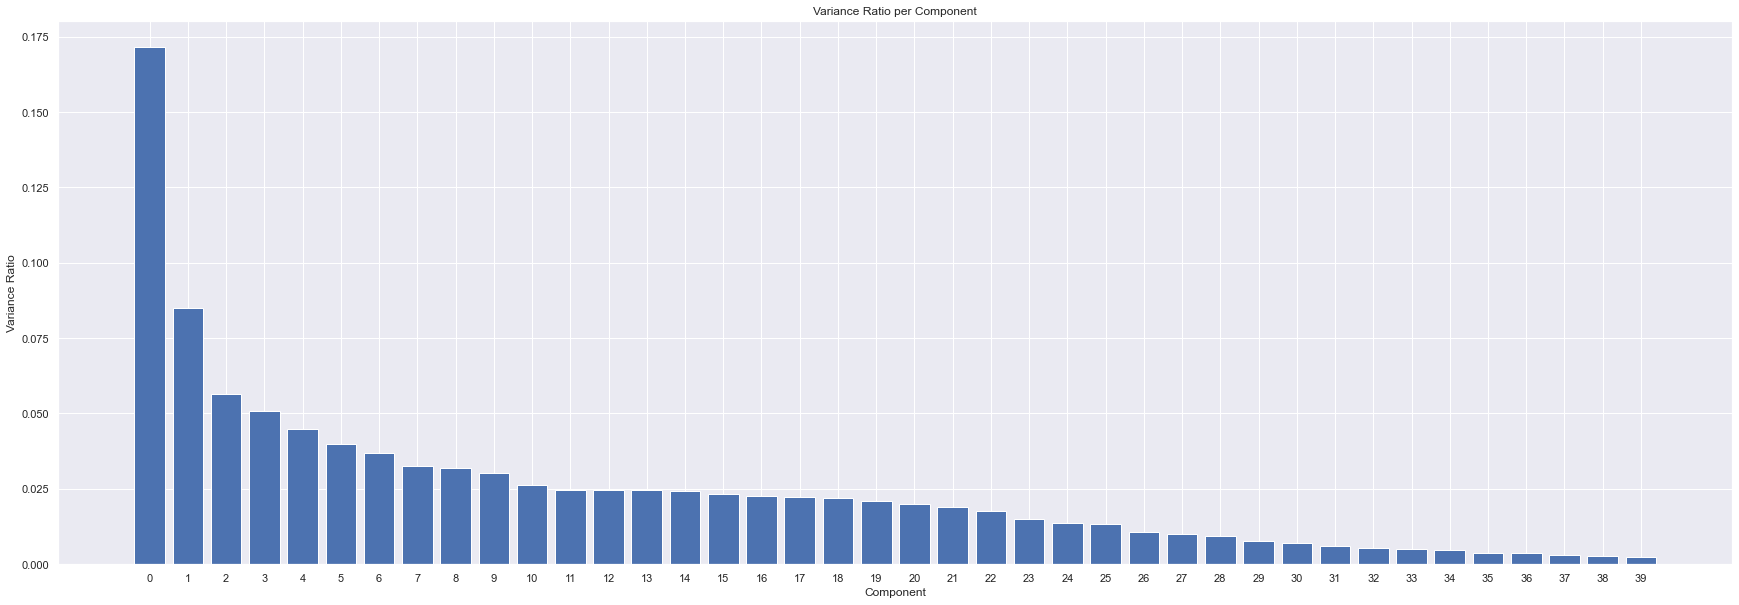

In [219]:
ratios = pca.explained_variance_ratio_
comp = pca.components_

# Create a DataFrame combining components and ratios
comp_to_ratios = pd.DataFrame(np.concatenate([comp, ratios.reshape(-1, 1)], axis=1))

# Get the number of components
num_components = len(ratios)

# Plot the variance ratio per component
plt.figure(figsize=(30, 10))
plt.bar(range(num_components), comp_to_ratios.iloc[:, -1])
plt.xlabel('Component')
plt.ylabel('Variance Ratio')
plt.title('Variance Ratio per Component')
plt.xticks(range(num_components))
plt.show()

In [220]:
print("X_val_reduced shape:", X_val_reduced.shape)
print("ylog_val shape:", ylog_val.shape)

print("X_train_reduced shape:", X_train_reduced.shape)
print("ylog_train shape:", ylog_train.shape)

print("test_reduced shape:", test_reduced.shape)

X_val_reduced shape: (12000, 40)
ylog_val shape: (12000,)
X_train_reduced shape: (45592, 40)
ylog_train shape: (45592,)
test_reduced shape: (18000, 45)


__PCA only on numeric featuers:__

In the following, there are prediction models that do not need a significant size reduction like: Random Forest / gradient boosting, so we will use another method that reduces the dimensions of the numerical features only.

In [221]:
print(len(Xlog_val.columns), "numeric features are:", Xlog_val.columns)
print()

updated_numeric_features = Xlog_val.select_dtypes(include=[np.number]).columns
updated_numeric_features = [feature for feature in updated_numeric_features if "has" not in feature and "C_" not in feature]
updated_numeric_features = [feature for feature in updated_numeric_features if feature not in top_words]
print(len(updated_numeric_features), "numeric features are:", updated_numeric_features)
print()

updated_not_numeric_features = [feature for feature in Xlog_val.columns if feature not in updated_numeric_features]
print(len(updated_not_numeric_features), "removed features are:", updated_not_numeric_features)
print()

45 numeric features are: Index(['imports', 'has_debug', 'has_relocations', 'has_resources',
       'has_signature', 'has_tls', 'paths', 'urls', 'MZ', 'printables',
       'avlength', 'file_type_prob_trid', 'A', 'B', 'C_bf', 'C_cs', 'C_er',
       'C_gow', 'C_mc', 'C_vh', 'C_vr', 'assembly', 'extracting', 'panel',
       'net', 'borland', 'upx', 'dos', 'win64', 'compiled', 'setup', '0x',
       'win16', 'code_density', 'i_e_ratio', 'has_debug*has_relocations',
       'has_debug*has_resources', 'has_debug*has_signature',
       'has_debug*has_tls', 'has_relocations*has_resources',
       'has_relocations*has_signature', 'has_relocations*has_tls',
       'has_resources*has_signature', 'has_resources*has_tls',
       'has_signature*has_tls'],
      dtype='object')

11 numeric features are: ['imports', 'paths', 'urls', 'MZ', 'printables', 'avlength', 'file_type_prob_trid', 'A', 'B', 'code_density', 'i_e_ratio']

34 removed features are: ['has_debug', 'has_relocations', 'has_resources', 'has

For explained variance: 0.5 number of dimensions: 3
For explained variance: 0.6 number of dimensions: 4
For explained variance: 0.7 number of dimensions: 5
For explained variance: 0.8 number of dimensions: 6
For explained variance: 0.9 number of dimensions: 8
For explained variance: 0.95 number of dimensions: 9
For explained variance: 0.99 number of dimensions: 11
For explained variance: 0.995 number of dimensions: 11
For explained variance: 0.9999 number of dimensions: 11


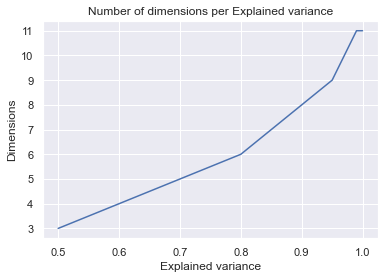

In [222]:
# Select the desired features from Xlog_train
X_selected = Xlog_train[updated_numeric_features]
variance_vals = [0.5, 0.6, 0.7, .8, .9, 0.95, 0.99, 0.995, .9999]
var_dim = []
for variance in variance_vals:
    pca = PCA(variance)
    data = pca.fit_transform(X_selected)
    print("For explained variance:", variance, "number of dimensions:", data.shape[1])
    var_dim.append(data.shape[1])
plt.plot(variance_vals, var_dim)
plt.xlabel("Explained variance")
plt.ylabel("Dimensions")
plt.title("Number of dimensions per Explained variance")
plt.show()

According to the graph above, using the same logic as before when choosing variance threshold, we will choose 0.95.

In [223]:
new_variance_threshold = 0.995
pca, X_train_numeric_reduced = perform_pca_with_variance(new_variance_threshold, X_selected)
X_train_combined = pd.DataFrame(np.concatenate((Xlog_train[updated_not_numeric_features], X_train_numeric_reduced), axis=1))

X_val_numeric_reduced = apply_pca_transformation(pca, Xlog_val[updated_numeric_features])
X_val_combined = pd.DataFrame(np.concatenate((Xlog_val[updated_not_numeric_features], X_val_numeric_reduced), axis=1))

test_numeric_reduced = apply_pca_transformation(pca, test_df[updated_numeric_features])
test_combined = pd.DataFrame(np.concatenate((test_df[updated_not_numeric_features], test_numeric_reduced), axis=1))

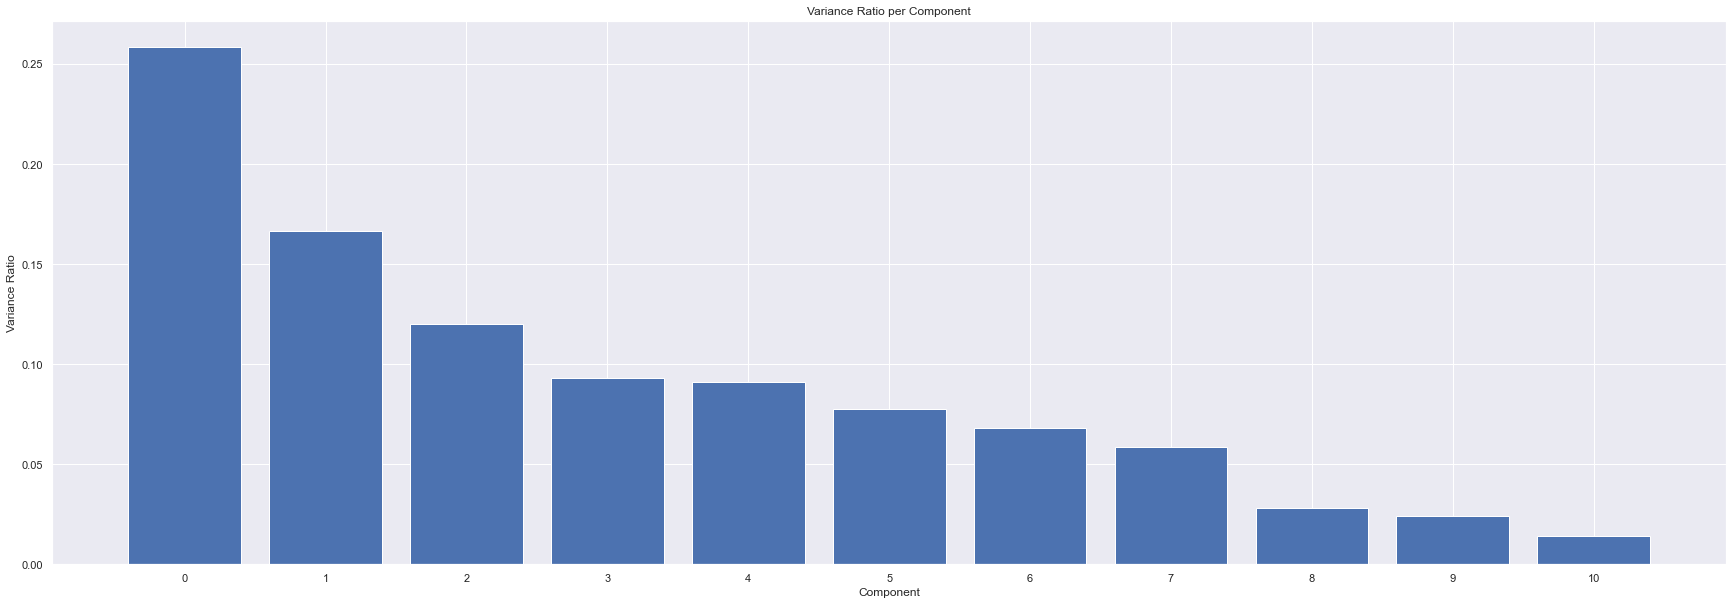

In [224]:
ratios = pca.explained_variance_ratio_
comp = pca.components_

# Create a DataFrame combining components and ratios
comp_to_ratios = pd.DataFrame(np.concatenate([comp, ratios.reshape(-1, 1)], axis=1))

# Get the number of components
num_components = len(ratios)

# Plot the variance ratio per component
plt.figure(figsize=(30, 10))
plt.bar(range(num_components), comp_to_ratios.iloc[:, -1])
plt.xlabel('Component')
plt.ylabel('Variance Ratio')
plt.title('Variance Ratio per Component')
plt.xticks(range(num_components))
plt.show()

In [225]:
print("X_train_combined shape:", X_train_combined.shape)
print("ylog_val shape:", ylog_val.shape)

print("X_val_combined shape:", X_val_combined.shape)
print("ylog_train shape:", ylog_train.shape)

print("test_combined shape:", test_combined.shape)

X_train_combined shape: (45592, 45)
ylog_val shape: (12000,)
X_val_combined shape: (12000, 45)
ylog_train shape: (45592,)
test_combined shape: (18000, 45)


#### Backwards selection:

Backwards selection: we will write one function to remove a feature and another to remove many

we will remove each feature via a greedy algorithm according to a kfold score of auc

# TO EXPLAINE

In [226]:

def get_score(estimator, X, y):
    '''
    Calculates the cross-validated score (ROC AUC) for an estimator using KFold cross-validation.
    Parameters:
        estimator: The estimator object to evaluate.
        X: The input features.
        y: The target variable.
    Returns:
        score: The average cross-validated score.'''
    cv = 3
    kf = KFold(shuffle=True, n_splits=cv, random_state=0)
    score = 0
    for train_index, test_index in kf.split(X):
        estimator.fit(X.iloc[train_index], y.iloc[train_index])
        pred = estimator.predict_proba(X.iloc[test_index])[:, 1]
        score += metrics.roc_auc_score(y.iloc[test_index], pred)
    return score / cv


def remove_feature(estimator, X, y):
    '''
    Removes one feature at a time and returns the best set of features based on the estimator's score.
    Parameters:
        estimator: The estimator object used for evaluation.
        X: The input features.
        y: The target variable.
    Returns:
        best_features: The best set of features.
    '''
    features = list(X.columns)
    best_features = None
    best_score = 0
    for i in range(len(features)):
        curr_features = features[:i] + features[i + 1:]
        score = get_score(estimator, X[curr_features], y)
        if score > best_score:
            best_score = score
            best_features = curr_features.copy()
    return best_features


def backward_selection(estimator, X, y):
    '''
    Performs backward feature selection based on the estimator's score.
    Parameters:
        estimator: The estimator object used for evaluation.
        X: The input features.
        y: The target variable.
    Returns:
        best_features: The best set of features after backward selection.
    '''
    best_features = list(X.columns)
    prev_score = 0
    while len(best_features) > 1:
        current_features = remove_feature(estimator, X[best_features], y)
        curr_score = get_score(estimator, X[current_features], y)
        if curr_score < prev_score:
            break
        best_features = current_features.copy()
        prev_score = curr_score
    return best_features



## Part 3 - Running the models

In order to find the best hyper parameters and test each model's performence, we will use 2 functions:

getBestModel - gets an estimator and a dictionary of parameters and values, that performes a grid-search on each combination of hyper parameters and uses Kfold cross-validation in order to find the best combination and returns the best estimator, and prints out the CV score.<br>
We used the GridSearchCV function as we used in the homework assignments, since it automatically perfoms the KFold cross-validation and returns the best estimator, and thus we can give ranges for hyperparameters.

In [227]:
### define a functino that will perform a grid search on model

def getBestModel(estimator, params, XTrain, ytrain, v=3, nj=1):
    '''
    Performs grid search cross-validation to find the best model based on the given estimator and parameter grid.
    Trains the best model on the training data and evaluates its performance on the test data.
    Parameters:
        estimator: object, the model estimator.
        params: dict, the parameter grid for grid search.
        XTrain: DataFrame, the training features.
        ytrain: Series, the training labels.
        XTest: DataFrame, the test features.
        ytest: Series, the test labels.
        v: int, verbose level for grid search (default=3).
        nj: int, number of parallel jobs for grid search (default=1).
    Returns:
        best_estimator: object, the best model based on cross-validation.
    '''
    cv = GridSearchCV(estimator= estimator, param_grid=params, verbose=v, scoring='roc_auc', cv=3, n_jobs=nj)
    cv.fit(XTrain, ytrain)
    print("Best Parameters:",  cv.best_params_)
    print("With the CV score of",cv.best_score_)
    return cv.best_estimator_

    


### Running two "simple" models:

The first model we ran is a logistic regression:

For the logistic Regression we will give a range of Cs (range for penalties / regularizations) as we've done in our homework assignments as well as different penalties, class_weight might affect the performence and fit_intercept being True or False since we might need the extra bias.

In [228]:
powers = range(-10,1)
Cs = [10**p for p in powers] #This is the inverse value for the lambda parameter.

lr = LogisticRegression(solver = 'liblinear')
params = {'C' : Cs,
         'fit_intercept' : [True, False], 
         'penalty' : ['l1', 'l2'],
         'class_weight':['balanced', None]}
lr_best_model = getBestModel(lr, params, X_train_combined, ylog_train)

Fitting 3 folds for each of 88 candidates, totalling 264 fits
[CV 1/3] END C=1e-10, class_weight=balanced, fit_intercept=True, penalty=l1;, score=0.500 total time=   0.0s
[CV 2/3] END C=1e-10, class_weight=balanced, fit_intercept=True, penalty=l1;, score=0.500 total time=   0.0s
[CV 3/3] END C=1e-10, class_weight=balanced, fit_intercept=True, penalty=l1;, score=0.500 total time=   0.0s
[CV 1/3] END C=1e-10, class_weight=balanced, fit_intercept=True, penalty=l2;, score=0.795 total time=   0.0s
[CV 2/3] END C=1e-10, class_weight=balanced, fit_intercept=True, penalty=l2;, score=0.799 total time=   0.0s
[CV 3/3] END C=1e-10, class_weight=balanced, fit_intercept=True, penalty=l2;, score=0.795 total time=   0.0s
[CV 1/3] END C=1e-10, class_weight=balanced, fit_intercept=False, penalty=l1;, score=0.500 total time=   0.0s
[CV 2/3] END C=1e-10, class_weight=balanced, fit_intercept=False, penalty=l1;, score=0.500 total time=   0.0s
[CV 3/3] END C=1e-10, class_weight=balanced, fit_intercept=False

[CV 1/3] END C=1e-07, class_weight=balanced, fit_intercept=False, penalty=l1;, score=0.500 total time=   0.0s
[CV 2/3] END C=1e-07, class_weight=balanced, fit_intercept=False, penalty=l1;, score=0.500 total time=   0.0s
[CV 3/3] END C=1e-07, class_weight=balanced, fit_intercept=False, penalty=l1;, score=0.500 total time=   0.0s
[CV 1/3] END C=1e-07, class_weight=balanced, fit_intercept=False, penalty=l2;, score=0.795 total time=   0.0s
[CV 2/3] END C=1e-07, class_weight=balanced, fit_intercept=False, penalty=l2;, score=0.799 total time=   0.0s
[CV 3/3] END C=1e-07, class_weight=balanced, fit_intercept=False, penalty=l2;, score=0.796 total time=   0.0s
[CV 1/3] END C=1e-07, class_weight=None, fit_intercept=True, penalty=l1;, score=0.500 total time=   0.0s
[CV 2/3] END C=1e-07, class_weight=None, fit_intercept=True, penalty=l1;, score=0.500 total time=   0.0s
[CV 3/3] END C=1e-07, class_weight=None, fit_intercept=True, penalty=l1;, score=0.500 total time=   0.0s
[CV 1/3] END C=1e-07, cla

[CV 1/3] END C=0.0001, class_weight=None, fit_intercept=True, penalty=l1;, score=0.500 total time=   0.0s
[CV 2/3] END C=0.0001, class_weight=None, fit_intercept=True, penalty=l1;, score=0.500 total time=   0.0s
[CV 3/3] END C=0.0001, class_weight=None, fit_intercept=True, penalty=l1;, score=0.500 total time=   0.0s
[CV 1/3] END C=0.0001, class_weight=None, fit_intercept=True, penalty=l2;, score=0.835 total time=   0.1s
[CV 2/3] END C=0.0001, class_weight=None, fit_intercept=True, penalty=l2;, score=0.841 total time=   0.1s
[CV 3/3] END C=0.0001, class_weight=None, fit_intercept=True, penalty=l2;, score=0.836 total time=   0.1s
[CV 1/3] END C=0.0001, class_weight=None, fit_intercept=False, penalty=l1;, score=0.500 total time=   0.0s
[CV 2/3] END C=0.0001, class_weight=None, fit_intercept=False, penalty=l1;, score=0.500 total time=   0.0s
[CV 3/3] END C=0.0001, class_weight=None, fit_intercept=False, penalty=l1;, score=0.500 total time=   0.0s
[CV 1/3] END C=0.0001, class_weight=None, f

[CV 3/3] END C=0.1, class_weight=None, fit_intercept=True, penalty=l2;, score=0.863 total time=   0.5s
[CV 1/3] END C=0.1, class_weight=None, fit_intercept=False, penalty=l1;, score=0.861 total time=   0.9s
[CV 2/3] END C=0.1, class_weight=None, fit_intercept=False, penalty=l1;, score=0.864 total time=   1.2s
[CV 3/3] END C=0.1, class_weight=None, fit_intercept=False, penalty=l1;, score=0.862 total time=   1.5s
[CV 1/3] END C=0.1, class_weight=None, fit_intercept=False, penalty=l2;, score=0.862 total time=   0.4s
[CV 2/3] END C=0.1, class_weight=None, fit_intercept=False, penalty=l2;, score=0.865 total time=   0.6s
[CV 3/3] END C=0.1, class_weight=None, fit_intercept=False, penalty=l2;, score=0.862 total time=   0.5s
[CV 1/3] END C=1, class_weight=balanced, fit_intercept=True, penalty=l1;, score=0.862 total time=   3.5s
[CV 2/3] END C=1, class_weight=balanced, fit_intercept=True, penalty=l1;, score=0.865 total time=   1.9s
[CV 3/3] END C=1, class_weight=balanced, fit_intercept=True, pe

The second model we ran is a KNN:

In [229]:
knn = KNeighborsClassifier()
kparams = {'n_neighbors': range(1, 100, 10)}
knn_cv = getBestModel(knn, kparams, X_train_reduced, ylog_train, nj = None)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END .....................n_neighbors=1;, score=0.843 total time=   0.7s
[CV 2/3] END .....................n_neighbors=1;, score=0.848 total time=   0.7s
[CV 3/3] END .....................n_neighbors=1;, score=0.846 total time=   0.7s
[CV 1/3] END ....................n_neighbors=11;, score=0.928 total time=   0.8s
[CV 2/3] END ....................n_neighbors=11;, score=0.930 total time=   0.7s
[CV 3/3] END ....................n_neighbors=11;, score=0.924 total time=   0.7s
[CV 1/3] END ....................n_neighbors=21;, score=0.924 total time=   0.8s
[CV 2/3] END ....................n_neighbors=21;, score=0.925 total time=   0.9s
[CV 3/3] END ....................n_neighbors=21;, score=0.921 total time=   0.9s
[CV 1/3] END ....................n_neighbors=31;, score=0.919 total time=   0.8s
[CV 2/3] END ....................n_neighbors=31;, score=0.921 total time=   0.8s
[CV 3/3] END ....................n_neighbors=31;

#### Running two "advanced" models:

# TO-DO

In [281]:
r_clf = ensemble.RandomForestClassifier(random_state=0, n_estimators=100)
gbm_clf = ensemble.GradientBoostingClassifier(random_state=0)
ada_clf = ensemble.AdaBoostClassifier(random_state=0)

ada_params = {'n_estimators' : [50, 100, 200, 500, 1000],
              'learning_rate' : [0.15, 0.5, 1],}
gbm_params = {'learning_rate' : [.1],
              'max_depth' : [10],
              'max_features' : [0.3],
              'n_estimators' : [1000]} #### We will edit this later to have more hyperparameters

#Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'max_features': 0.3, 'n_estimators': 1000}
#With the CV score of 0.9809060813091156

#
r_params = {'max_features' : ['sqrt', 0.2, 0.3]}


In [282]:
gbm_best_model = getBestModel(gbm_clf, gbm_params, Xlog_train, ylog_train, nj = None)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END learning_rate=0.1, max_depth=10, max_features=0.3, n_estimators=1000;, score=0.981 total time= 2.0min
[CV 2/3] END learning_rate=0.1, max_depth=10, max_features=0.3, n_estimators=1000;, score=0.981 total time= 2.0min
[CV 3/3] END learning_rate=0.1, max_depth=10, max_features=0.3, n_estimators=1000;, score=0.981 total time= 2.0min
Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'max_features': 0.3, 'n_estimators': 1000}
With the CV score of 0.9809060813091156


In [232]:
#r_best_model = getBestModel(r_clf, r_params, Xlog_train, ylog_train, nj = None)

In [233]:
#ada_best_model = getBestModel(ada_clf, ada_params, Xlog_train, ylog_train, nj = None)


In [251]:
mlp_clf = MLPClassifier(solver='sgd', activation='relu')
mlp_params = {'alpha' : [.1],
          'learning_rate_init' : [0.1]}

mlp_cv = getBestModel(mlp_clf, mlp_params, X_train_reduced, ylog_train, nj = None)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END .alpha=0.1, learning_rate_init=0.1;, score=0.952 total time=  15.9s
[CV 2/3] END .alpha=0.1, learning_rate_init=0.1;, score=0.954 total time=  10.3s
[CV 3/3] END .alpha=0.1, learning_rate_init=0.1;, score=0.950 total time=  13.7s
Best Parameters: {'alpha': 0.1, 'learning_rate_init': 0.1}
With the CV score of 0.9519689146837506


## Part 4 - Evaluation the models

# TO DO

Steps for evaluation the models:

1. Confusion Matrix on the ----- model (decide on which model)
2. K-Fold Cross Validation and ROC 
3. Train and validation scores and talking about the variance-bias trade-off
4. Choosing the final model


### Confusion Matrix

* A confusion matrix is a performance evaluation tool used in classification tasks to visualize the performance of a machine learning model. It provides a summary of the predictions made by the model compared to the actual labels in a tabular format. It represents the four possible outcomes of a binary classification problem:
    - True Positive (TP): The model predicted a positive class correctly.
    - False Positive (FP): The model predicted a positive class incorrectly.
    - False Negative (FN): The model predicted a negative class incorrectly.
    - True Negative (TN): The model predicted a negative class correctly.
* The Train Confusion Matrix represents the performance of the model on the training set. It shows how well the model predicts the training data, where the model has already seen these data points during training.
* The Test Confusion Matrix represents the performance of the model on the test set. It shows how well the model generalizes to unseen data, which it has not encountered during training.
* Train Accuracy is the accuracy score calculated based on the Train Confusion Matrix. It represents the proportion of correctly predicted samples in the training set.
* Test Accuracy is the accuracy score calculated based on the Test Confusion Matrix. It represents the proportion of correctly predicted samples in the test set.
    - Higher accuracy values indicate better performance. However, it's essential to consider them in conjunction with other evaluation metrics, as accuracy alone may not provide a complete picture. 

In [283]:
def build_confusion_matrix(model, X_train, y_train, X_test, y_test):
    '''
    Builds and displays the confusion matrix for the train and test sets, along with accuracy scores.
    Parameters:
        model: The trained model used for prediction.
        X_train: The input features of the training set.
        y_train: The target variable of the training set.
        X_test: The input features of the test set.
        y_test: The target variable of the test set.
    '''
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    train_cm = confusion_matrix(y_train, train_predictions)
    test_cm = confusion_matrix(y_test, test_predictions)

    #the order is: [['TP', 'FP'], ['FN', 'TN']]
    tn_train, fp_train, fn_train, tp_train = train_cm.ravel()
    tn_test, fp_test, fn_test, tp_test = test_cm.ravel()

    train_cm_array = np.array([[tp_train, fp_train] , [fn_train, tn_train]])
    test_cm_array = np.array([[tp_test, fp_test] , [fn_test, tn_test]])

    print("Train Confusion Matrix:")
    print(train_cm_array)
    print()
    print("Test Confusion Matrix:")
    print(test_cm_array)

    #accuracy = (TP + TN) / (TP + FP + FN + TN)
    train_accuracy = ( tp_train + tn_train ) / train_cm_array.sum()
    test_accuracy = ( tp_test + tn_test ) / test_cm_array.sum()

    print()
    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)

    #plot the confusion matrix
    #train
    fig_train, ax_train = plt.subplots()
    im_train = ax_train.imshow(train_cm_array, cmap='Blues')
    cbar_train = ax_train.figure.colorbar(im_train, ax=ax_train)
    ax_train.grid(False)  # Disable gridlines
    ax_train.set_xticks(np.arange(train_cm_array.shape[1]))
    ax_train.set_yticks(np.arange(train_cm_array.shape[0]))
    ax_train.set_yticklabels(['Predicted Positive', 'Predicted Negative'])
    ax_train.set_xticklabels(['Actual Positive', 'Actual Negative'])
    #go over the data
    for i in range(train_cm_array.shape[0]):
        for j in range(train_cm_array.shape[1]):
            ax_train.text(j, i, train_cm_array[i, j], ha='center', va='center', color='black')
    ax_train.set_title('Train Confusion Matrix')
    plt.show()

    #test
    fig_test, ax_test = plt.subplots()
    im_test = ax_test.imshow(test_cm_array, cmap='Blues')
    cbar_test = ax_test.figure.colorbar(im_test, ax=ax_test)
    ax_test.grid(False)  # Disable gridlines
    ax_test.set_xticks(np.arange(test_cm_array.shape[1]))
    ax_test.set_yticks(np.arange(test_cm_array.shape[0]))
    ax_test.set_yticklabels(['Predicted Positive', 'Predicted Negative'])
    ax_test.set_xticklabels(['Actual Positive', 'Actual Negative'])
    #go over the data
    for i in range(test_cm_array.shape[0]):
        for j in range(test_cm_array.shape[1]):
            ax_test.text(j, i, test_cm_array[i, j], ha='center', va='center', color='black')
    ax_test.set_title('Test Confusion Matrix')
    plt.show()
    
### a feature to AUC for each fold
def plotROC(estimator, XTrain, ytrain, K):
    '''
    Plots the Receiver Operating Characteristic (ROC) curve for the given estimator using K-fold cross-validation.
    Parameters:
        estimator: object, the model estimator.
        XTrain: DataFrame, the training features.
        ytrain: Series, the training labels.
        K: int, the number of folds for cross-validation.
    '''
    kf = KFold(n_splits = K, shuffle=True, random_state=0)
    plt.figure(figsize=(10, 8))
    for train_index, test_index in kf.split(XTrain):
        X_train, X_test, y_train, y_test = XTrain.iloc[train_index], XTrain.iloc[test_index], ytrain.iloc[train_index], ytrain.iloc[test_index]
        estimator.fit(X_train, y_train)
        probas_ = estimator.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = metrics.roc_curve(y_test, probas_)
        auc = metrics.roc_auc_score(y_test, probas_)
        plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.4f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
    
def printTestAuc(estimator, X, y, estimator_name):
    '''
    Calculates and prints the validation AUC score for the given estimator on the provided data.
    Parameters:
        estimator: object, the model estimator.
        X: DataFrame, the input features.
        y: Series, the target labels.
        estimator_name: str, the name of the estimator.
    '''
    pred = estimator.predict_proba(X)[:,1]
    val_auc = metrics.roc_auc_score(y, pred)
    print('validation AUC of ' + estimator_name+':',val_auc)

In [236]:
#build_confusion_matrix(lr_best_model, X_train_combined, ylog_train, X_val_combined, ylog_val) #LogisticRegression

In [237]:
#build_confusion_matrix(r_best_model, X_train_combined, ylog_train, X_val_combined, ylog_val) #RandomForestClassifier  

In [238]:
#build_confusion_matrix(ada_best_model, X_train_combined, ylog_train, X_val_combined, ylog_val) #AdaBoostClassifier

In [239]:
#build_confusion_matrix(knn_cv, X_train_reduced, ylog_train, X_val_reduced, ylog_val) #KNN

Train Confusion Matrix:
[[23277     0]
 [    0 22315]]

Test Confusion Matrix:
[[5456  398]
 [ 489 5657]]

Train Accuracy: 1.0
Test Accuracy: 0.9260833333333334


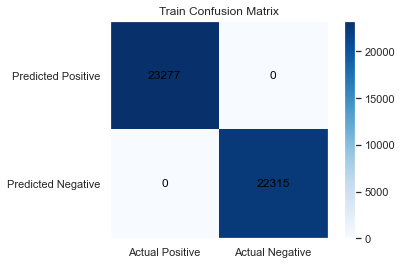

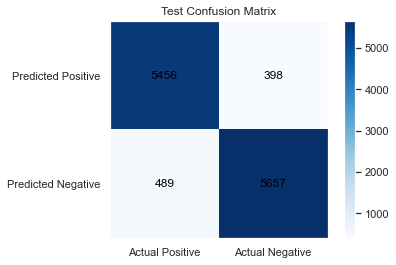

In [284]:
build_confusion_matrix(gbm_best_model, Xlog_train, ylog_train, Xlog_val, ylog_val) #GradientBoostingClassifier

Above we can see the confusion matrix on both train and validation set, with the predictions of the Gradient Boosting model. 

What can we learn from the model? that there is a slight drop in accuracy, seeing that the training data's accuracy is 1 addn the test data's accuracy is 0.923, it might be a sign of overfitting, but for that we will need to see how the AUC for each model both on the KFold cross validation and the validation set we've set aside.

### explain later

#### Evaluating AUC for all the models

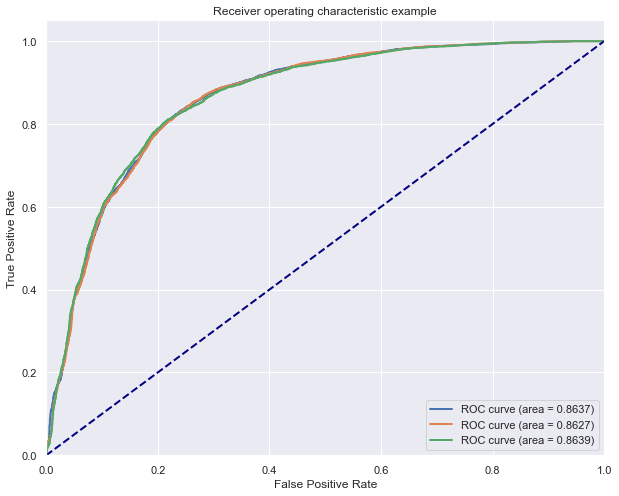

validation AUC of LogisticRegression: 0.8516335330954894


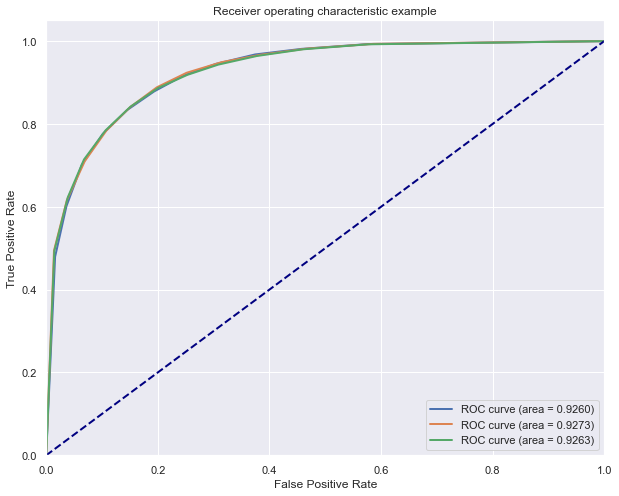

validation AUC of KNN: 0.9236116784813168


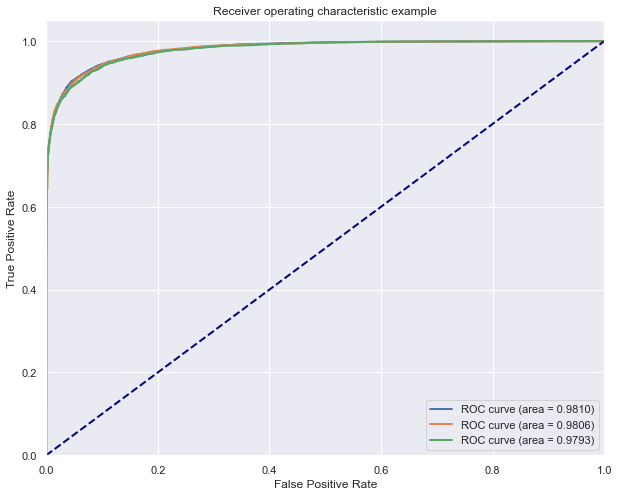

validation AUC of Gradient Boosting: 0.9774817745102193


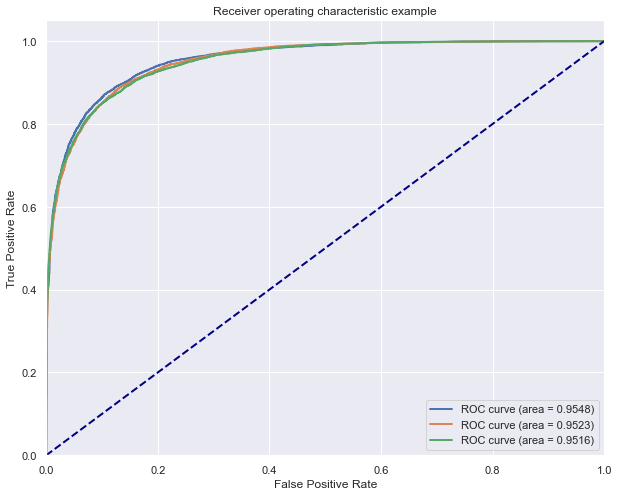

validation AUC of MLP: 0.9464789749694246


In [285]:
models = [lr_best_model, knn_cv, gbm_best_model, mlp_cv]
names = ['LogisticRegression', 'KNN', 'Gradient Boosting', 'MLP']
k = 3
for i in range(len(models)):
    plotROC(models[i], Xlog_train, ylog_train, k)
    printTestAuc(models[i], Xlog_val, ylog_val, names[i])

Based on the auc on the cross validation and the validation set, we will go with the Gradient Boosting model, since it gives us the highest AUC both via the K-fold cross validation and the validation set we have from the split.

## Part 5 - Prediction

Steps for predication:

1. forecasting the files in "test.csv"
2. Results csv file
3. Final pipline (using functions and helping lists from the pre-processing)

In [242]:
def CreatePredictCSV(estimator, ids, X, file_name):
    pred = estimator.predict_proba(X)[:, 1]
    output = pd.DataFrame({'sha256': ids, 'proba': pred})
    output.to_csv(file_name, index=False)
    return pred

In [243]:

ids = testing_df['sha256']
testing_df.head()


sha256     size      vsize  \
0  023928c14abe04196d45bb4578b8fa0eb02189898ce93b...   964814 2072576.00   
1  6436083d4eed84436768d66829b961927eeb9de2e6657f...   116736  200704.00   
2  038e71f41fdc5edb3a7afc112fb0679a4a5d6d94512055...  3091456  118784.00   
3  be913ef29b4566e7817a5ab2c4a4289a455e9b562e1da0...  1249792 1257472.00   
4  e78f83f0af4f1fbcf8fffd562b4734701483818078bf0e...  2117632 2142208.00   

   imports  exports  has_debug  has_relocations  has_resources  has_signature  \
0     2.00      NaN       0.00             0.00            NaN           0.00   
1   136.00     0.00       1.00             1.00           1.00           0.00   
2   124.00     1.00       0.00             1.00           1.00           0.00   
3     0.00     0.00       1.00             1.00           1.00           0.00   
4   165.00     0.00       0.00             0.00           1.00           0.00   

   has_tls  symbols  numstrings  paths  urls  registry    MZ  printables  \
0     0.00     0.00     4021.00   0.00  0.00      0.00 14.00    22934.00   
1     0.00     0.00      365.00   1.00  0.00      0.00  5.00     7445.00   
2     0.00     0.00    13421.00  12.00  0.00      0.00  9.00   148608.00   
3     0.00     0.00     6486.00   0.00   NaN      0.00  2.00   121156.00   
4     0.00     0.00     2864.00   4.00  0.00      0.00  2.00    21562.00   

   avlength                             file_type_trid  file_type_prob_trid  \
0      5.70                 Win32 Executable (generic)                42.70   
1     20.40   Win32 Executable MS Visual C++ (generic)                48.80   
2     11.07                        InstallShield setup                24.10   
3     18.68                 Win32 Executable (generic)                33.10   
4      7.53  Win32 Executable Microsoft Visual Basic 6                84.40   

      A    B   C  
0 -1.41 6.55  er  
1   NaN 5.58  cs  
2 -1.71 6.10  vh  
3  9.22 5.42  vh  
4  2.22  NaN  er

In [244]:
ids.head()

0    023928c14abe04196d45bb4578b8fa0eb02189898ce93b...
1    6436083d4eed84436768d66829b961927eeb9de2e6657f...
2    038e71f41fdc5edb3a7afc112fb0679a4a5d6d94512055...
3    be913ef29b4566e7817a5ab2c4a4289a455e9b562e1da0...
4    e78f83f0af4f1fbcf8fffd562b4734701483818078bf0e...
Name: sha256, dtype: object

In [245]:
CreatePredictCSV(gbm_best_model, ids, c_test, 'predictions.csv')

array([6.15576567e-02, 2.86863318e-05, 5.69677841e-05, ...,
       2.93506433e-03, 1.69530277e-02, 1.37699663e-05])

PipeLine:

In [246]:
pl_train = pd.read_csv('train.csv')
pl_train_labels = pl_train['label']
pl_train.drop('label', inplace=True, axis=1)
pl_test = pd.read_csv('test.csv')

# creating dummy variables with C
C_val, enc, pl_train = X_fit_with_dummy(pl_train, 'C', 'unknown')
pl_test = X_with_dummy(pl_test, 'C', 'unknown', enc, C_val)
pl_train_labels.reset_index(inplace=True, drop=True)
# Log transformation of relevant features

log_transform(pl_train, to_log)
log_transform(pl_test, to_log)

# using adding tf-idf features
v, top_words, pl_train, new_cols = AddTopk_and_fit(pl_train, pl_train_labels, 'file_type_trid', 23)
pl_test = AddTfIdf(pl_test, 'file_type_trid', top_words, v)
pl_train.drop(removed_words, inplace=True, axis =1)
pl_test.drop(removed_words, inplace=True, axis = 1)
#adding new features

pl_train = compute_additional_features(pl_train)
pl_test = compute_additional_features(pl_test)

test_ids = pl_test['sha256']

pl_train.drop(['sha256', 'file_type_trid'], inplace=True, axis=1)
pl_test.drop(['sha256', 'file_type_trid'], inplace=True, axis=1)

pl_train = remove_features(pl_train, removed_features)
pl_test = remove_features(pl_test, removed_features)

# removing outliers

pl_train, pl_train_labels = remove_outliers_zscore(pl_train, pl_train_labels, normally_features)
pl_train, pl_train_labels = remove_outliers_isolation_forest(pl_train, pl_train_labels)


# dealing with missing values - bool

mode_vals = fit_fill_bool(pl_train, boolean_features)
fill_bool(pl_test, boolean_features, mode_vals)

# adding interactions

add_interactions(pl_train, boolean_features)
add_interactions(pl_test, boolean_features)

# dealing with missing values - numeric

imputer = SimpleImputer(missing_values=np.nan, strategy='median')
for numeric in numerical:
    if numeric not in removed_features:
        pl_train, imputer = fit_missing_values(pl_train, imputer, numeric)
        pl_test = fill_missing_values(pl_test, imputer, numeric)
        
# normalizing

scaler = StandardScaler()
for col in pl_test.columns:
    pl_train, scaler = fit_normalize_data(pl_train, scaler, col)
    pl_test = transform_normalize_data(pl_test, scaler, col)

# we wont do PCA since our final model doesn't need it
gbm_clf = ensemble.GradientBoostingClassifier(random_state=0)
gbm_best_model = getBestModel(gbm_clf, gbm_params, pl_train, pl_train_labels, nj=None)



removing via Zscore outliers by feature A
removing via Zscore outliers by feature printables
removing via Zscore outliers by feature code_density
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END learning_rate=0.15, max_depth=15, max_features=0.35, n_estimators=500;, score=0.983 total time= 2.4min


KeyboardInterrupt: 

FOR YUVAL TO PLAY AROUND WITH

In [ ]:
CreatePredictCSV(gbm_best_model, test_ids, pl_test, 'pipeLine.csv')